# Import Important Libraries

In [ ]:
from sumy.summarizers.lsa import LsaSummarizer #Latent Semantic Analysis
from sumy.summarizers.text_rank import TextRankSummarizer #Unsupervised graph
from sumy.summarizers.lex_rank import LexRankSummarizer #Unsupervised graph
from sumy.summarizers.sum_basic import SumBasicSummarizer #baseline
from sumy.summarizers.luhn import LuhnSummarizer #heurestic 

from sumy.parsers.plaintext import PlaintextParser
from sumy.parsers.html import HtmlParser
from typing import List
from itertools import chain
import re
import string
import math 
from glob import glob
from datetime import datetime
import numpy as np
import pandas as pd
import json
from sumy.models import TfDocumentModel
from sumy.evaluation import cosine_similarity,rouge_1,rouge_2,rouge_n,rouge_l_sentence_level,rouge_l_summary_level,precision,recall,f_score,unit_overlap
import matplotlib as mpl
import matplotlib.pyplot as plt

print("date and time =", datetime.now().strftime("%d/%m/%Y %H:%M:%S"))# dd/mm/YY H:M:S


date and time = 27/01/2021 15:58:43


#Use Diff Evaluation Measures

The following five evaluation metrics are available.

**ROUGE-1** refers to the overlap of unigram (each word) between the system and reference summaries.

**ROUGE-2** refers to the overlap of bigrams between the system and reference summaries.

**ROUGE-L**: Longest Common Subsequence (LCS)based statistics. Longest common subsequence problem takes into account sentence level structure similarity naturally and identifies longest co-occurring in sequence n-grams automatically.

**Recall**: |system-human choice overlap| / |sentences chosen by human|

**Precision**: And precision is the fraction of system sentences that were correct 

**Formula** :|system-human choice overlap| / |sentences chosen by system|


In [ ]:
def evaluate_cosine_similarity(evaluated_sentences, reference_sentences):
    evaluated_words = tuple(chain(*(s.words for s in evaluated_sentences)))
    reference_words = tuple(chain(*(s.words for s in reference_sentences)))
    evaluated_model = TfDocumentModel(evaluated_words)
    reference_model = TfDocumentModel(reference_words)

    return cosine_similarity(evaluated_model, reference_model)

def evaluate_unit_overlap(evaluated_sentences, reference_sentences):
    evaluated_words = tuple(chain(*(s.words for s in evaluated_sentences)))
    reference_words = tuple(chain(*(s.words for s in reference_sentences)))
    evaluated_model = TfDocumentModel(evaluated_words)
    reference_model = TfDocumentModel(reference_words)

    return unit_overlap(evaluated_model, reference_model)

AVAILABLE_EVALUATIONS = (
    ("Precision", False, precision),
    ("Recall", False, recall),
    ("F1score", False, f_score),
    ("CosineSimilarity", False, evaluate_cosine_similarity),
    ("UnitOverlap", False, evaluate_unit_overlap),
    ("Rouge1", False, rouge_1),
    ("Rouge2", False, rouge_2),
    ("RougeLSentenceLevel", False, rouge_l_sentence_level),
    ("RougeLSummaryLevel", False, rouge_l_summary_level)
)

# Accessing the Directory and Reading the Files Processed and Processed Segment

In [ ]:
def read_file(path):
    filenames = glob(path)
    files_data=[];
    files_stem_data=[];
    files_sum_data=[];
    for filename in filenames:
        stemfile=filename.replace(".txt", "_stemmed.txt")
        sumfile=filename.replace(".txt", "sum.txt")
        
        document_raw_data=open(filename, "r", encoding="utf8")#Read All Documents
        files_data.append(document_raw_data.read())
        document_raw_data.close()
        
        document_raw_data=open(stemfile, "r", encoding="utf8")#Read All Documents
        files_stem_data.append(document_raw_data.read())
        document_raw_data.close()
        
        document_raw_data=open(sumfile, "r", encoding="utf8")#Read All Documents
        files_sum_data.append(document_raw_data.read())
        document_raw_data.close()
        
    return files_data,files_stem_data,files_sum_data
    
def getfiles():
    

    non_segmented_txt_files='UrduSummaryCorpus\processed\*[0-9].txt';
    segmented_txt_files='UrduSummaryCorpus\processed_seg\*[0-9].txt';
    
    non_segmented_txt_files_data,non_segmented_txt_stemmed_data,non_segmented_sum_txt_files_data=read_file(non_segmented_txt_files)
    segmented_txt_files_data,segmented_txt_stemmed_data,segmented_sum_txt_files_data=read_file(segmented_txt_files)
  
    df=pd.DataFrame(columns=['NonSegmentedData','NonSegmentedSum','Lsa','TextRank','LexRank','SumBasic','Luhn'])
    df['NonSegmentedData']=non_segmented_txt_files_data
    df['NonSegmentedStem']=non_segmented_txt_stemmed_data
    df['NonSegmentedSum']=non_segmented_sum_txt_files_data
    
    df2=pd.DataFrame(columns=['SegmentedData','SegmentedSum','Lsa','TextRank','LexRank','SumBasic','Luhn'])
    
    df2['SegmentedData']=segmented_txt_files_data
    df2['SegmentedStem']=segmented_txt_stemmed_data
    df2['SegmentedSum']=segmented_sum_txt_files_data
    
    return df,df2
    
df_non_seg,df_seg=getfiles()  
display(df_non_seg)

NonSegmentedData  \
0   ﻿کراچی کے مختلف علاقوں میں فائرنگ اور دیگر پر ...   
1   ﻿الیکشن تو سلیکشن تھا ایسا ہی ہونا تھا سوہو گی...   
2   ﻿یوں توآئے دن کوئی نا کوئی واقعہ رونما ہوتا ہے...   
3   ﻿حضرت موسی نے جب بنی اسرائیل کو جنگ کرنے کا حک...   
4   ﻿ذمرہ فوج چھ ستمبر کی جنگ میں شہید ہونے والوں ...   
5   ﻿مصنف میرا پاکستان ذمرہ قانون و انصاف, سیاست ۔...   
6   ﻿ماہرین کا خیال ہے کہ پھل اور سبزیاں انسانی خو...   
7   ﻿ایک نئی تحقیق میں انکشاف کیا گیا ہے کہ آکسیجن...   
8   ﻿تحقیق کے نتائج سے یہ ظاہر ہوا کہ جو افراد اپن...   
9   ﻿ہیلتھ ڈاٹ کام پر شائع ہونے والے ایک نئے مطالع...   
10  ﻿انسانیت کی نہج کبھی بھی ایک ڈگر پر گامزن نہیں...   
11  ﻿آج افراد صحت ، تندرستی حاصل کرنے کی خاطر ڈاکٹ...   
12  ﻿صبح صبح جب میں چوک سے گزرتا تو سڑک کے دونوں ا...   
13  ﻿انسان جب اپنی اصل کو بھول کر کسی نئی خو د ساخ...   
14  ﻿لالہ ہم لوگ پٹھانوں کو کہتے ہیں ۔\nپنجابی میں...   
15  ﻿بجلی اور گیس کا بحران ہمارے معاشی و سماجی زوا...   
16  ﻿اس وقت پاکستانی قوم ایک افراتفری کا شکار ہے ۔...   
17  ﻿سعودی عرب میں پاکستانی شہریوں نے کہاہے کہ چھپ...   
18  ﻿وائٹ ہاؤس نے اتوار کو ٹوکیو 2020 کے اولمپکس ک...   
19  ﻿آج ملک میں بے شمار پارٹیاں مسلم لیگ کے نام پر...   
20  ﻿رات کی تاریکی میں ایک بہت ہی چھوٹا سا کمرہ جس...   
21  ﻿ملک شام کے ساتھ ہماری جان پہچان تب سے ہے جب س...   
22  ﻿چونکہ ہم مسلمانوں کے گھر پیدا ہوئے ، لہذا جبر...   
23  ﻿بت پرستی تو خیر ہمیشہ سے ہی حضرت انسان کے سات...   
24  ﻿جوں جوں ویب اپنا سفر طے کر رہی ہے ہر چیز میں ...   
25  ﻿ماحولیاتی آلودگی اور پوری دنیا کے بڑھتے ہوئے ...   
26  ﻿چھ دسمبر کو اپنے کواٹر فائنل مقابلوں میں کامی...   
27  ﻿زمبابوے کے دورے پر مایوس کن کارکردگی کے بعد ج...   
28  ﻿اسکاٹ لینڈ نے آئی سی سی ورلڈ کپ کوالیفائرز کے...   
29  ﻿چھ فروری کو 7ویں ایشیائی سرما کھیلوں کا اختتا...   
30  ﻿ایشین ایمرجنگ ٹورنامنٹ 17 سے 25 اگست تک سنگاپ...   
31  ﻿ایکسٹریم اسپورٹس ہمارا ایسا کوئی شوق نہیں ۔\n...   
32  ﻿جس رپورٹ کو بنیاد بنا کر عمر اکمل کو دورۂ زمب...   
33  ﻿زمبابوے کے خلاف ہرارے میں کھیلے جا رہے پہلے ٹ...   
34  ﻿کرکٹ کے بارے میں معمولی سی شدھ بدھ رکھنے والے...   
35  ﻿اس مرتبہ کرک نامہ سے غیر حاضری کچھ زیادہ ہی ط...   
36  ﻿اندازہ ھے کہ جاپان میں اگلے دس سالوں میں بجلی...   
37  ﻿مائیکروسافٹ کے مشہور زمانہ آپریٹنگ سسٹم ونڈوز...   
38  ﻿فوجتسو لمیٹڈ اور مائیکروسافٹ جاپان کو ، میجی ...   
39  ﻿سمارٹ فونز صارفین کی طرف سے سب سے زیادہ مانگ ...   
40  ﻿نوے کی دہائی میں ٹیکنولوجی کی دنیا میں ، پرسن...   
41  ﻿انٹرنیٹ کی دنیا میں ایس ای اوکی اہمیت دن بدن ...   
42  ﻿واکایاما یونیورسٹی میں محققین ایک ایسا نظام ت...   
43  ﻿مائیکروسافٹ ونڈوز ایکس پی کے لئے اپنی سپورٹ8 ...   
44  ﻿سان فرانسسکو ۔\nنائی ٹینڈو نے بدھ کو اپنے وی ...   
45  ﻿کولون ، جرمنی ۔\nسونی کے ایس سی ای کمپیوٹر ان...   
46  ﻿یہ خو بصورت وادی اپنی خوبصورتی اور دل کش نظار...   
47  ﻿اللہ تعالی کے حسن و جمال کا کوئی اندازہ نہیں ...   
48  ﻿آگے چھٹیاں آ رہی تھیں ۔\nدوست کا گاؤں یونیورس...   

                                      NonSegmentedSum  Lsa TextRank LexRank  \
0   ﻿کراچی میں قتل و عام کا سلسلہ جاری ، پیر کو 15...  NaN      NaN     NaN   
1   ﻿الیکشن ایک سلیکشن ہے جس میں ہارنے والوں میں س...  NaN      NaN     NaN   
2   ﻿آئے دن کوئی نیا واقعہ رونما ہوتا ہے ۔\nکبھی گ...  NaN      NaN     NaN   
3   ﻿جب بنی اسرائیل کو حضرت موسی نے جنگ کرنے کا حک...  NaN      NaN     NaN   
4   ﻿ذمرہ فوج آج بھی چھ ستمبر کی جنگ میں شہید ہونے...  NaN      NaN     NaN   
5   ﻿الطاف حسین بیس سال سے انگلینڈ میں پرتعیش سٹائ...  NaN      NaN     NaN   
6   ﻿ماہرین کا خیال ہے کہ پھل اور سبزیاں انسانی خو...  NaN      NaN     NaN   
7   ﻿آکسیجن تھراپی ایک طریقہ علاج ہے ۔\nنئی تحقیق ...  NaN      NaN     NaN   
8   ﻿تحقیق کے نتائج سے ثابت ہوا ہے کہ وہ افراد جو ...  NaN      NaN     NaN   
9   ﻿ہیلتھ ڈاٹ کام پر ایک نئے مطالعاتی جائزے کے مط...  NaN      NaN     NaN   
10  ﻿انسانیت کی نہج میں تغیر و تبدل کا عمل ہمیشہ ر...  NaN      NaN     NaN   
11  ﻿افراد تندرستی حاصل کرنے کی خاطر ڈاکٹروں ، حکی...  NaN      NaN     NaN   
12  ﻿آج جب میں کلاس میں گیا تو بچوں نے پوچھا ’’ سر...  NaN      NaN     NaN   
13  ﻿انسان جب بھی کسی نئی خو د ساختہ راہ پرچلتا ہے...  NaN      NaN     NaN   
1

# Use Space and Segmented Tockenizer

In [ ]:
#Default Tokenizer
class SpaceTokenizer:
    def to_sentences(self, text: str) -> List[str]:
        return [s.strip() for s in text.split("۔")]

    def to_words(self, sentence: str) -> List[str]:
        return [w.strip() for w in sentence.split(" ")]
    
#Segmented Tokenizer
class Segmented:
    def to_sentences(self, text: str) -> List[str]:
        return [s.strip() for s in text.split("۔")]

    def to_words(self, sentence: str) -> List[str]:
        return [w.strip() for w in sentence.split("#")]

# Get method for UnderTokenizer

In [ ]:
def getUrduTokenzer(type):
    if type==1:
        return SpaceTokenizer()
    else:
        return Segmented()

# Summary Generation Along with the Evaluations

In [ ]:
Agr_Evaluation={}
def GenerateSummaryAndEvaulationSum(df_actual,Data,Sum,Algo,algoname,tokenzer=1,split="۔"):
    df=df_actual
    for ind in df.index: 
        parser = PlaintextParser.from_string(df[Data][ind], getUrduTokenzer(tokenzer))
        Comparizen_summary_sentenses=len(df[Sum][ind].split(split))-1

        algo=Algo
        evaluated_sentences=algo(parser.document, Comparizen_summary_sentenses)
        
        for sentence in evaluated_sentences:
            #print(sentence)
         
        print("---------------------------------------")
    
        reference_document = PlaintextParser.from_string(df[Sum][ind],getUrduTokenzer(tokenzer))
        reference_sentences = reference_document.document.sentences
        data={}
        for name, evaluate_document, evaluate in AVAILABLE_EVALUATIONS:
            result = evaluate(evaluated_sentences, reference_sentences)
            data[name]='%.3f' % result

        json_string = json.dumps(data)
        df[algoname][ind]=json_string
        
    return df



# Available Algorithm with some generated summaries

In [ ]:

AVAILABLE_Algo = (
    ("Lsa", LsaSummarizer()),
    ("TextRank", TextRankSummarizer()),
    ("LexRank", LexRankSummarizer()),
    ("SumBasic", SumBasicSummarizer()),
    ("Luhn", LuhnSummarizer())
)


for name, algo in AVAILABLE_Algo:
    df_non_seg=GenerateSummaryAndEvaulationSum(df_non_seg,'NonSegmentedData','NonSegmentedSum',algo,name,1,"۔")
    df_non_seg_stem=GenerateSummaryAndEvaulationSum(df_non_seg,'NonSegmentedStem','NonSegmentedSum',algo,name,1,"۔")
    df_seg=GenerateSummaryAndEvaulationSum(df_seg,'SegmentedData','SegmentedSum',algo,name,2,"۔")
    df_seg_stem=GenerateSummaryAndEvaulationSum(df_seg,'SegmentedStem','SegmentedSum',algo,name,2,"۔")

﻿کراچی کے مختلف علاقوں میں فائرنگ اور دیگر پر تشدد واقعات کا نہ رکنے والا سلسلہ جاری ہے اور پیر کو 15 افراد کو موت کے گھاٹ اتار دیا گیا
کورنگی کے علاقے زمان ٹاوٴن میں نامعلوم افراد نے فائرنگ کرکے ایک شخص کو قتل کردیا
ملیر کے علاقے رفاہ عام سوسائٹی میں پارک کے نامعلوم افراد نے فائرنگ کرکے 2 افراد کو قتل کردیا
پولیس حکام کے مطابق مقتول کو ذاتی دشمنی پر عامر نامی شخص نے قتل کیا جو واردات کے بعد فرار ہو گیا
اورنگی ٹاون کی کالی پہاڑی کے قریب فائرنگ کر کے سیاسی جماعت سے تعلق رکھنے والے یاسین کو قتل جبکہ عدنان اور ماجد کوزخمی کر دیا گیا
ڈیفنس فیز 2 کی کچرا کنڈی ، پرانی سبزی منڈی پر واقع عسکری پارک اور اولڈ سٹی ایریا سے 3 افراد کی تشددزہ لاشیں بھی ملی ہیں
---------------------------------------
بات ہارنے والی سیاسی تنظیموں کی کریں تو ہلکی پھلکی کمزور سی احتجاجی آواز بلوچستان سے سنائی دی
جب بھی پاکستان گیا اور سوچا ذرا بازار کا چکر لگا کر آوں یا کسی دوسست کو کہا کہ آٹھ نو بجے ملاقات کیلئے آتا ہوں توحیرت سے جواب ملا دماغ خراب ہے دس گیا رہ بجے تو ہم سو کر اٹھیں گے ، اتنی سویرے ملاقات نہیں ہو سکتی

وٹامن ڈی کو سورج کی روشنی کا وٹامن بھی کہا جاتا ہے کیونکہ انسانی جسم میں وٹامن ڈی پیدا کرنے کا قدرتی عمل سورج کی روشنی میں ہوتا ہے اور مناسب مقدار میں وٹامن ڈی حاصل کرنے کے لیے آپ کو دن میں صرف دس سے پندرہ منٹ تک دھوپ میں رہنے کی ضرورت ہوتی ہے
اس وٹامن کی موجودگی سے ہڈیاں کیلشیم کو زیادہ بہتر طریقے سے جذب کرسکتی ہیں ، اس لیے وٹامن ڈی کو ملٹی وٹامنز اور دودھ میں بھی شامل کیا جاتا ہے اور یہ قدرتی طورپر مچھلی میں پایا جاتا ہے
اسی تحقیقاتی ٹیم کے ایک اور جائزے سے معلوم ہواتھا کہ 50 سال کی عمر کے ان افرادکو ، جن میں وٹامنز ڈی کی کمی ہو ، دل کی بیماری اور سٹروک کا زیادہ خطرہ ہوتاہے
اور ان میں اپنی عمر کے دوسرے ایسے افراد کی نسبت ، جنہیں وٹامن ڈی کی مناسب مقدار دستیاب ہوتی ہے ، جلد موت کے منہ میں جانےکا امکان زیادہ ہوتا ہے
جائزوں سے یہ بھی ظاہر ہوا ہے کہ دل کی بیماریوں اور اس سے ملتی جلتی علامات رکھنے والے وہ افراد جنہیں وٹامن ڈی کی مناسب مقدار نہیں ملتی ، ان میں ایسے افرادکی نسبت جنہیں ان کی ضرورت کے مطابق مل جاتا ہے ، ڈپریشن کے مرض میں مبتلا ہونے کا امکان زیادہ ہوتا ہے
ان حالیہ مطالعاتی جائ

پنجابی میں بڑے بھائی کو بھی کہا جاتا ہے
یہ ایک سولہ برس کی چھوٹی بچی ہے جس کو پاکستان میں پسماندگی کے سمبل کے طور پر استعمالا جارہا ہے
زیادہ سوات کے بارے بھی نہیں کہ ایک بار ہی جانا ہوا
تب وہاں روای چین لکھتا تھا اور بڑے مزے سے اپنی فیملی کے ساتھ بھی ادھر لالوں کی مہمان نوازی اور گرمیوں میں دریاے سوات کے ٹھنڈے پانی سے لطف اندوز ہوسکتے تھے
جولوگ اس کے بعد بھی ادھر کو ہولئے وہ میرے گواہ ہیں کہ مزے کی جگہ ہے
پھر افغانستان پر امریکی حملہ اور اسکے فورا بعد پاکستانی طالبان کا قیام
بس سب کچھ تبدیل ، یہ پاکستانی طالبان ایک سوالیہ نشان ہیں
دھماکہ یہ مسجد میں کرتے ہیں ، جنازہ و مزار کو تو بلکل بھی نہیں بخشتے
نام سے پہلے ملا ضرور لکھنا اور کام سارے اسلام کی بنیادی تعلیمات کے خلاف
بندہ پوچھے وہ کونسے مذہبی ہیں جو اپنی ہی عبادت گاہ کے دوالے ہورہے
بندہ پوچھے کہ اس سے وہ حاصل کرنا کیا چاہتے تھے
انکا مقصد کیا تھا اس فساد فی لارض سے
یہ وہ سوالات ہیں جن کے جوابات ہر بندہ جانتا ہے اور جو نہیں جانتا اسے بتلانے کی ضرورت نہیں
روس کے افغانستان پر حملہ کے نتیجہ میں آنے والی امیگریشن کا رخ اس طرف ہونے کی وجہ ا

ان میں سے ایک بڑا نام حضرت خالد بن ولید ، رضی اللہ عنہ ، سیف اللہ کا لقب پانے والے اس عظیم سپہ سالار کا ہے ، جن کے بارے حضرت صدیق اکبر کا فرمان ہے کہ یہ اللہ کی وہ تلوار ہے جو نبی کریم صلی اللہ علی وآلہ وصلم نے نیام سے نکالی تو میں کیسے اسے نیام میں کردوں
پس پھر تاریخ نے قادسیہ کا معرکہ دیکھا جب مسلم افواج نے ایک کثیر تعداد میں دشمن کو ایسی شکست دی کہ وہ پھر سنبھل نہ سکا
حضرت خالد ابن ولید رضی اللہ نے خلافت کی طرف سے سپہ سالار نہ ہونے کے باوجود اپنی ذمہ داری نبھاتے ہوئے اسلامی لشکر کو جس خوبی اور فراخدلی سے سنبھالا وہ تاریخ میں اپنی مثال نہیں رکھتا
پھر دور عمر بن خطاب رضی اللہ عنہ میں جب حضرت خالد ابن ولید رضی اللہ کو معطل کیا گیا تو آپ نے پھر نظم کی مثال قائم کی
حضرت کے زمانہ حیات میں ابھی تک فتنہ شیعہ نے سر نہ اٹھایا تھا اور وہ ایک نہایت غیر متنازعہ شخصیت کے طور پر اپنے خالق حقیقی سے جا ملے
اب کل امریکہ نے باقاعدہ باغیوں کی اعانت اور سپوٹ کا اعلان کردیا ہے
انجمن اقوام متحدہ امریکہ کی سلامتی کونسل نے بھی باغیوں کے ساتھ گفت وشیند شروع کردی
یہ مزار گرانے والے متنازعہ کام انکو کرنے ہوتے 

﻿اسکاٹ لینڈ نے آئی سی سی ورلڈ کپ کوالیفائرز کے فائنل میں متحدہ عرب امارات کو شکست دے دی اور اس کے ساتھ ہی اگلے سال ہونے والے عالمی کپ کے لیے دونوں مقابل ٹیموں اور ان کے پولز کا فیصلہ بھی ہوگیا ہے
کوالیفائرز کے فائنل تک رسائی حاصل کرنے پر اسکاٹ لینڈ اور متحدہ عرب امارات دونوں نے عالمی کپ کے لیے کوالیفائی کیا اور ان میں سے اسکاٹ لینڈ پول 'اے' میں جبکہ متحدہ عرب امارات پول 'بی' میں ہوں گے
نیوزی لینڈ کے شہر لنکن میں کھیلے گئے کوالیفائرز کے فائنل میں اسکاٹ لینڈ نے ٹاس جیت کر پہلے بیٹنگ کا فیصلہ کیا اور کپتان پریسٹن مومسن کی ناقابل شکست سنچری اور رچی بیرنگٹن کے 63 رنز کے بہترین ساتھ کی بدولت 285 رنز کا مجموعہ اکٹھا کیا
محض 37 رنز پر تین وکٹیں گنوانے کے بعد یہ اسکاٹ لینڈ کی مقابلے میں بہترین انداز سے واپسی تھی جس نے آخری 43 اوورز میں صرف دو وکٹیں گنوائیں
مومسن 149 گیندوں پر ایک چھکے اور 12 چوکوں کی مدد سے 139 رنز بنا کر ناقابل شکست رہے جبکہ بیرنگٹن 53 گیندوں پر63 رنز بنانے کے بعد49 ویں اوور میں آؤٹ ہوئے
متحدہ عرب امارات کی جانب سے منجولا گوروگے نے تین وکٹیں حاصل کیں
جواب میں سلمان فارس اور ام

﻿اس مرتبہ کرک نامہ سے غیر حاضری کچھ زیادہ ہی طویل ہوگئی ہے جس کا سبب ذاتی مصروفیت تھی
کہیں قارئین یہ نہ سمجھ لیں کہ پاکستان کی شکست نے افسردہ کردیا تھا جس کے سبب لکھنے کو من نہ کیا کیونکہ پاکستان کی شکست تو صاف دکھائی دے رہی تھی
بدقسمتی یہ ہے کہ متبادل بلے باز زمبابوے میں بدترین کارکردگی دکھانے والے کھلاڑیوں سے بھی گئے گزرے ہیں
جبکہ اس میچ میں دیگر بیٹسمین اور خاص طور پر پاکستان کا ٹاپ آرڈر بری طرح ناکام ہوا تھا
مگر دوسرے میچ میں قومی ٹیم کی متواتر ناکام کارکردگی نے زمبابوے کو جشن منانے کا موقع فراہم کردیا
کیونکہ قومی ٹیم کی خامیاں جنوبی افریقہ اور سری لنکا کے خلاف مصیبتوں کا پھندہ بن سکتی ہیں
جبکہ چند ماہ پہلے تک ماہر کی حیثیت سے ٹی وی چینل پر بیٹھ کر پی سی بی اور قومی ٹیم کے بخیے ادھیڑنے والے سابق کپتان معین خان کو مینیجر کا عہدہ ملتے ہی " سب اچھا " نظر آ رہا ہے
کن کھلاڑیوں نے اچھی کارکردگی پیش کی اور وہ کون سے کھلاڑی تھے
لیکن شکست کا "ذمہ دار" کپتان اب ناقدین کی توپوں کی زد میں ہے جو مصباح پر تنقید کرتے ہوئے ہر مرتبہ یہ بھول جاتے ہیں کہ پاکستانی ٹیم صرف مصباح الحق پر مشتمل نہیں بلکہ

﻿مائیکروسافٹ ونڈوز ایکس پی کے لئے اپنی سپورٹ8 اپریل 2014ء میں ختم کررہا ہے
اگرچہ مائیکروسافٹ اپنے صارفین کو تواتر سے تلقین کرتا آ یا ہے کہ جدید آ پریٹنگ سسٹمز پر اپ گریڈ ہوجائیں لیکن اس کے باوجود ونڈوز ایکس پی کے صارفین کی تعداد میں زیادہ کمی واقع نہیں ہورہی
یہی وجہ ہے کہ مائیکروسافٹ نے اعلان کیا ہے کہ وہ ونڈوز ایکس پی کے اینٹی مال ویئر انجن کے لئے نئی سگنیچر فائلز 14 جولائی 2015ء تک یعنی ونڈوز ایکس پی کی سپورٹ ختم ہونے کے تقریبا ایک سال بعد تک ، فراہم کرتا رہے گا
عام صارفین کے لئے اس کا مطلب یہ ہے کہ انہیں مائیکروسافٹ سکیوریٹی ایزنشلز کی اپ ڈیٹس ونڈوز ایکس پی کی سپورٹ ختم ہونے کے ایک سال بعد تک ملتی رہیں گی
اس طرح بڑے ادارے جہاں بیک وقت ہزاروں کمپیوٹر ونڈوز ایکس پی پر چل رہے ہیں ، کے لئے مائیکروسافٹ سسٹم سینٹر اینڈ پوائنٹ پروٹیکشن اور فور فرنٹ اینڈ پوائنٹ پروٹیکشن وغیرہ کی اپ ڈیٹس فراہم کی جاتی رہیں گی
ان تمام اقدامات کا مقصد صارفین کو ونڈوز ایکس پی سے نئے آ پریٹنگ سسٹم پر اپ گریڈ ہونے میں مدد فراہم کرنا ہے
مائیکروسافٹ کے اعلان کردہ منصوبے کے بعد ونڈوز ایکس پی پر چلنے والے کمپیوٹرز کو

﻿کرا کے مختلف علاقہ میں فائرنگ اور دیگر پر تشدد واقعہ کا نہ رک والا سلسلہ جار ہے اور پیر کو 15 افراد کو موت کے گھاٹ اتار دیا گیا
ملیر کے علاقہ رفاہ عام سوسائٹی میں پارک کے معلوم افراد نے فائرنگ کرک 2 افراد کو قتل کرد
پولیس حکام کے مطابق مقتول کو ذ دشمن پر عامر م شخص نے قتل کیا جو واردات کے بعد فرار ہو گیا
او ٹاون کی کال پہاڑی کے قریب فائرنگ کر کے سیاسی جماعت سے تعلق رکھ والے یاس کو قتل جبکہ عدن اور جد کوزخم کر دیا گیا
نیو کرا کے علاقہ ل کالونی میں فائرنگ کر کے پولیس کے معطل اے ایس آئی اعجاز کھوکھر اور کامران دھ کو قتل جبکہ ایک شخص کو زخم کرد گیا
ڈیفنس ز 2 کی کچرا کنڈ ، پرانی زی ڈی پر واقعہ عسکری پارک اور اولڈ سٹہ ایر سے 3 افراد کی تشددزہ لاش بھی ملی ہیں
---------------------------------------
ت ہار والہ سیاسی تنظیم کی کر تو ہلکی پھلک کمزور سی احتجاج آواز بلوچ سے سنائی دی
جب بھی پاکستان گیا اور سوچا ذرا  کا چکر لگا کر آ یا کس دوسست کو کہا کہہ آٹھ نو بج ملاقات کیلئے آتا ہوں حیرت سے جواب ملا دماغ خراب ہے دس گیا رہ بج تو ہم سو کر اٹھ گے ، اتنی سویر ملاقات نہیں ہو سکہ
ارے ل آٹھ ، نو بج تو د

﻿انسانیت کی نہج کبھی بھی ایک ڈگر پر گامزن نہیں رہی بلکہ تغیر و تبدل کا عمل دخل ہر لحظہ نظر آتا ہے
حتی کہہ ایک طرف اگر قربت پر وصل کی مہربان ہے تو دوسر ہی لمحہ فراق کا قہر
حول ، آب و ہوا ، بلند و  ہر حال میں نہ صرف انسان پر اپنے اثر چھوڑ ہیں بلکہ اسک چاہ نہ چاہ لحظہ بہ لحظہ اپنا تاثر قائم رکھ ہوئے ہیں
کیونکہ یکسانیت کے گرداب سے  ایک صحت انس فطری تقاضا ہے
جسک باعث اس پھل پھول کا موقعہ غیر ارادی طور پر بھی مل رہ ہے
جبکہ یہ تربیت اختیار کا شاخس ہے کہہ ایک جیس افراد مختلف شعبہ زندہ پر حکومت کر رہ ہیں
مگر ایک انکشاف جو کہہ اس متن کو آگے بڑھ ہے کہہ افراد کی ایک غیر ارادی ، غیر اختیار تربیت بھی ہو رہی ہے جسک اہداف انس چور واز سے پورہ ہو ہیں
اس کے بل بو وہ لوگ کے در روابط تلاش کر ہیں اور اس زبان کو اچھ طرح سے سمجھ ہیں جو اپنے راستہ میں  والہ کس رکاوٹ کو آسانی سے عبور کر لی ہے
انس ذہن کی ارادی قوت کو اپنی مرضی کے مطابق ردعمل میں تبدیل کر والہ صلاحیت کے بل بو بہت سے لوگ نے دنیا پر حکم کی ہے
جبکہ آج کے میڈیا کا ہتھ ر بھی ی قوت ہے
اگر ایک طرف کس بھی خوبصورت اندازہ میں فلم گئی اشتہار فلم ، ایڈورٹائز

گزشتہ دورہ حکومت میں بجلی کے بحران پر قابو پ کے ل ایک پالیسی بنائی گئی کہہ لوگ سے ٹنگسٹن بلب لے کر اس کی جگہ پر ان انرجی سیور فراہم کر دئیے ج تا کہہ بجلی کے استعمال میں  ہو اور اس طرح ایک ہزار میگا واٹ بجلی ب گی جو ایک چھوٹ لیول کے ڈیم کی ضرورت کو پورا کر دے گی
اس واسطہ حکومت وقت نے انرجی سیورز امپورٹ کر کے ل بھاگ دوڑ شروع کر دی تا کہہ یشن حاصل ہو سکہ اور عوام میں مقبولیت بڑھ سکہ
اس مقصد کے ل سالہ 2014 کی ابتدا ہو ہی گیپک گوجران یکٹرک سپلائی پ کے ل 36 کھ انرجی سیور بھیج گ ہیں
جو واپڈا کار مبینہ طور پر گھر گھر جا کر لوگ سے 2 عدد ٹنگسٹن بلب بل اور شناخت کارڈ کی کاپی کے عوض 2 عدد انرجی سیور 23 واٹ فی عدد اور 2 سالہ گارنٹ کے ساتھ تقسیم کر گے
یہاں چسپ امر یہ ہے کہہ ر آبادی میں زیادہ تر لوگ پہل ہی انرجی سیور استعمال کر رہ ہیں
ایک خرچہ صارف کر کہہ چالیس روپیہ کے بلب خرید اور پھر  خرچ والے انرجی سیور حاصل کر جو صارف سے ہی ٹیکس کی شکل میں لیےگ ہیں
بلب خرید کر گیپک کاروں کو د کے بعد یہ بلب گیپک کاروں سے واپس سٹور میں ج گے جہاں پر یہ پھر کرپشن کی ایک راہ وار کر گے
صرف ہر صارف کو 2 عدد انرجی سیور 

﻿ج جوں ویب اپنا سفر طے کر رہی ہے ہر چیز میں جدت آ جار ہے
کل کلاں کو لوگ صرف ویب پر تحریر پڑھا اور پھر لکھا کر تھے
اس کے بعد تصویر کا سفر شروع ہوا
پھر آڈیو یعنی ص سفر اور بعد آز ویڈیو نے آکر ویب کی دنیا میں چارہ چاند لگا د
اس طرح آج کل گنگ میں بھی جدت آ جار ہے
ابھی ارے اردو گر پوڈ کاسٹنگ کو ہی سمجھ نہیں پائے تھے کہہ گنگ نے میک ( ئک ) گنگ کی جانب سفر شروع کیا ہوا ہے
میک ( ئک ) گنگ کیا ہے
کل ٹیوٹر کی طرز کے پر چھوٹ پیغام شائع کر
اصل میں میک گنگ سے آپ کس اکیل آدمی ، گروپ یا عوام تک  سے اپنا پیغام منتقل کر سکہ ہیں جو کہہ عام گنگ سے ممکن نہیں ہے
پچھلے سالہ میں بڑی حکومت نے خصوصا عراق ، افغانستان ، مصر میں پیغام رسانی کے ل گنگ اور ٹیوٹر کو بڑے احسن طریقہ سے استمال کیا ہے جس سے اس کی اہمیت اور بھی بڑھ گئی ہے
اور ی وجہ ہے کہہ اب میک گنگ کی اہمیت اور افادیت دوسر لوگ اور حکومت کی نظر میں بڑھ جا رہی ہے
اب ایک دو سوال میک گنگ کے سلسلہ میں
کیا ہم ورڈ یس کے زریعہ سے میک گنگ کر سکہ ہیں
جی ہاں کل کر سکہ ہیں
اس کے پلنگ ان آپ کو ورڈ یس کی سائٹ سے مل ج گے
---------------------------------------
﻿ماحول ود 

لیکن گاہے بگاہ کچھ واقعہ رو ہوج ہیں جس سے در در سلگ آتش شوق بھڑک اٹھ ہے اور ایس ایس کام کرگزر ہیں‌ جن کے  میں‌ کبھی سوچا بھی نہیں‌تھا
دو سالہ قبلہ اچانک اسک ڈائیونگ کر بیٹھ اور ابھی پچھلے اتوار کو 13 اعشاریہ 1 میل طویل ہاف میراتھن دوڑ ڈال
اسک ڈائیونگ تو بہر حال ایک خطر کھیل ہے
‌ وہ صرف تجربہ کر کی چیز ہے اور بتائی نہیں جاسک
لیکن ہاف میراتھن دوڑ ایک بڑا ہی مزیدار اور گوارہ تجربہ رہا
اگر آپ کے حلقہ یار میں کوئی اسپورٹس کا شیدائی ہے تو وق تا آپ کو ایس کام میں کھینچ لے گا جو آپ نے کبھی سوچ بھی نا ہوں‌گ
تو اری دوڑ کا آغاز یوں ہوا کہہ چارہ مہین پہل نگ بیچ ہاف میراتھن میں رجسٹریشن کروال اور پلان بن کہہ چارہ مہین خوب دوڑ لگ گے
چناچہ ریس کا دن آپہنچا اور ریس کے لیے خرید گ خصوصی ج کا ٹیکہ تک نا اکھاڑا گیا
مر کیا نا کر کے مصداق صبح ہ اندھیر اٹھ اور بعد نماز فجر گیرز کس کر ایک گھنٹہ تاخیر سے میدان میں پہنچ گ
یہاں‌تک کہہ ہم دو جواں‌مرد اوسط عمر کے حساب سے پہل لے لوگ تک پہنچ گ
اتفاق دیکھی کہہ موسم اتنا گوارہ تھا کہہ دھوپ کا م و نشان تک نا تھا اس پر خوب پانی ، اسپورٹس ڈرنکس اور چاکلیٹ و نیلا میں لپٹ 

اگر یہ کہا جائے کہہ پی سی یعنی پرسنل کمپیوٹر کی اصطلاح کر کا را آئی بی ایم کے سر ہے ، تو ہرگز غلط نہ ہوگا
جس نے پہلی بار ایک مکمل ڈیسک ٹاپ کمپیوٹر یونٹ متعارف کر اور دنیا بھر میں تہلکہ مچا دیا
بلکہ اس کا استعمال صرف تحقیق اور سائنس اعداد و شمارہ تک محدود تھا
دوسر طرف دیگر پنیز نے ئیک پیوٹرز متعارف کرو ، جو عام ٹی وی سے منسلک ہو ج تھے
ان پوٹرز کو مکمل طور پر پرسنل تو نہیں کہا جاسک لیکن یہ بنیاد استعمال اور کھیل کے ل کارآمد تھے
اس ان ایپل کا متعارف کردہ کمپیوٹر می ٹوش کوتجار طور پر خصوصا پبلیکیشن اور میشن کے شعبہ سے بہت مقبولیت حاصل ہو
1985ء کے بعد آئی بی ایم نے اپنے سسٹمز میں تھرڈ پارٹی فرلز کا استعمال شروع کیا تو ان کی قیمت اور بھی کم ہ گئی
ڈوس کو سمجھ کے بعد پی سی کا استعمال خاصا آسان ہو ج
لیکن پیوٹنگ پر مکمل عبور حاصل کر کے ل کچھ کمپیوٹر لینگویجز کا ج بھی ضروری تھا
ٹیکنولوج کے ل ہوئے رنگ کو دیکھ ہوئے بہت سی دیگر کمپنی نے بھی کمپیوٹر  کے میدان میں قدم رکھ کا فیصلہ کیا اور اس طرح پرسنل کمپیوٹر کی دنیا میں انقلاب آگ اور ایک نئے اصطلاح آئی بی ایم پیٹیبل ( یعنی مل جلتا ) کے طور پر سام آئی

جب دوست سے ت کی تو اچھا جواب ملا اور پروگرام طے ہو گیا کہہ آدھےگھنٹ میں نکل ہے
خیر کچھ ضروری سامان جلد بازی میں لیا اور ل پڑ
بس کس شادی بیاہ یا عید کے موقعہ پر کبھی کبھارکھل ہے
اس کے گھر والے آجکل واہ کینٹ میں رہائش پذیر ہیں
شہر سے دورہ ہو کے باعث یہاں گاڑی کی آمدورفت بہت کم ہ ہے
کچھ باقی دوست جن کو در جگہ نہ ملی وہ لٹک گ
اری یونیورسٹی انتظام نے بھی  متب کیا تھا کہہ آپ اس طرف کا کبھی قصد نہ کر
مگر جب یہاں کے لوگ سے ملاقات ہو تو انتظام کی ت محض خام خیالی نظر آ
جب ارے راہ کو پتہ چلا کہہ ہم بطور مہمان یہاں تشریف  ہیں اور گھوم پھر کا ارادہ ہے تو اری خوب آؤ بھگت شروع ہو گئی اور  مہمان کا پورا پروٹوکول دیا گیا
تقریبا ایک گھنٹہ کے اس سفر میں  اجنبیت کا کل احساس نہ ہوا
سائنس زدہ معاشرہ میں جہاں انسان اپنے اوپر ایک خود ساختہ ا کا خول چڑھا لی ہیں ایس لوگ عام طور پر نظر نہیں آ
اور انسانیت کی عظمت تو اس میں ہے کہہ وہ ایک دوسر کا دکھ د بھی محسوس کر ہیں
اس وقت فلائنگ کوچ کی سیٹ پر بیٹھ ہوئے میں نے انسانیت کا وہ روپیہ دیکھا جو چراغ لے کر بھی ڈھونڈ تو شاید ہی پورہ اسلام آباد میں مل
اور "چل جی" کی آواز

الطاف#حسین#بیس#سال#سے#انگلینڈ#میں#پرتعیش#سٹائل#کے#حصار#میں#ایک#خوفناک#پاکستانی#سیاست#چلا#رہے#ہیں#اور#وہاں#وہ#پاکستانی#قانون#کی#پہنچ#سے#دور#ہیں#
وہ#خود#اپنے#کارکنوں#کو#اپنی#ممکنہ#گرفتاری#کے#بارے#میں#وارننگ#دے#چکے#ہیں#
اخبار#یہ#بھی#لکھتا#ہے#کہ#پاکستان#میں#سفید#پوشاک#پہنے#لیڈر#ایم کیوایم#کو#چلاتے#نظر#آتے#ہیں#مگر#درپردہ#ایم کیوایم#کے#مینڈیٹ#کا#دفاع#مسلح#غنڈے#کرتے#ہیں#
اب#ہم#خود#اندازہ#لگا#سکتے#ہیں#کہ#ڈاکٹر#عمران#فاروق#کے#قتل#کی#تفتیش#کا#رخ#کس#طرف#مڑ#رہا#ہے#
---------------------------------------
ان#میں#موجود#وٹامنز#اور#معدنیات#صحت مند#رہنے#اور#بیماریوں#سے#بچاؤ#کے#لئے#معاون#ثابت#ہوتی#ہیں#
سبزیوں#اور#پھلوں#کی#ڈھیروں#اقسام#موجود#ہیں#
ماہرین#کا#اصرار#ہے#کہ#روزانہ#پانچ#مختلف#اقسام#کی#سبزیاں#اور#دو#اقسام#کے#پھل#انسانی#خوراک#کا#حصہ#ہونی#چاہئیں#
ماہرین#کہتے#ہیں#کہ#ترقی#پزیر#ممالک#کے#ساتھ#ساتھ#ترقی#یافتہ#ممالک#میں#بھی#کینسر#کا#ایک#سبب#سبزیوں#اور#پھلوں#کا#کم تر#ہوتا#استعمال#ہے#اور#عموما#لوگ#سبزیوں#اور#پھلوں#کے#استعمال#کو#نظر انداز#کرتے#ہیں#جو#صحت#کی#خرابی#کی#ایک#اہم#وجہ#ہے#
اس#حوالے#سے#ڈوئچے#ویلے#س

﻿آج#افراد#صحت#،#تندرستی#حاصل#کرنے#کی#خاطر#ڈاکٹروں#,#حکیموں#اور#سنیاسیوں#کے#چکر#لگاتے#اور#سرکاری#،#پرائیویٹ#کلینک#و#ہسپتال#کے#طواف#کرتے#نظر#آتے#ہیں#مگر#ان#عادات#کی#پرواہ#نہیں#کرتے#جو#انکو#صحت#سے#ہمکنار#کرتی#ہیں#
جبکہ#اس#بات#کا#دار#و#مدار#بھی#افراد#کی#عادات#پر#ہے#
چھوٹی#سی#بات#جو#ساری#زندگی#پر#محیط#ہے#اور#اسے#ہم#سمجھ#نہیں#پاتے#مگر#اسکے#اثرات#ہمارے#شب وروز#کو#متاثر#کیے#ہوئے#ہیں#
لہذا#اگر#افراد#اپنی#عادات#کو#سمجھتے#ہوئے#ان#میں#مثبت#تبدیلی#لے#آئیں#تو#صحت؛#تندرستی#اور#کامیابی#سے#ہمکنار#ہو#سکتے#ہیں#
البتہ#اگر#اسے#عادت#کے#طور#پر#روزمرہ#میں#شامل#کر#لیا#جائے#تو#صحت#مندی#ضرور#حاصل#ہو#جاتی#ہے#
صحت#و#تندرستی#کیلئے#چند#ایک#قدیم#مگر#انتہائی#اعلی#عادات#حاضر#خدمت#ہیں#
---------------------------------------
میں#ان#کو#دیکھتا#اور#کچھ#سوچے#بغیر#ہی#یہاں#سے#گزر#جاتا#
لیکن#کبھی#کبھی#جب#میں#11#بجے#واپس#آتا#اور#میرا#چکر#بھی#چوک#کی#طرف#لگتا#تو#وہاں#کچھ#مزدور#ابھی#تک#موجود#ہوتے#
پھر#یہ#سوچتا#شاید#ان#کو#ابھی#تک#کوئی#کام#نہیں#ملا#،#یہ#سوچتے#سوچتے#اپنا#راستہ#لیتا#اور#چلا#جاتا#
مجھے#جتنا#معلوم#تھا#وہ#میں#نے#ان#کو#بت

﻿اس#وقت#پاکستانی#قوم#ایک#افراتفری#کا#شکار#ہے#
اس#تنزل#مسلسل#کے#نتیجے#میں#ہماری#بطور#قوم#شناخت#بھی#ایک#سوالیہ#نشان#بن#گئی#ہے#
جب#پاکستان#بنا#تو#بہت#سے#لوگ#لٹے#پٹے#ادھر#آئے#اور#مہاجرین#کہلائے#
یہ#سارے#الفاظ#ابھی#تک#ہماری#زبان#سے#محو#نہیں#ہوئے#
پھر#سن#ستر#میں#بھٹو#صاھب#کی#افراتفریح#کی#وجہ#سے#جب#لوگوں#نے#ملک#سے#نکلنا#شروع#کیا#تو#"#باہرلے#"#کا#لفظ#معرض#وجود#میں#آیا#
خیر#یار#اسے#طنزا#بھی#استعمال#کرتے#ہیں#
خیر#باہرلے#تین#قسم#میں#تقسیم#ہوئے#پھر#
کوئی#بھی#معاملہ#ہو#تو#ان#کو#پاکستان#ایمبیسی#سے#رجوع#کرنا#پڑتا#ہے#
جبکہ#میرے#ساتھ#پورے#کا#پورا#ڈیلیگیشن#دو#گھنٹے#تکے#میرا#انتطار#کرتا#کہ#خان#صاحب#ذرا#امیگریشن#سے#فارغ#ہو#لیں#
مگر#پاکستان#جائیں#تو#پھر#جیب#سے#ادھر#کا#پرس#نکال#کر#دوسرا#ڈال#لیا#جس#میں#پاکستانی#اردو#والا#شناختی#کارڈ#ہوتا#ہے#
یہ#وہ#لوگ#ہیں#جن#کے#پاس#کبھی#پاکستانی#شہریت#تھی#مگر#انہوں#نے#اسے#ترک#کر#دیا#اور#کسی#دوسرے#ملک#کی#شہریت#اختیار#کر#لی#
کسی#بھی#معاملے#میں#یہ#لوگ#اپنے#سفارتخانے#کے#ماتحت#ہی#ہوتے#ہیں#
جس#طرح#ایک#شاعر#صاحب#کا#آج#انڈیا#نے#پاکستان#کے#ثقافتی#میلے#سے#واپس#بلوالیا#
جس#طرح#مجھے#پول

﻿جوں#جوں#ویب#اپنا#سفر#طے#کر#رہی#ہے#ہر#چیز#میں#جدت#آتی#جا#رہی#ہے#
کل#کلاں#کو#لوگ#صرف#ویب#پر#تحریر#پڑھا#اور#پھر#لکھا#کرتے#تھے#
اس#کے#بعد#تصویر#کا#سفر#شروع#ہوا#
پھر#آڈیو#یعنی#صوتی#سفر#اور#بعد#آزاں#ویڈیو#نے#آ#کر#ویب#کی#دنیا#میں#چار#چاند#لگا#دئے#
اسی#طرح#آج#کل#بلاگنگ#میں#بھی#جدت#آتی#جا#رہی#ہے#
ابھی#ہمارے#اردو#بلاگر#پوڈ#کاسٹنگ#کو#ہی#سمجھ#نہیں#پائے#تھے#کہ#بلاگنگ#نے#میکرو#(#مائکرو#)#بلاگنگ#کی#جانب#سفر#شروع#کیا#ہوا#ہے#
میکرو#(#مائکرو#)#بلاگنگ#کیا#ہے#
بالکل#ٹیوٹر#کی#طرز#کے#پر#چھوٹے#پیغامات#شائع#کرنا#
ایسے#چھوٹے#پیغامات#جن#سے#پڑھنے#والے#پر#پیغام#کا#مطلب#واضح#ہو#سکے#
اصل#میں#میکرو#بلاگنگ#سے#آپ#کسی#اکیلے#آدمی#،#گروپ#یا#عوام#تک#تیزی#سے#اپنا#پیغام#منتقل#کر#سکتے#ہیں#جو#کہ#عام#بلاگنگ#سے#ممکن#نہیں#ہے#
پچھلے#سالوں#میں#بڑی#حکومتوں#نے#خصوصا#عراق#،#افغانستان#،#مصر#میں#پیغام#رسانی#کے#لئے#بلاگنگ#اور#ٹیوٹر#کو#بڑے#احسن#طریقے#سے#استمال#کیا#ہے#جس#سے#اس#کی#اہمیت#اور#بھی#بڑھ#گئی#ہے#
اب#ایک#دو#سوال#میکرو#بلاگنگ#کے#سلسلے#میں#
کیا#ہم#ورڈ#پریس#کے#زریعہ#سے#میکرو#بلاگنگ#کر#سکتے#ہیں#
جی#ہاں#بالکل#کر#سکتے#ہیں#
اس#کے#پلنگ ا

﻿ایشین#ایمرجنگ#ٹورنامنٹ#17#سے#25#اگست#تک#سنگاپور#میں#کھیلا#جائے#گا#
اور#ممکن#ہے#کہ#ان#ٹیموں#کو#مستقبل#کے#حوالے#سے#کچھ#ٹیلنٹ#بھی#میسر#آجائے#
جس#کی#وجہ#سے#انڈر#23#ٹیم#کا#اعلان#ایک#معمہ#بنا#ہوا#ہے#
کیونکہ#23سے#کم#عمر#باصلاحیت#کھلاڑیوں#کی#سلیکشن#آسان#کام#نہ#ہو#گا#
سنگاپور#میں#کھیلا#جانے#والے#اس#ٹورنامنٹ#کا#فارمیٹ#پچاس#اوورز#کے#میچز#پر#مشتمل#ہے#
اس#ٹورنامنٹ#کے#بیٹنگ#ٹیبل#پر#پہلے#دس#بیٹسمینوں#میں#صرف#دو#ایسے#تھے#جن#کی#عمریں#23#سال#سے#کم#ہیں#
اور#اپنی#صلاحیت#کی#بنیاد#پر#بابر#کو#سنگاپور#جانے#والی#ٹیم#کا#لازمی#حصہ#ہونا#چاہیے#
سیالکوٹ#کی#نمائندگی#کرنے#والا#21#سالہ#فاسٹ#بالر#بلاول#بھٹی#بھی#اس#ٹیم#میں#شمولیت#کا#مضبوط#امیدوار#ہے#
جو#36#ڈومیسٹک#ون#ڈے#میچز#میں#57#کھلاڑیوں#کو#میدان#بدر#کر#چکا#ہے#
2012ء#کے#جونیئر#ورلڈ#کپ#میں#پاکستانی#ٹیم#اچھی#کارکردگی#نہیں#دکھا#پائی#
اس#لیے#کھلاڑیوں#کی#پرفارمنس#بھی#نمایاں#ہو#کر#سامنے#نہیں#آ#سکی#
جبکہ#حال#ہی#میں#پاکستان#کی#طرف#سے#ٹیسٹ#اور#ون#ڈے#کھیلنے#والا#فاسٹ#بالر#احسان#عادل#بھی#اس#ٹیم#کا#حصہ#تھا#
جسے#اگر#پی#سی#بی#چاہے#تو#انڈر23#ٹیم#کے#ساتھ#سنگاپور#بھیج#سکتی#ہے#
اس#کے

خام#تیل#کو#امپورٹ#کر#کے#قابل#استعمال#بنانے#کیلئے#جو#مقدار#ابھی#تک#استعمال#ہوتی#تھی#اس#کی#ضرورت#اب#اتنی#نہیں#رہی#اور#مستقبل#میں#مزید#کم#ہو#جائے#گی#
ظاہر#ہے#پیداوار#کم#کرنے#کا#کام#یہ#کمپنیز#اپنی#مرضی#سے#نہیں#کر#سکتیں#
اس#لئے#ان#پر#قانون#نے#لازم#کردیا#ھے#کہ#یہ#اگر#پیداوار#کم#کرنا#چاہیں#توپہلے#جاپان#کی#وزارت#صنعت#کو#رپورٹ#دیں#
شمسی#توانائی#کیلئے#گھریلو#پلانٹ#وغیرہ#بھی#دن#بدن#سستے#ہوتے#جا#رہے#ہیں#
اور#شمسی#توانائی#کا#پلانٹ#لگانے#والے#گھر#کو#حکومت#جاپان#وعدے#وعید#کرنے#کے#بجائے#کچھ#مالی#مدد#دیتی#ہے#
لیکن#ہماری#تحقیق#کے#مطابق#ابھی#یہ#پلانٹ#جاپان#میں#مہنگا#پڑتا#ھے#
اگر#چین#وغیرہ#سے#لیا#جائے#تو#نہایت#کم#قیمت#میں#خریدا#جا#سکتا#ھے#
مستقبل#میں#بھی#اس#کی#ضرورت#تو#رہے#ہی#گی#جیسے#پلاسٹک#وغیرہ#بنانا#ہو#گیا#
اس#کے#علاوہ#شاید#آزاربند#کیلئے#استعمال#ہونے#والا#الاسٹک#بھی#تیل#ہی#سے#بنتا#ھے#
بجلی#سے#چلنے#والی#گاڑی#اس#وقت#جاپان#میں#خریدی#جا#سکتی#ھے#
لیکن#اس#بجلی#کی#گاڑی#کی#بیٹری#ایک#دفعہ#چارج#کرنے#کے#بعد#ایک#سو#تیس#کلو#میٹر#سے#ڈیڑھ#سو#کلو#میٹر#تک#چلتی#ہے#
لیکن#بہت#جلد#نسان#اور#میٹسوبشی#وغیرہ#کی#گاڑیاں#جو#کہ#بی

اور#ایک#کم#درجے#کا#ڈی ایس#دستی#گیمنگ#آلہ#متعارف#کروایا#
ایسے#اقدامات#جو#فروخت#بڑھانے#کی#کوششوں#کا#حصہ#ہیں#
نائی ٹینڈو#نے#نئی#گیموں#کے#ایک#سلسلے#کا#بھی#اعلان#کیا#
نائی ٹینڈو#نے#کہا#کہ#اس#کے#اعلی ترین#وی یو#ڈیلکس#سیٹ#کی#قیمت#20#ستمبر#سے#50#ڈالر#کی#کمی#نافذ العمل#ہونے#کے#بعد#سے#300#ڈالر#پر#آ#جائے#گی#
‘‘#ہم#ان#منفرد#نائی ٹینڈو#تجربات#کو#مزید#قابل رسائی#اور#قابل خریداری#بنا#رہے#ہیں#
’’#جاپان#کا#نائی ٹینڈو#جون#تک#کی#سہ ماہی#کے#دوران#88#ملین#ڈالر#کے#منافع#کی#جانب#واپس#لوٹا#تھا#
---------------------------------------
سونی#کے#پاس#اپنے#نئے#پلے اسٹیشن#4#کے#لیے#پوری#دنیا#سے#1#ملین#سے#زیادہ#پیشگی#آرڈر#موجود#ہیں#
ایس سی ای#کے#چیف#ایگزیکٹو#اینڈریو#ہاؤس#نے#مزید#کہا#
کہ#کنسول#شمالی#امریکہ#میں#15#نومبر#سے#دستیاب#ہو#گا#اور#یورپ#میں#29#نومبر#کو#اسٹورز#پر#پہنچے#گا#
مائیکروسافٹ#کارپوریشن#نے#کہا#ہے#کہ#وہ#اپنے#تازہ ترین#کنسول#کو#نومبر#میں#کسی#وقت#فروخت#کے#لیے#پیش#کرے#گا#
سونی#نے#کہا#وہ#اپنے#پلے اسٹیشن#3#اور#پلے اسٹیشن#ویٹا#کی#ریٹیل#قیمتیں#امریکہ#میں#کم#کر#کے#199#ڈالر#اور#یورپ#میں#کم#کر#کے#199#یورو#(#270#ڈالر

#﻿کرا#کے#مختلف#علاقہ#میں#فائرنگ#اور#دیگر# تشدد#واقعہ#کا#نہ#رک#والا#سلسلہ#جار#ہے#اور#پیر#کو#15#افراد#کو#موت#کے#گھاٹ#اتار#دیا#گیا#
#کو#کے#علاقہ#زمانہ#ٹاوٴن#میں#معلوم#افراد#نے#فائرنگ#کر#کے#ایک#شخص#کو#قتل#کر#دیا#
#پولیس#حکام#کے#مطابق#مقتول#کو#ذ#دشمن#پر#عامر#م#شخص#نے#قتل#کیا#جو#واردات#کے#بعد#فرار#ہو#گیا#
#او#ٹاون#کی#کال#پہاڑی#کے#قریب#فائرنگ#کر#کے#سیاسی#جماعت#سے#تعلق#رکھ#والے#یاس#کو#قتل#جبکہ#عدن#اور#جد#کوزخم#کر#دیا#گیا#
#نیو#کرا#کے#علاقہ#ل#کالونی#میں#فائرنگ#کر#کے#پولیس#کے#معطل#اے ایس آ#اعجاز#کھوکھر#اور#کامران#دھ#کو#قتل#جبکہ#ایک#شخص#کو#زخم#کر#دیا#گیا#
#ڈیفنس#ز#2#کی#کچرا#کنڈ#،#پرانی#زی#ڈی#پر#واقعہ#عسکری#پارک#اور#اولڈ#سٹہ#ایر#سے#3#افراد#کی#تشدد زہ#لاش#بھی#ملی#ہیں#
---------------------------------------
#جب#بھی#پاکستان#گیا#اور#سوچا#ذرا##کا#چکر#لگا#کر#آ#یا#کس#دوسست#کو#کہا#کہہ#آٹھ#نو#بج#ملاقات#کیلئے#آتا#ہوں#تو#حیرت#سے#جواب#ملا#دماغ#خراب#ہے#دس#گیارہ#بج#تو#ہم#سو#کر#اٹھ#گے#،#اتنی#سویر#ملاقات#نہیں#ہو#سکہ#
#نہ#ہی#شان بےنیاز#سے#لہ#توکل#کا#مظاہرہ#کر#ہوئے#لہ#مالک#ہے#جی#کہہ#کر#ہاتھ#جھاڑ#دی#ہیں#
#آپ#یکشن#و

#﻿تحقیق#کے#نتائج#سے#یہ#ظاہر#ہوا#کہہ#جو#افراد#اپنی#سابقہ#ملازمت#سے#ملتاجل#کا#کر#رہ#تھے#،#ان#کی#ذہن#صحت#کام#نہ#کر#والہ#کی#نسبت#نہ#صرف#بہتر#تھی#بلکہ#ان#کی#کارکردگی#میں#بھی#اضافہ#ہوا#تھا#
#ایک#حالیہ#تحقیق#سے#ظاہر#ہوا#ہے#کہہ#جو#لوگ#ایک#خاصہ#عمر#پر#پہنچ#کے#بعد#ریٹائرمنٹ#لے#کر#گھر#بیٹھ#ج#ہیں#،#وہ#ان#لوگ#کی#نسبت#بیمار#کا#زیادہ#نشہ##ہیں#،#جو#ریٹائر#ہو#کے#بعد#کوئی#چھوٹاموٹا#جزوق#کام#شروع#کر#دی#ہیں#
#ایس#افراد#جن#نے#ریٹائرمنٹ#کے#بعد#ایسا#جزو#وقت#کام#شروع#کیا#،#جو#ان#کی#سابقہ#ملازمت#سے#کس#حوالہ#سے#کوئی#تعلق#رکھ#تھا#،#تو#ان#ذہن#کارکردگی#میں#،#کام#نہ#کر#والہ#کی#نسبت#ک#زیادہ#اضافہ#ہوا#
#امریکہ#کی#یونیورسٹی#آف#میری لینڈ#کے#ایک#ہر#نفس#ڈاکٹر#مووانگ#،#جو#اس#تحقیق#مطالعہ#کے#شریک#مصنف#بھی#ہیں#،#کہہ#ہیں#کہہ#جو#لوگ#ریٹائر#ہو#کے#بعد#ایسی#جزوق#ملازمت#،#یا#ذ#کام#کر#رہ#تھے#جس#کا#ان#کی#سابقہ#ملازمت#سے#کوئی#تعلق#تھا#،#ان#کی#کارکردگی#ایس#لوگ#کی#نسبت#بہتر#تھی#جن#نے#کوئی#مختلف#کام#شروع#کیا#تھا#
#ڈاکٹر#وانگ#کا#کہہ#ہے#کہہ#اپنی#سابقہ#ملازمت#جیسا#نیا#کام#حقیقت#ایک#پل#کی#طرح#کام#کر#ہے#،#اور#انسان#کا#سابقہ#تجربہ#نئی#ملازمت

#﻿انس#جب#اپنی#اصل#کو#بھولہ#کر#کس#نئی#ساختہ#روش#پر#چل#ہے#تو#اس#نئی#راہ#کے#ثمر#اس#کا#مقدر#بن#ج#ہیں#
#جبکہ#یہ#معاملہ#انفراد#عیت#سے#ل#کر#اجتماع#صورت#اختیار#کر#لے#تو#اس#کے#نتائج#بھی#وسعت#اختیار#کر#ج#ہیں#اور#پھر#جب#کبھی##سے#پالا#پڑ#جائے#
#ہونٹ#سے#مسکہ#چھن#جائے#،#چہرہ#سے#رونق#اڑ#جائے#،#بے#بس#کا#دورہ#ہو#تو#پھر#بھی#آنکھوں#سے#ندامت#جھلک#نظر#نہ#آ#تو#پھر#باد#کے#سوا#کوئی#زل#نہیں#
#کس#کی#مجال#ہے#کہہ#لہ#کی#زمین#اس#کے#حکم#کے#بغیر#کوئی#پتہ#بھی#ک#سکہ#
#مگر#حیف#ہے#اے#انسان#تیر#خود#مختار#پہ#کہہ#تو#اپنی#خواہش#کی#غلام#میں#اپنی#باد#کا#سامان#خود#پیدا#کر#ہے#
#اور#اگر#بار#کی#ٹھوکر#کو#بھی#نہ#خاطر#میں##تو#کونہ#اس#کس#گہر#کھ#میں#گر#سے#روک#سکتا#ہے#
#آج#جب#ہم#اپنا#مطمع#نظر#بدلہ#چک#،#اپنے#اسلاف#کے#طریقہ#بھولہ#چک#
#،#بے#شک#ارے#اعمال#اری#زندہ#کی#راہ#متعین#کر#رہ#ہیں#،#اور#جیسا#بو#گے#ویسا#ہی#کاٹ#پڑ#گا#اور#پھر#و#پانی#کا#تواں#قطرہ#جس#کوئی#خاطر#میں#بھی#نہ##،#بپھر#ہے#تو#باد#کا#ساماں#پیدا#کر#ہے#
#مگر#جب#حکم#ہو#چکا#،#اور#وہ#ایک#ہی#جیسا#الہ#جب#دو#مختلف#لوگ#کے#حلقہ#سے#اتر#ہے#تو#کس#کیلئے#غذا#بن#ج#ہے#اور#کس#کیلئے#وباء#بن#ج#ہے#
#اور

#﻿وائٹ#ہاؤس#نے#اتوار#کو#ٹوکی#2020#کے#اولمپکس#کی#بولی#جیت#پر#مبارک#پیشہ#کی#،#اور#کہا#
#جاپ#دارالحکومت#نے#عالم#اولمپک#یٹ#(#آئی#او#سی#)#کے#اراکین#کے#ارجنٹائن#میں#منعقدہ#اجلاس#کے#ان#استنبول#اور#میڈرڈ#کو#پچھاڑ#کر#یہ#اعزاز#حاصل#کیا#تھا#
#وائٹ#ہاؤس#نے#ایک#بیان#میں#کہا#،#‘‘#2020#کے#گرم#اولمپک#اور#پیرا#اولمپک#کھیل#کی#میزبان#کے#لیے#منتخب#ہو#پر#صدر#اوباما#اور#ریاستہ#متحدہ#امریکہ#کی#جانب#سے#میں#ٹوکی#کے#شہر#،#اور#ارے#قریب#اتحاد#جاپان#،#کو#مبارک#دی#ہوئے##محسوس#کر#ہوں#
#اس#نے#کہا#،#‘‘#ٹوکی#کی#بیش#بہا#ثقافت#،#روایت#اور#ا#اس#2020#کے#کھیل#کے#لیے#بہ#انتخاب#بنا#دی#ہیں#
#جیس#ہم#نے#1964#میں#کیا#تھا#،#ویس#ہی#ہم#ایک#ایس#شہر#میں#امریکی#ٹیم#کی#حوصلہ##کے#منتظر#ہیں#جو#فضیلت#،#احترام#اور#دوست#کے#اولمپک#معیار#کا#علم#ہے#
---------------------------------------
#﻿آج#ملک#میں#بے#شمارہ#پارٹی#مسلم#لیگ#کے#م#پر#وجود#میں#آ#چک#ہیں#
#ہر#پارٹی#کا#ی#کہہ#ہے#کہہ#وہ#ملک#کی#خدمت#کر#چاہ#ہے#
#قائداعظم#محمد#علی#جناح#ہند#مسلم#اتحاد#کے#حامی#تھے#اور#آلہ#انڈہ#نیشنل#کانگریس#کے#رکن#بھی#رہ#تھے#
#لیکن#کانگریس#کی#مسلم#کش#پالیسی#سے#بد#دل#ہو#کر#

#﻿ماحول#ود#اور#پورہ#دنیا#کے#بڑھ#ہوئے#جۂ#حرارت#(#یعنی#’’#بل#وارمنگ#‘‘#یا#’’#عالم#تپش#‘‘#)#کا#تذکرہ#آج#کل#بہت#عام#ہوچ#ہے#
#شاید#آپ#کو#یہ#بھی#معلوم#ہو#کہہ#گرین#ہاؤس#ایفیکٹ#سے#مراد#،#زمین#کا#بتدریج#بڑھ#ہوا#جۂ#حرارت#ہے#
#لیکن#آپ#نے#کبھی#اس#ت#پر#غور#کیا#ہے#کہہ#آخر#زمین#کا#درجہ#حرارت#بڑھ#کے#اس#عمل#کو#’’#گرین#ہاؤس#ایفیکٹ#‘‘#کہہ#ہی#کیوں#ہیں#
#زمینی#سطح#اور#نچل#کرۂ#ہو#کے#گرما#(#یعنی#ان#کا#درجہ#حرارت#بڑھ#ج#)#کا#عمل#،#جو#فضا#میں#کاربن#ڈائی#آکسائیڈ#گیس#کے#اضافہ#اور##بخارہ#کی#موجودگی#کے#نتیجہ#میں#ہو#ہے#
#سچ#تو#یہ#ہے#کہہ#ہم#فضا#میں#دوسر#گیس#کے#اخراج#پر#تو#پابندی#لگا#سکہ#ہیں#،#لیکن#کاربن#ڈائی#آکسائیڈ#وہ#گیس#ہے#جس#کے#اخراج#پر#مکمل#پابندی#عائد#نہیں#کی#جا#سکہ#
#ارے#بھئی#جب#ہم#سانس#ہر#ال#ہیں#تو#اس#کے#ساتھ#ہم#خود#بھی#ہوا#میں#کاربن#ڈائی#آکسائیڈ#خارج#کر#رہ#ہو#ہیں#
#دن#کے#وقت#پود#اور#خت#،#ہوا#کی#کاربن#ڈائی#آکسائیڈ#جذبہ#کر#کے#آکسیجن#خارج#کر#ہیں#
#البتہ#یہ#اخراج#،#دن#میں#جذبہ#کی#گئی#کاربن#ڈائی#آکسائیڈ#کے#مقابلہ#میں#بہت#کم#ہو#ہے#
#اس#ٹھنڈک#والے#حول#میں#گرم#علاقہ#کے#پود#نہیں#اگ#جا#سکہ#جن#اپنی#مناسبت#نشوونما#کیلئے

#لیکن#گاہے#بگاہ#کچھ#واقعہ#رو#ہو#ج#ہیں#جس#سے#در#در#سلگ#آتش#شوق#بھڑک#اٹھ#ہے#اور#ایس#ایس#کام#کر#گزر#ہیں‌#جن#کے##میں‌#کبھی#سوچا#بھی#نہیں‌#تھا#
#دو#سالہ#قبلہ#اچانک#اسک#ڈائیونگ#کر#بیٹھ#اور#ابھی#پچھلے#اتوار#کو#13#اعشاریہ#1#میل#طویل#ہاف#میراتھن#دوڑ#ڈال#
#لیکن#جہاز#سے#چھلانگ#ر#اور#شوٹ#کھل#کے#وقفہ#کے#ان#جسطرح‌#زندہ#کی#فلم#آپ#کی#آنکھوں#کے#سام#چلتی#ہے#
#اور#وقت#تھما#ہوا#دکھائی#د#لگ#ہے#اور#چندہ#ثانیہ#گھنٹہ#پر#بھار#پڑ#ج#ہیں#
#اگر#آپ#کے#حلقہ#یار#میں#کوئی#اسپورٹس#کا#شیدائی#ہے#تو#وقتا فوق#آپ#کو#ایس#کام#میں#کھینچ#لے#گا#جو#آپ#نے#کبھی#سوچ#بھی#نا#ہوں#‌گ#
#تو#اری#دوڑ#کا#آغاز#یوں#ہوا#کہہ#چارہ#مہین#پہل#نگ#بیچ#ہاف#میراتھن#میں#رجسٹریشن#کروال#اور#پلان#بن#کہہ#چارہ#مہین#خوب#دوڑ#لگ#گے#
#چناچہ#ریس#کا#دن#آپہنچا#اور#ریس#کے#لیے#خرید#گ#خصوصی#ج#کا#ٹیکہ#تک#نا#اکھاڑا#گیا#
#مر#کیا#نا#کر#کے#مصداق#صبح#ہ#اندھیر#اٹھ#اور#بعد#نماز#فجر#گیرز#کس#کر#ایک#گھنٹہ#تاخیر#سے#میدان#میں#پہنچ#گ#
#پہلا#میل#اتنا#طویل#لگا#کہہ#قریب#تھا#کہہ#اس#ف#سازش#کا#شاخس#قرار#دے#دی#
#یہاں‌#تک#کہہ#ہم#دو#جواں#‌مرد#اوسط#عمر#کے#حساب#سے#پہل#لے#لوگ#تک#پہنچ#گ#
#اتفاق#

#اسک#قیمت#کم#و#بیش#120#امریکی#ڈالر#مقرر#کی#گئ#ہے#جبکہ#پروفیشنل#ورژن#کی#قیمت#200#ڈالر#ہے#
#ئیکروسافٹ#کی#جانب#سے#اگست#کے#اختتام#پر#اعلان#کیا#گیا#تھا#کہہ#ونڈوز#8.1#تیاری#کے#آخری#مراحل#تک#پہنچ#چک#ہے#اور#اب#اس#کوڈ#ئیکروسافٹ#کے#ہارڈوئیر#شراکت##کو#بھیجا#جارہا#ہے#
#کہہ#وہ#نئی#کمپیوٹر#،#لیپ ٹاپس#اور#ٹیبلٹس#پر#اس#سٹال#کر#سکہ#
#ونڈوز#کے#اس#نئے#ورژن#کا#ٹرفیس#موجودہ#ونڈوز#8#سے#کچھ#زیادہ#مختلف#نہیں#
#ہم#اس#میں#بہت#سے#نئے#چرز#اور#ایپل#کیشنز#کو#شامل#کر#کے#ساتھ ساتھ#موجودہ#ورژن#کی#خامی#کو#بھی#دورہ#کیا#گیا#ہے#
#اسک#علاوہ#اس#میں#انٹرنیٹ#ایکسپلورر#11#،#گ#چ#اور#سکہ#ڈرائیو#کلاؤڈ#کنکٹویٹ#کے#نئے#چرز#بھی#شامل#کی#گ#ہیں#
#اگر#آپ#اس#وقت#ونڈوز#8#استعمال#کر#رہ#ہیں#تو#آپ#کو#یہ#نیا#ورژن#خرید#کی#ضرورت#نہیں#
#17#اکتوبر#کو#موجودہ#ونڈوز#8#صارف#کو#یہ#اپڈیٹ#مفت#فراہم#کر#دیا#جائے#گا#
#ہم#ونڈوز#7#،#ایکس#پی#یا#دیگر#پران#ورژن#استعمال#کر#والے#صارف#کو#اس#خرید#ہوگا#
---------------------------------------
#﻿فوجتس#لمیٹڈ#اور#ئیکروسافٹ#جاپان#کو#،#میج#یاسودا#ئف#انشورنس#کو#،#قریبا#30,000#کسٹم#ڈیزائن#والے#ونڈوز#8#ٹیبلٹ#یا#کر#رہ#ہیں#
#م

#ایس#اقدام#جو#خت#بڑھ#کی#کوشش#کا#حصہ#ہیں#
#جیسا#کہہ#وہ#حریف#سونی#اور#ئیکروسافٹ#کی#کش#مارکیٹ#میں#داخل#ہو#سے#قبلہ#اپنے#تازہ#ترین#ہارڈ#وئیر#کی#جاں#بلب#خت#میں#زندہ#پیدا#کر#کی#کوشش#کر#رہا#ہے#
##ٹینڈ#نے#کہا#کہہ#اس#کے#اعلی#ترین#وی#یو#ڈیلکس#سیٹ#کی#قیمت#20#ستمبر#سے#50#ڈالر#کی##نافذ#عمل#ہو#کے#بعد#سے#300#ڈالر#پر#آ#جائے#گی#
##ٹینڈ#2#ڈی#ایس#نا#م#نیا#گیمنگ#آلہ##ٹینڈ#3#ڈی#ایس#کی#گیم#کو#چل#گا#تو##،#لیکن#یہ#ان#اپنے#زیادہ#نفیس#پیشہ#رو#کی#سہ#جہ#تصویر#عمل##کی#بجائے#دو#جہ#گرافکس#کی#شکل#میں#پیشہ#کر#گا#
#’’#جاپان#کا##ٹینڈ#جون#تک#کی#سہ#ماہی#کے#ان#88#ملین#ڈالر#کے#منافع#کی#جانب#واپس#لوٹا#تھا#
#جیسا#کہہ#کمزور#ہو##نے#اس#کے#غیر#ملکی#(#خت#کے#)#نتائج#کو#پھل#میں#مدد#دی#
---------------------------------------
#سونی#کے#پاس#اپنے#نئے#پل#اسٹیشن#4#کے#لیے#پورہ#دنیا#سے#1#ملین#سے#زیادہ#گی#آرڈر#موجود#ہیں#
#کہہ#کنسول#شمال#امریکہ#میں#15#م#سے#دستیاب#ہو#گا#اور#یورپ#میں#29#م#کو#اسٹورز#پر#پہنچ#گا#
#ان#نے#اضافہ#کیا#کہہ#چھٹی#کے#سیزن#میں#کنسول#پورہ#دنیا#کے#32#ممالک#میں#دستیاب#ہو#گا#
#ئیکروسافٹ#کارپوریشن#نے#کہا#ہے#کہہ#وہ#اپنے#تازہ#ترین#

﻿کراچی کے مختلف علاقوں میں فائرنگ اور دیگر پر تشدد واقعات کا نہ رکنے والا سلسلہ جاری ہے اور پیر کو 15 افراد کو موت کے گھاٹ اتار دیا گیا
ملیر کے علاقے رفاہ عام سوسائٹی میں پارک کے نامعلوم افراد نے فائرنگ کرکے 2 افراد کو قتل کردیا
حب ریور روڈ کے قریب رئیس گوٹھ میں گھر میں ڈکیتی کے دوران مزاحمت پر لال محمد بلوچ کو فائرنگ کر کے قتل کردیا گیا
اورنگی ٹاون کی کالی پہاڑی کے قریب فائرنگ کر کے سیاسی جماعت سے تعلق رکھنے والے یاسین کو قتل جبکہ عدنان اور ماجد کوزخمی کر دیا گیا
نیو کراچی کے علاقے بلال کالونی میں فائرنگ کر کے پولیس کے معطل اے ایس آئی اعجاز کھوکھر اور کامران بندھانی کو قتل جبکہ ایک شخص کو زخمی کردیا گیا
لیاری کے علاقے آگرہ تاج کالونی ، پاک کالونی کے میوہ شاہ قبرستان نیوکراچی کے ایوب گوٹھ اور بنارس پل کے قریب فائرنگ کرکے 4افراد کو قتل کردیا گیا
---------------------------------------
جب بھی پاکستان گیا اور سوچا ذرا بازار کا چکر لگا کر آوں یا کسی دوسست کو کہا کہ آٹھ نو بجے ملاقات کیلئے آتا ہوں توحیرت سے جواب ملا دماغ خراب ہے دس گیا رہ بجے تو ہم سو کر اٹھیں گے ، اتنی سویرے ملاقات نہیں ہو

﻿تحقیق کے نتائج سے یہ ظاہر ہوا کہ جو افراد اپنی سابقہ ملازمت سے ملتا جلتا کا کررہے تھے ، ان کی ذہنی صحت کام نہ کرنے والوں کی نسبت نہ صرف بہتر تھی بلکہ ان کی کارکردگی میں بھی اضافہ ہوا تھا
ایک حالیہ تحقیق سے ظاہر ہوا ہے کہ جو لوگ ایک خاص عمر پر پہنچنے کے بعد ریٹائرمنٹ لے کر گھر بیٹھ جاتے ہیں ، وہ ان لوگوں کی نسبت بیماریوں کا زیادہ نشانہ بنتے ہیں ، جوریٹائر ہونے کے بعد کوئی چھوٹا موٹا جزوقتی کام شروع کردیتے ہیں
تحقیقی مطالعے کے مطابق جن لوگوں نے ریٹائر ہونے کے بعد پارٹ ٹائم ملازمت شروع کردی تھی ، ان کی صحت ایسے افراد کی نسبت بہتر تھی جنہوں نے ریٹائر منٹ کے بعد کوئی چھوٹاموٹا کام نہیں کیا
ایسے افراد جنہوں نے ریٹائرمنٹ کے بعد ایسا جزو وقتی کام شروع کیا ، جو ان کی سابقہ ملازمت سے کسی حوالے سے کوئی تعلق رکھتا تھا ، تو ان ذہنی کارکردگی میں ، کام نہ کرنے والوں کی نسبت کہیں زیادہ اضافہ ہوا
امریکہ کی یونیورسٹی آف میری لینڈ کے ایک ماہر نفسیات ڈاکٹر مو وانگ ، جو اس تحقیقی مطالعے کے شریک مصنف بھی ہیں ، کہتے ہیں کہ جو لوگ ریٹائر ہونے کے بعد ایسی جزوقتی ملازمت ، یا ذاتی کام کررہے تھے جس کا ان کی سابق

﻿انسان جب اپنی اصل کو بھول کر کسی نئی خو د ساختہ روش پرچلتا ہے تو اس نئی راہ کے ثمرات اس کا مقدر بن جاتے ہیں
جبکہ یہ معاملہ انفرادی نوعیت سے نکل کر اجتماعی صورت اختیار کر لے تو اس کے نتائج بھی وسعت اختیار کرجاتے ہیں اور پھر جب کبھی لاچاری سے پالا پڑ جائے
ہونٹوں سے مسکان چھن جائے ، چہروں سے رونق اڑ جائے ، بے بسی کا دوردورہ ہو تو پھربھی آنکھوں سے ندامت جھلکتی نظر نہ آئے تو پھر بربادی کے سوا کوئی منزل نہیں
کس کی مجال ہے کہ اللہ کی زمین پراس کے حکم کے بغیرکوئی پتہ بھی سرک سکے
مگر حیف ہے اے انسان تیری خود مختاری پہ کہ تو اپنی خواہشوں کی غلامی میں اپنی بربادی کا سامان خود پیدا کرتا ہے
اور اگر بار بار کی ٹھوکروں کو بھی نہ خاطر میں لائے تو کون اسے کسی گہری کھائی میں گرنے سے روک سکتا ہے
، بے شک ہمارے اعمال ہماری زندگی کی راہیں متعین کر رہے ہیں ، اور جیسا بوئیں گے ویسا ہی کاٹنا پڑے گااور پھر وہی پانی کا ناتواں قطرہ جسے کوئی خاطر میں بھی نہ لائے ، بپھر تا ہے تو بربادی کا ساماں پیدا کرتا ہے
مگر جب حکم ہو چکا ، اور وہ ایک ہی جیسا نوالہ جب دو مختلف لوگوں کے حلق سے اترتا ہے تو کسی کیلئے غذا بن جاتا ہ

﻿سعودی عرب میں پاکستانی شہریوں نے کہاہے کہ چھپ چھپا کر کام کرنے والے پاکستانی اپنی تنخواہ کا 80فیصد حصہ کفیلوں کو دے رہے ہیں
انھوں نے دعوی کیا کہ جو پاکستانی قانونی طور پر کفیلوں کے پاس کام کررہے ہیں ان میں سے اکثریت کو پیسے نہیں مل رہے اور تنخواہ کا مطالبہ کرنے پر پولیس کے حوالے کرنے کی دھمکی دیتے ہیں
غیر قانونی طور پر مقیم پاکستانیوں کی حالت زار سے متعلق پاکستانی سفارت خانے کے رویے کے بارے میں محمد فیاض نے کہاکہ دو دو روز تک پاکستانی سفارت خانے کے باہر لائنوں میں لگے ہوتے ہیں
انہوں نے کہا کہ سفارت خانے کا عملہ اپنی مرضی سے کام کرتا ہے اور انھیں کوئی پوچھنے والا نہیں ہے
محمد فیاض نے کہاکہ سفارت خانے کے عملے کی سنجیدگی کا اندازہ لگایا جاسکتا ہے کہ جو سفارت خانے کے باہر لوگوں کی مدد نہیں کرتے وہ حراستی مرکز میں قید پاکستانیوں کی مدد کو کہاں پہنچتے ہوں گے
سعودی عرب میں مقیم صحافی راشد حسین کا کہنا ہے کہ سعودی عرب میں کفیلوں کے خلاف کارروائی کرنے کا قانون تو موجود ہے لیکن اس پر عمل درآمد ہونے کی مثالیں بہت کم ہیں
انہوں نے کہا کہ اب سعودی عرب میں اس بات کا بھی مطالبہ کیا جارہا ہے کہ اگر ای

﻿جوں جوں ویب اپنا سفر طے کر رہی ہے ہر چیز میں جدت آتی جارہی ہے
پھر آڈیو یعنی صوتی سفر اور بعد آزاں ویڈیو نے آکر ویب کی دنیا میں چار چاند لگا دئے
اسی طرح آج کل بلاگنگ میں بھی جدت آتی جارہی ہے
سادہ بلاگنگ سے بلاگنگ پوڈ کاسٹنگ میں تبدیل ہوئی
ابھی ہمارے اردو بلاگر پوڈ کاسٹنگ کو ہی سمجھ نہیں پائے تھے کہ بلاگنگ نے میکرو ( مائکرو ) بلاگنگ کی جانب سفر شروع کیا ہوا ہے
میکرو ( مائکرو ) بلاگنگ کیا ہے
میکرو بلاگنگ ( مائکرو بلاگنگ ) ‘‘ بلاگنگ کے ساتھ ساتھ اپنی پروفائل پر چھوٹے پیغامات شائع کرنے کا ایک مجموعہ ہے
ان پیغامات میں تحریر ، لنک ، آڈیو اور ویڈیو پیغامات شامل ہوتے ہیں
اصل میں میکرو بلاگنگ سے آپ کسی اکیلے آدمی ، گروپ یا عوام تک تیزی سے اپنا پیغام منتقل کر سکتے ہیں جو کہ عام بلاگنگ سے ممکن نہیں ہے
پچھلے سالوں میں بڑی حکومتوں نے خصوصا عراق ، افغانستان ، مصر میں پیغام رسانی کے لئے بلاگنگ اور ٹیوٹر کو بڑے احسن طریقے سے استمال کیا ہے جس سے اس کی اہمیت اور بھی بڑھ گئی ہے
اور یہی وجہ ہے کہ اب میکرو بلاگنگ کی اہمیت اور افادیت دوسرے لوگوں اور حکومتوں کی نظروں میں بڑھتی جا رہی ہے
اب ایک دو سوال میکرو 

خواتین کی 15 کلومیٹر بڑے پیمانے پر کلاسیکی کراس کنٹری اسکی بازی دوڑ میں توقع کے مطابق قازقستان اور جاپان کی ٹیمیں مرکزی حریف تھیں
بعد میں ذرائع ابلاغ کے نمائندوں سے گفتگو کرتے ہوئے مالاخوفا نے کہا کہ میں اشیدا کو نہ پکڑ سکی
خواتین کے مقابلے کے بعد مردوں کی 30 کلومیٹر بڑے پیمانے پر کلاسیکی کراس کنٹری دوڑ کا آغاز ہوا
الیکسے پولتارانن نے اپنے ہم وطن سرجیائی چیری پانوف کو چند سیکنڈ کے فرق سے پیچھے چھوڑ کر سونے کا تمغہ جیت لیا
کھیلوں کا آخری طلائی تمغہ قازقستان کی مردوں کی ہاکی ٹیم کے حصے میں آیا
تمغے کے میچ میں قازقستان کی ٹیم نے جاپان کو چار ایک سے شکست دی
اس سے کئی گھنٹے قبل ، قازقستان کی مردوں کی بینڈی ( گیند سے کھیلی جانے والی ہاکی ) ٹیم نے منگولیا کو شکست دے کر ملک کا 30واں طلائی تمغہ جیت لیا
جاپان کی ٹیم دوسرے نمبر پر رہی اور اس نے 13 طلائی ، 24 چاندی اور 17 کانسی کے تمغوں کے ہمراہ کل 54 تمغے جیتے
جنوبی کوریا کی ٹیم نے 13 طلائی ، 12 چاندی اور 13 کانسی کے تمغوں کے ہمراہ کل 38 تمغے حاصل کیے اور وہ تیسرے نمبر پر رہی
جبکہ چوتھے نمبر پر آنے والی ٹیم چین نے 11 طلائی ، 10 چاندی اور 14 کانسی

کہیں قارئین یہ نہ سمجھ لیں کہ پاکستان کی شکست نے افسردہ کردیا تھا جس کے سبب لکھنے کو من نہ کیا کیونکہ پاکستان کی شکست تو صاف دکھائی دے رہی تھی
اور پہلے ٹیسٹ میں کامیابی کے باوجود پاکستانی ٹیم کی کارکردگی میں جھول تھا اور اسی لیے میں نے لکھا تھا کہ "کیا جیت نے خامیوں کو چھپا دیا ہے
" کیونکہ 221 رنز کی ریکارڈ ساز کارکردگی نے حقیقتا خامیوں اور غلطیوں پر پردہ ڈال دیا جنہیں دوسرے ٹیسٹ کی شکست نے برہنہ کر کے رکھ دیا ہے اور اب ہر کوئی اپنا تن ڈھانپٹنے کی کوششوں میں مصروف ہے
جس کے بعد میں نے پچھلی تحریر میں سوال اٹھایا تھا کہ پاکستان کا ٹاپ آرڈر زمبابوے جیسی ٹیم کے خلاف بھی کیوں ناکام ہو رہا ہے جس کے پہلے تین بیٹسمین پہلی اننگز میں 27 اور دوسری باری میں 23 کے اسکور پر پویلین لوٹ گئے
مگر کھلاڑیوں نے زمبابوے کے ہاتھوں رسائی کی داستان تحریر کر کے واٹمور کو مشکل میں ڈال دیا ہے جو خود کو یہ کہہ کر تسلی دے رہے ہیں کہ پاکستان زمبابوے کے خلاف ٹیسٹ سیریز نہیں ہارا بلکہ برابری پر ختم کرکے آیا ہے
جبکہ چند ماہ پہلے تک ماہر کی حیثیت سے ٹی وی چینل پر بیٹھ کر پی سی بی اور قومی ٹیم کے بخیے ادھیڑنے والے سابق ک

جبکہ انگلش میں تو اس موضوع پر بے شمار ویب سائٹس اور مضامین پڑھنے کو ملیں گے
اردو زبان میں ان موضوعات پر کام کی کافی کمی ہے ، اور جو کچھ ابھی تک پڑھنے کو ملا وہ زیادہ تر انگلش سے اردو میں ترجمہ کیا ہوا ہے
البتہ اس کے تجرباتی مراحل سے گزر کر جب صحیح نتائج حاصل ہو تو انکو ضرور آگاہی کو طور پر استعمال کیا جا سکتا ہے
مجھے اس موضع پر لکھنے کیلئے جب موقع ملا تو نہ صرف اپنے تجربات کی روشنی میں لکھنا شروع کیا بلکہ اسکے انتہائی اہم پہلووں پر کو بھی اجاگر کرنے کی کوشش کی
اور ایسی خصوصیت کا حامل ہے کہ اس طریقہ کار سے کسی بھی ویب سائٹ پر مطلوبہ الفاظ کی ورڈ یا کی فریز پھر کے مطابق سرچ انجن کی تلاش کے پہلے صفحہ پر نمودار ہو کربہت سے مفت ویزیٹر حاصل کئے جا سکتے ہیں
کسی بھی ویب سائٹ کے مد مقابل ویب سائٹس کا موازنہ کیئے بغیر آپٹیمازیشن نا ممکن ہے
جب تک آپ اپنی ویب سائٹ کا ٹارگٹ کی ورڈ منتخب نہیں کریں گے اس وقت تک ویب سائٹ کو تلاش کے قابل نہیں بنیایا جا سکتا
اسی طرح گوگل یا کسی بھی سرچ انجن میں اس کی ورڈ کے ٹاپ ٹین کا موازنہ کرنا بھی ضروری ہے
تا کہ آپکی ویب سائٹ پہلے اس مقابلہ میں پہلے صفحہ پر جگہ بنا س

جب دوستوں سے بات کی تو اچھا جواب ملا اور پروگرام طے ہو گیا کہ آدھےگھنٹے میں نکلنا ہے
جہاں میں زیرتعلیم ہوں یہ جگہ اسلام آباد کی حدود میں ہی ہے مگر اکثر اسلام آباد یئے نہیں جانتے
جب میں پہلی جگہ یہاں آیا تھا تو مجھے بھی یقین نہیں آ رہا تھا کہ میں اسلام آباد ہی میں کھڑا ہوں
چائے ، چینی ، مصالحہ ، پتی ، مونگ پھلی اور روٹیاں جو جو کچھ جلد بازی میں ذہن میں آیا خرید لیااور گاڑی کا انتظار کرنے لگے
اس علاقے میں گاڑیوں کے پیچھے لٹکنا خطرناک ضرور ہے ، مگر یہ لوگوں کے روزمرہ معمول کا حصہ ہے
پہاڑی لوگوں کے بارے میں اکثر سنا تھا کہ یہ لوگ اچھے نہیں ہوتے ، لٹیرے اور ڈاکو ہوتے ہیں
جب ہمارے ہمراہیوں کو پتہ چلا کہ ہم بطور مہمان یہاں تشریف لائے ہیں اور گھومنے پھرنے کا ارادہ ہے تو ہماری خوب آؤ بھگت شروع ہو گئی اور ہمیں مہمانوں کا پورا پروٹوکول دیا گیا
تقریبا ایک گھنٹے کے اس سفر میں ہمیں اجنبیت کا بالکل احساس نہ ہوا
اور انسانیت کی عظمت تو اسی میں ہے کہ وہ ایک دوسرے کا دکھ درد بھی محسوس کرتے ہیں
اس وقت فلائنگ کوچ کی سیٹ پر بیٹھے ہوئے میں نے انسانیت کا وہ روپ دیکھا جو چراغ لے کر بھی ڈھونڈو تو شاید ہی پورے ا

﻿ذمرہ فوج چھ ستمبر کی جنگ میں ید ہو والہ کی قبر پر آج بھی پھول چڑھ جا رہ ہیں اور فاتح  کی جا رہی ہے
مگر ان جوان کی شہادت کو کس نے یاد نہیں کیا جو پچھلے ہ سالہ سے دہشت  کی جنگ میں ید ہوئے
فی زمانہ اگر دیکھا جائے تو پاکستان کی فوج اسلام فوج ہے ہی نہیں
جس کے آفیسر شراب ہوں اور عام فوج نماز ہو ، جس کا بجٹ بحث نہ یا جا سکہ ، جس نے ملکی قیادت پر کئی بار شبہ خون را ہو ، جس نے پاکستان دو لخت کیا ہو اس یوم دفاع  کا کوئی حق نہیں ہے
وہ فوج جس کا کام حد کی حفاظت ہے اس نے ملک میں بڑے بڑے کاروبار شروع کر رکھ ہیں
ی وجہ ہے کہہ فوج سربراہ جنرل کیانی نے بلوچ میں تقریر کر ہوئے کہا ہے کہہ فوج نے بلوچ کی معاشی ترقی میں اہم کردار ادا کیا ہے
ساتھ یہ جھوٹ بھی بولا ہے کہہ فوج کا ایک بھی سپاہی بلوچ میں نہیں لڑ رہا بلکہ فوج بیرک میں بیٹھ ہیں
لیکن دوسر طرف دیکھا جائے تو بلوچ پچھلے کئی سالہ سے جنگ کی حالت میں ہے اور سینکڑ لوگ اب تک رے اور غائب کئے جا چک ہیں
ارے خیال میں فوج میں بہت بڑے آپریشن کی ضرورت ہے
اگر ایسا نہیں کیا گیا تو وقت پڑ پر فوج پاکستان کو 1971 کی جنگ سے بھی بڑے حادثہ سے دوچ کر سکہ ہے
---------------

﻿آج افراد صحت ، تندرست حاصل کر کی خاطر ڈاکٹر , حکیم اور سنیاسی کے چکر لگ اور  ، پرائیویٹ کلینک و ہسپتال کے طواف کر نظر آ ہیں مگر ان عادات کی پرواہ نہیں کر جو کو صحت سے کنارہ کر ہیں
جبکہ میر تجزیہ کے مطابق صحت اور بیماری مختلف عادات کے نتائج ہیں جوکہ اپنے اثر دکھا میں بہت آہستہ آہستہ کچھوے کی چال چلتے تمام زندہ پر محیط رہ ہیں
اگر سار دنیا کی دولت تمام لوگ میں یکساں تقسیم کرد جائے تو کچھ عرصہ کے بعد کچھ لوگ امیر ہو ج گے اور کچھ غریب
چھوٹی سی ت جو سار زندہ پر محیط ہے اور اس ہم سمجھ نہیں پ مگر اسک اثر ارے شبہ و روزہ کو متاثر کی ہوئے ہیں
اگر امراض سے چھٹکارا حاصل کر چاہ ہیں تو ہسپتال کی بجائے کس کھیل کے میدان یا باغ کی راہ لیں اور ورزش کر کی عادت اپنا
البتہ اگر اس عادت کے طور پر روزمرہ میں شامل کر لیا جائے تو صحت دی ضرور حاصل ہو ج ہے
---------------------------------------
﻿صبح صبح جب میں چوک سے گزر تو سڑک کے دونوں اطراف مزدور اپنی مزدور کے انتظار میں رہ
ڈیوٹی کے ان اگر کوئی مزدور زخم ہو ج یا مر ج تو اس کے تمام اخراجات خود مزدور کے ذمہ تھے
فیکٹری یا مل کی طرف سے ایسا کوئی قانون نہیں تھا کہہ

پاک ، وہ لوگ جو رہ ، مر جیتے پاکستان میں ہی ہیں ، کام بھی ر ہی کر ہیں اور سیاست بھی ، ٹیکس اکثر نہیں دی
پھر سن ستر میں بھٹو صاھب کی افراتفریح کی وجہ سے جب لوگ نے ملک سے نکل شروع کیا تو "باہرلے" کا لفظ معرض وجود میں آیا
بیرون ملک رہ والے پاک ، دوھر ریت والے اور غیر ملکی ریت والے
کے پاس پاک پاسپورٹ ہو ہے اور جہاں پر رہ ہیں وہاں پر تیسر جے کے ر ہو ہیں
دنیا میں ک بھی ہوں کو توقیر کا سام بھی کر پڑتا ہے
صرف کام کرو ، کھانا کھاؤ ، ٹیکس دو ، کام ختم اور ہم بھی فا
مگر پاکستان ج تو پھر جیب سے ر کا س ال کر دوسرا ڈال لیا جس میں پاک اردو والا شناخت کارڈ ہو ہے
یہ وہ اصحاب ہیں جو ر کی مقامی ریت بھی لی ہیں
ا دھر سیاست بھی کر ہیں ، ووٹ دی ہیں اور لی بھی ہیں
جب پاکستان آ ہیں تو پاک پاسپورٹ ال لی ہیں اور جب ملک سے ہر ہو ہیں پاک پاسپورٹ غایب ، گو ڈبل مزہ
یہ وہ لوگ ہیں جن کے پاس کبھی پاک ریت تھی مگر ان نے اس ترکہ کرد اور کس دوسرےملک کی ریت اختیار کرل
کو پاکستان ج کےل بھی پاکستان کا ویزہ ایمبیس سے لی پڑتا ہے
مطلب فل غیر ملکی ، یہ لوگ پاکستان میں سیاست تو کیا ، جائیداد تک نہیں خرید سکہ
سوال اگر یہ ہو کہہ ان 

حتی کہہ قدیم تہذیب میں سے بھی جوکچھ ارے ہاتھ آرہا ، وہ صرف بت ہیں
ش کی دیوی ، جنگ کی دیوی ، فتح کی دیوی ، حتی کہہ دریا پارکر کےل ایک گ سے دیوی رکھ چھوڑ تھی
کہہ کس جگہ دیوی جی کا چلن رہا تو کس جگہ بادشاہ کا بت بنا کر سام کھڑا کرلی اور حاضر کرواتےتھ
بت بن کو ہر میٹیر حسب فیق استعمال کیا ، پختہ مٹی سے لیکر ، اینٹ ، روڑا ، پتھر ، لکڑ ، سونا چاندی ، لوہا اورہیر تک سے پتھر تراش گ
گندھارا کی تہذیب سے لیکر ہندومت اور جین مت تک کے مذاہب میں آج بھی دیوی دیوتاؤں کے م کے بت بنا  ج ہیں
یہود مذہب میں بھی کچھ ایسا ہی چلن رہا ہےکہ ر بت تو کم ائےگ مگر ان نے فوٹو بنا کر کی پرستش البتہ خو ب کی
ہند مذہب میں تو خیر سے اب بھی ندر سے لیکر ہاتھی تک کے بت موجود ہیں اور کی پرستش دھڑا دھڑ جار ہے
سنا ہے کہہ "عض تناسل " کا بھی ک بت بنا کر رکھ چھوڑا ، اور بی ر بھی اولاد کے حصول کےل چڑھا چڑھا کر ت نگ پھر ہیں
اسلام ایک واحد مذہب ہے اور اسلام معاشرہ زمین پر واحد معاشرہ ہے جس میں بت  کو سخت سے ممنوعہ قرار دیا گیا
جن میں حضرت ابراہیم عل سلام کے بت ڑ کر کلہاڑا بڑے بت کے کندھ پر رکھ د کا ذکر ہوا
پھر بچھڑ کے سو کے بت کا ذک

خواتین کی 15 کلومیٹر بڑے پیمان پر کلاسیک کراس کنٹر اسک بازی دوڑ میں توقع کے مطابق قازقستان اور جاپان کی ٹیم مرکز حریف تھیں
بعد میں ذرائع ابلاغ کے نمائندہ سے گفت کر ہوئے لاخوفا نے کہا کہہ میں اشیدا کو نہ پکڑ سکی
خواتین کے مقابلہ کے بعد مرد کی 30 کلومیٹر بڑے پیمان پر کلاسیک کراس کنٹر دوڑ کا آغاز ہوا
یکس پولتارانن نے اپنے ہم وطن جی چیر پانوف کو چندہ سیکنڈ کے فرقہ سے پیچھ چھوڑ کر سو کا تمغہ جیت لیا
کھیل کا آخری طلائی تمغہ قازقستان کی مرد کی ہاکی ٹیم کے حصہ میں آیا
تمغہ کے میچ میں قازقستان کی ٹیم نے جاپان کو چارہ ایک سے شکستہ دی
اس سے کئی گھنٹہ قبلہ ، قازقستان کی مرد کی ڈی ( گیند سے کھیل ج والہ ہاکی ) ٹیم نے منگول کو شکستہ دے کر ملک کا 30 طلائی تمغہ جیت لیا
جاپان کی ٹیم دوسر نمبر پر رہی اور اس نے 13 طلائی ، 24 چاندی اور 17 کانسہ کے تمغہ کے راہ کل 54 تمغہ جیتے
جنوب کور کی ٹیم نے 13 طلائی ، 12 چاندی اور 13 کانسہ کے تمغہ کے راہ کل 38 تمغہ حاصل کی اور وہ تیسر نمبر پر رہی
جبکہ چوتھ نمبر پر  والہ ٹیم چین نے 11 طلائی ، 10 چاندی اور 14 کانسہ کے تمغہ سمیت کل 35 تمغہ جیتے
کرغز نے ڈی میں کانسہ کا تمغہ

اور پہل ٹیسٹ میں کام کے وجود پاک ٹیم کی کارکردگی میں جھول تھا اور اس لیے میں نے لکھا تھا کہہ "ک جیت نے خامی کو چھپا دیا ہے
" کیونکہ 221 رنز کی ریکارڈ ساز کارکردگی نے حقیقت خامی اور غلط پر دہ ڈال دیا جن دوسر ٹیسٹ کی شکستہ نے ہ کر کے رکھ دیا ہے اور اب ہر کوئی اپنا تن ڈھانپٹ کی کوشش میں مصروف ہے
جس کے بعد میں نے پچھلی تحریر میں سوال اٹھ تھا کہہ پاکستان کا ٹاپ آرڈر زمبابوے جیس ٹیم کے خلاف بھی کیوں کام ہو رہا ہے جس کے پہل تین بیٹسمین پہلی اننگز میں 27 اور دوسر  میں 23 کے اسکور پر پویلین لوٹ گ
میں نے لکھا تھا کہہ پہل ٹیسٹ کی کام کےبعد کوچ ڈی واٹم کو ٹیم کی خامی پر قابو پ کے لیے بھی کوئی فارمولا آزم ہوگا
مگر کھلاڑی نے زمبابوے کے ہاتھ رسائی کی داستان تحریر کر کے واٹم کو مشکل میں ڈال دیا ہے جو خود کو یہ کہہ کر تسلی دے رہ ہیں کہہ پاکستان زمبابوے کے خلاف ٹیسٹ سیریز نہیں ہارا بلکہ ا پر ختم کرک آیا ہے
جبکہ چندہ ہ پہل تک ہر کی حیثیت سے ٹی وی چینل پر بیٹھ کر پی سی بی اور قوم ٹیم کے بخیہ یڑ والے سابقہ کپتان معین خانہ کو یجر کا عہدہ ملتے ہی " سب اچھا " نظر آ رہا ہے
لیکن شکستہ کا "ذمہ دار" کپتان اب قد ک

جبکہ انگلش میں تو اس موضوع پر بے شمارہ ویب سائٹس اور مضامین پڑھ کو مل گے
اردو زبان میں ان موضوع پر کام کی کافی  ہے ، اور جو کچھ ابھی تک پڑھ کو ملا وہ زیادہ تر انگلش سے اردو میں ترجمہ کیا ہوا ہے
البتہ اس کے تجربہ مراحل سے گزر کر جب صحیح نتائج حاصل ہو تو کو ضرور آ کو طور پر استعمال کیا جا سکتا ہے
مجھ اس موضع پر لکھ کیلئے جب موقعہ ملا تو نہ صرف اپنے تجربہ کی روش میں لکھ شروع کیا بلکہ اسک انتہ اہم پہلو پر کو بھی اجاگر کر کی کوشش کی
اور ایسی خصوصیت کا حاملہ ہے کہہ اس طریقہ کار سے کس بھی ویب سائٹ پر مطلوبہ فاظ کی ورڈ یا کی ف پھر کے مطابق چ جن کی تلاش کے پہل صفحہ پر نمودار ہو کربہت سے مفت ویزیٹر حاصل کئے جا سکہ ہیں
کس بھی ویب سائٹ کے مد مقابلہ ویب سائٹس کا موازنہ کی بغیر آپٹیمازیشن نا ممکن ہے
جب تک آپ اپنی ویب سائٹ کا ٹارگٹ کی ورڈ منتخب نہیں کر گے اس وقت تک ویب سائٹ کو تلاش کے قابل نہیں ی جا سکتا
اس طرح گوگل یا کس بھی چ جن میں اس کی ورڈ کے ٹاپ ٹین کا موازنہ کر بھی ضروری ہے
تا کہہ آپک ویب سائٹ پہل اس مقابلہ میں پہل صفحہ پر جگہ بنا سکہ
---------------------------------------
﻿واکایاما یونیورسٹی

جب دوست سے ت کی تو اچھا جواب ملا اور پروگرام طے ہو گیا کہہ آدھےگھنٹ میں نکل ہے
جہاں میں تعلیم ہوں یہ جگہ اسلام آباد کی حدود میں ہی ہے مگر اکثر اسلام آباد ی نہیں جان
جب میں پہلی جگہ یہاں آیا تھا تو مجھ بھی یقین نہیں آ رہا تھا کہہ میں اسلام آباد ہی میں کھڑا ہوں
چائے ، چینی ، مصالحہ ، پتی ، مونگ پھلی اور روٹی جو جو کچھ جلد بازی میں ذہن میں آیا خرید لیاا گاڑی کا انتظار کر لگ
اس علاقہ میں گاڑی کے پیچھ لٹک خطر ضرور ہے ، مگر یہ لوگ کے روزمرہ معمول کا حصہ ہے
پہاڑی لوگ کے  میں اکثر سنا تھا کہہ یہ لوگ اچھے نہیں ہو ، لٹیر اور ڈاکو ہو ہیں
اری یونیورسٹی انتظام نے بھی  متب کیا تھا کہہ آپ اس طرف کا کبھی قصد نہ کر
جب ارے راہ کو پتہ چلا کہہ ہم بطور مہمان یہاں تشریف  ہیں اور گھوم پھر کا ارادہ ہے تو اری خوب آؤ بھگت شروع ہو گئی اور  مہمان کا پورا پروٹوکول دیا گیا
تقریبا ایک گھنٹہ کے اس سفر میں  اجنبیت کا کل احساس نہ ہوا
اور انسانیت کی عظمت تو اس میں ہے کہہ وہ ایک دوسر کا دکھ د بھی محسوس کر ہیں
اس وقت فلائنگ کوچ کی سیٹ پر بیٹھ ہوئے میں نے انسانیت کا وہ روپیہ دیکھا جو چراغ لے کر بھی ڈھونڈ تو شاید ہی پورہ اس

نیویارک#ٹائمز#نے#اپنے#بارہ#ستمبر#کے#شمارے#میں#ایم کیوایم#کے#مالک#الطاف#حسین#کے#بارے#میں#حیران کن#انکشافات#کیے#ہیں#
اخبار#یہ#بھی#لکھتا#ہے#کہ#پاکستان#میں#سفید#پوشاک#پہنے#لیڈر#ایم کیوایم#کو#چلاتے#نظر#آتے#ہیں#مگر#درپردہ#ایم کیوایم#کے#مینڈیٹ#کا#دفاع#مسلح#غنڈے#کرتے#ہیں#
بہت#سارے#جرنلسٹ#بھی#ایم کیوایم#کے#ان#پر#تشدد#کا#چرچا#کرتے#رہتے#ہیں#اور#جرنلسٹ#ولی#خان#کے#قتل#کے#ڈانڈے#بھی#ایم کیوایم#سے#ملاتے#ہیں#
اب#ڈاکٹر#عمران#فاروق#کی#برسی#پر#سکاٹ لینڈ#یارڈ#کی#پولیس#نے#کہا#ہے#کہ#ڈاکٹر#عمران#فاروق#کے#قتل#کی#وجہ#ان#کا#مستقبل#قریب#میں#نئی#سیاسی#جماعت#بنانے#کا#پروگرام#تھا#
---------------------------------------
سبزیوں#اور#پھلوں#میں#موجود#دوسرے#اجزاء#اینٹی#آکسیڈنٹس#،#پیتھوکیکیکلز#اور#دیگر#مرکبات#کینسر#،#ذیابیطس#اور#دل#کے#امراض#سے#محفوظ#رکھتے#ہیں#
ماہرین#کا#اصرار#ہے#کہ#روزانہ#پانچ#مختلف#اقسام#کی#سبزیاں#اور#دو#اقسام#کے#پھل#انسانی#خوراک#کا#حصہ#ہونی#چاہئیں#
ماہرین#کہتے#ہیں#کہ#ترقی#پزیر#ممالک#کے#ساتھ#ساتھ#ترقی#یافتہ#ممالک#میں#بھی#کینسر#کا#ایک#سبب#سبزیوں#اور#پھلوں#کا#کم تر#ہوتا#استعمال#ہے#اور#عموما#لوگ#سبزیوں#اور#

﻿آج#افراد#صحت#،#تندرستی#حاصل#کرنے#کی#خاطر#ڈاکٹروں#,#حکیموں#اور#سنیاسیوں#کے#چکر#لگاتے#اور#سرکاری#،#پرائیویٹ#کلینک#و#ہسپتال#کے#طواف#کرتے#نظر#آتے#ہیں#مگر#ان#عادات#کی#پرواہ#نہیں#کرتے#جو#انکو#صحت#سے#ہمکنار#کرتی#ہیں#
جبکہ#میرے#تجزیہ#کے#مطابق#صحت#اور#بیماری#مختلف#عادات#کے#نتائج#ہیں#جو#کہ#اپنے#اثرات#دکھانے#میں#بہت#آہستہ#آہستہ#کچھوے#کی#چال#چلتے#تمام#زندگی#پر#محیط#رہتے#ہیں#
اگر#ساری#دنیا#کی#دولت#تمام#لوگوں#میں#یکساں#تقسیم#کر#دی#جائے#تو#کچھ#عرصہ#کے#بعد#کچھ#لوگ#امیر#ہو#جائیں#گے#اور#کچھ#غریب#
لہذا#اگر#افراد#اپنی#عادات#کو#سمجھتے#ہوئے#ان#میں#مثبت#تبدیلی#لے#آئیں#تو#صحت؛#تندرستی#اور#کامیابی#سے#ہمکنار#ہو#سکتے#ہیں#
اگر#امراض#سے#چھٹکارا#حاصل#کرنا#چاہتے#ہیں#تو#ہسپتال#کی#بجائے#کسی#کھیل#کے#میدان#یا#باغ#کی#راہ#لیں#اور#ورزش#کرنے#کی#عادت#اپنائیں#
البتہ#اگر#اسے#عادت#کے#طور#پر#روزمرہ#میں#شامل#کر#لیا#جائے#تو#صحت#مندی#ضرور#حاصل#ہو#جاتی#ہے#
---------------------------------------
﻿صبح#صبح#جب#میں#چوک#سے#گزرتا#تو#سڑک#کے#دونوں#اطراف#مزدور#اپنی#مزدوری#کے#انتظار#میں#رہتے#
ڈیوٹی#کے#دوران#اگر#کوئی#مزدور#زخمی#ہو#جاتا#یا#مر#

ہماری#بیورو#کریسی#کمیشن#مافیا#بن#چکی#ہے#اور#اپنی#کمیشن#کے#واسطے#یہ#بحران#ختم#کرنے#کو#تیار#نہیں#ہے#
تو#دوسری#طرف#حکمران#اپنے#آقاوں#اور#عزیز#و#اقارب#کو#نوازنے#کے#لئے#ان#بحرانوں#کے#سدباب#کے#لئے#کچھ#کرنے#سے#قاصر#ہیں#
گزشتہ#دور#حکومت#میں#بجلی#کے#بحران#پر#قابو#پانے#کے#لئے#ایک#پالیسی#بنائی#گئی#کہ#لوگوں#سے#ٹنگسٹن#بلب#لے#کر#اس#کی#جگہ#پر#انہیں#انرجی#سیور#فراہم#کر#دئیے#جائیں#تا#کہ#بجلی#کے#استعمال#میں#کمی#ہو#اور#اس#طرح#ایک#ہزار#میگا#واٹ#بجلی#بچے#گی#جو#ایک#چھوٹے#لیول#کے#ڈیم#کی#ضرورت#کو#پورا#کر#دے#گی#
اس#واسطے#حکومت#وقت#نے#انرجی#سیورز#امپورٹ#کرنے#کے#لئے#بھاگ#دوڑ#شروع#کر#دی#تا#کہ#کمیشن#حاصل#ہو#سکے#اور#عوام#میں#مقبولیت#بڑھ#سکے#
اس#مقصد#کے#لئے#سال#2014#کی#ابتدا#ہوتے#ہی#گیپکو#گوجرانوالہ#الیکٹرک#سپلائی#کمپنی#کے#لئے#36#لاکھ#انرجی#سیور#بھیجے#گئے#ہیں#
جو#واپڈا#اہلکار#مبینہ#طور#پر#گھر#گھر#جا#کر#لوگوں#سے#2#عدد#ٹنگسٹن#بلب#بل#اور#شناختی#کارڈ#کی#کاپی#کے#عوض#2#عدد#انرجی#سیور#23#واٹ#فی#عدد#اور#2#سالہ#گارنٹی#کے#ساتھ#تقسیم#کریں#گے#
لیکن#اہلکار#کسی#چودھری#کے#ڈیرے#پر#جا#کر#دکان#سجاتے#ہیں#اور#لوگوں#کو#وہاں#پر#طلب#کر#کے

جبری#یوں#کہ#،#پیدا#ہوئے#اور#دادا#جی#نے#کان#میں#اذان#انڈیل#دی#
مطلب#پکا#مسلمان#،#اور#ہم#نہ#جانتے#ہوئے#بھی#"کوئی#معبود#نہیں#سوائے#اللہ#کے#اور#محمد#اللہ#کے#رسول#ہیں"#ہم#کہتے#رہتے#اور#دادا#جی#خوش#ہوتے#رہتے#
چلنے#کے#قابل#ہوئے#تو#انہوں#نے#ایک#ہاتھ#میں#اپنی#لاٹھی#لی#اور#دوسرے#میں#میرا#ہاتھ#تھامے#مسجد#لے#گئے#
پھر#اسکول#میں#اسلامیات#کی#کتاب#پر#رٹا#مارتے#رہے#،#آیات#اور#احادیث#یاد#کرتے#رہے#،#تاریخی#واقعات#رٹتے#رہے#
یوں#ہم#پکے#مسلمان#ہو#گئے#بلکہ#کچھ#کچھ#حافظ#جی#بھی#،#کہ#کچھ#آیات#زبانی#یاد#تھیں#اور#کئی#کے#ترجمے#بھی#
پھر#دادا#جی#نے#جھاڑا#کہ#"#اتنی#مسلمانی#بھی#اچھی#نہیں#"#ابھی#میں#ہوں#ناں#باریش#گھر#میں#
پاکستان#میں#ہمارا#کل#اسلام#نماز#جمعہ#اور#مولبی#کی#تقریر#کے#علاوہ#کچھ#نہ#تھا#
ویسے#بھی#بزرگوں#سے#یہی#سنا#کہ#دین#کے#معاملات#میں#زیادہ#غور#نہیں#کرنا#چاہئے#
چاہے#وہ#یوسف ؑ#کو#کنویں#میں#ڈالنا#یا#نکالنا#ہوا#،#یا#ابراھیمؑ#کی#آگ#کا#واقعہ#،#یا#پھر#موسیؑ#کا#اور#فرعون#کا#قصہ#
اسکے#علاوہ#ہمیں#قرآن#میں#سے#سارے#ورد#وظیفے#بھی#یاد#ہیں#جو#مختلف#مواقعوں#پڑھنے#ضروروی#ہیں#اور#کماحقہ#ان#سے#مستفید#ہوا#جا#سکتا#ہے#
اور#ہمارا

﻿اسکاٹ لینڈ#نے#آئی سی سی#ورلڈ#کپ#کوالیفائرز#کے#فائنل#میں#متحدہ#عرب#امارات#کو#شکست#دے#دی#اور#اس#کے#ساتھ#ہی#اگلے#سال#ہونے#والے#عالمی#کپ#کے#لیے#دونوں#مقابل#ٹیموں#اور#ان#کے#پولز#کا#فیصلہ#بھی#ہو#گیا#ہے#
کوالیفائرز#کے#فائنل#تک#رسائی#حاصل#کرنے#پر#اسکاٹ#لینڈ#اور#متحدہ#عرب#امارات#دونوں#نے#عالمی#کپ#کے#لیے#کوالیفائی#کیا#اور#ان#میں#سے#اسکاٹ#لینڈ#پول#'#اے#'#میں#جبکہ#متحدہ#عرب#امارات#پول#'#بی#'#میں#ہوں#گے#
نیوزی#لینڈ#کے#شہر#لنکن#میں#کھیلے#گئے#کوالیفائرز#کے#فائنل#میں#اسکاٹ لینڈ#نے#ٹاس#جیت#کر#پہلے#بیٹنگ#کا#فیصلہ#کیا#اور#کپتان#پریسٹن#مومسن#کی#ناقابل#شکست#سنچری#اور#رچی#بیرنگٹن#کے#63#رنز#کے#بہترین#ساتھ#کی#بدولت#285#رنز#کا#مجموعہ#اکٹھا#کیا#
محض#37#رنز#پر#تین#وکٹیں#گنوانے#کے#بعد#یہ#اسکاٹ لینڈ#کی#مقابلے#میں#بہترین#انداز#سے#واپسی#تھی#جس#نے#آخری#43#اوورز#میں#صرف#دو#وکٹیں#گنوائیں#
مومسن#149#گیندوں#پر#ایک#چھکے#اور#12#چوکوں#کی#مدد#سے#139#رنز#بنا#کر#ناقابل#شکست#رہے#جبکہ#بیرنگٹن#53#گیندوں#پر63#رنز#بنانے#کے#بعد49#ویں#اوور#میں#آؤٹ#ہوئے#
جواب#میں#سلمان#فارس#اور#امجد#علی#کی#جانب#سے#49#رنز#کا#ابتدائی#آغاز#ملنے#کے#باوجو

﻿کرکٹ#کے#بارے#میں#معمولی#سی#شدھ#بدھ#رکھنے#والے#کو#بھی#معلوم#ہو#گا#کہ#حال#ہی#میں#مکمل#ہونے#والی#چیمپئنز#ٹرافی#میں#سب#سے#ناقص#کارکردگی#پاکستان#کی#تھی#
انہوں#نے#مجموعی#طور#پر#502#رنز#بنائے#(#170#،#167#اور#165#)#اور#اگر#مصباح#الحق#کے#173#رنز#(#96#،#55#اور#22#)#کو#نکال#دیا#جائے#تو#یہ#تعداد#صرف#329#رہ#جاتی#ہے#
گمبھیر#مسائل#میں#گری#ٹیم#کے#ان#اعداد#و#شمار#پر#وقت#ضائع#کرنے#سے#بہتر#ہے#کہ#ماہرین#کی#بات#سنی#جائے#کہ#وہ#کیا#کہتے#ہیں#
معروف#ویب#سائٹ#پاک#پیشن#ڈاٹ#نیٹ#کو#دیے#گئے#حالیہ#انٹرویو#میں#پاکستان#کے#سابق#کپتان#اور#معروف#تبصرہ#کار#رمیز#راجہ#نے#ٹورنامنٹ#میں#پاکستان#کی#کارکردگی#اور#عالمی#کپ#2015ء#کی#تیاریوں#اور#منصوبہ بندی#پر#گفتگو#کی#اور#درپیش#مسائل#سے#نکلنے#کے#لیے#قومی#ٹیم#کو#چند#تجاویز#بھی#پیش#کیں#
چیمپئنز#ٹرافی#سے#پاکستان#کے#قبل#از#وقت#اور#"#بہت#بےآبرو#ہو#کر#"#نکلنے#پر#رمیز#راجہ#نے#بیٹنگ#کو#مورد#الزام#ٹھہرایا#اور#کہا#کہ#یہ#ٹیم#کا#سب#سے#کمزور#حصہ#ہے#
انہوں#نے#کہا#کہ#یہ#صورتحال#اس#وقت#تک#تبدیل#نہیں#ہو#گی#جب#تک#کہ#پاکستان#بیٹنگ#کے#ڈھانچے#میں#بڑے#پیمانے#پر#تبدیلیاں#نہیں#لائے#گا#
13#سال#تک#قومی#کرک

1980ء#میں#مٹرولا#کے#8086#پروسیسر#کے#استعمال#سے#کمپیوٹرز#کی#جسامت#اور#قیمت#میں#کمی#واقع#ہونا#شروع#ہوئی#اور#نوے#کی#دہائی#تک#اس#شعبے#میں#انقلابی#تبدیلی#آ#چکی#تھی#
1981ء#میں#پرسنل#کمپیوٹر#کو#باقاعدہ#مائیکروسوفٹ#ڈسک#آپریٹنگ#سسٹم#کے#ساتھ#متعارف#کرایا#گیا#جبکہ#پاکستان#میں#اس#کی#ابتداءکچھ#عرصے#میں#ہوئی#
تاہم#اس#وقت#مقامی#سطح#پر#اسے#فوری#طور#پر#مقبولیت#حاصل#نہ#ہو#سکی#جس#کی#بنیادی#وجہ#اس#کی#قیمت#اور#مہارت#کا#فقدان#تھا#
ان#کو#آئی بی ایم#پی سی#کے#مقابلے#میں#زیادہ#تیزی#سے#مقبولیت#حاصل#ہوئی#،#جس#کی#اہم#وجہ#ان#کی#قیمت#کا#کم#ہونا#اور#ان#میں#چلنے#والے#کمپیوٹر#گیمز#تھے#
ابتداءمیں#پرسنل#کمپیوٹر#استعمال#کرنے#کے#لئے#اوپریٹنگ#سسٹم#کے#بارے#میں#جاننا#لازمی#تھا#لیکن#ایپل#کے#میکن ٹوش#نے#گرافک#یوزر#انٹرفیس#(#جی یو آئی#)#متعارف#کرایا#اور#کمپیوٹنگ#کے#شعبے#میں#نئی#سہولت#پیدا#کر#دی#
لیکن#چوں#کے#آئی بی ایم#پرسنل#کمپیوٹرز#میں#گرافک#کی#سہولت#موجود#نہ#تھی#اس#لئے#یہ#ڈسک#اوپریٹنگ#سسٹم#کے#بغیر#استعمال#نہیں#کئے#جا#سکتے#تھے#
اس#کے#باوجود#میک#کے#مقابلے#میں#اسی#کو#زیادہ#تیزی#سے#مقبولیت#حاصل#ہوئی#
1985ء#کے#بعد#آئی بی ایم#نے#اپن

وہ#حسین#و#جمیل#ہے#ہماری#سوچ#سے#بڑھ#کر#،#اور#ہماری#عقل#سے#بڑھ#کر#اور#حسن#و#جمال#کو#پسند#فرماتا#ہے#
اور#مکانوں#درختوں#پر#اپنے#گھونسلے#بناتے#ہیں#اور#بہت#دلکش#اور#خوبصورت#انداز#میں#ہم#ان#کو#دانہ#چنتے#ہوئے#اور#حرکت#کرتے#ہوئے#دیکھ#کر#خود#کو#محظوظ#کرتے#ہیں#
پرندوں#کی#ہر#جگہ#موجودگی#اور#رنگارنگی#،#ہوشیاری#اور#ان#کی#شوخی انداز#ہم#سب#کے#اندر#ان#کی#مقبولیت#کے#لئے#کافی#ہیں#
اورپرندے#عام#طور#پر#ہر#جگہ#پائے#جاتے#ہیں#،#سمندر#ہو#یا#جنگل#،#پہاڑ#ہوں#یا#ریگستان#ہر#جگہ#کسی#نہ#کسی#قسم#کے#پرندے#پائے#جاتے#ہیں#
تاہم#پرندوں#کی#دنیا#میں#صحیح#تعداد#کا#اندازہ#لگانا#بہت#مشکل#ہے#کیونکہ#موسموں#کی#تبدیلی#کے#ساتھ#ساتھ#ان#کی#تعداد#بڑھتی#اور#گھٹتی#رہتی#ہے#
مارچ#سے#شروع#ہوکر#جون#تک#چترال#کی#خوبصورتی#اپنے#عروج#پر#پہنچ#جاتی#ہے#اور#اس#دوران#یہاں#طرح#طرح#کے#پرندے#دوسری#جگہوں#سے#نقل مکانی#کر#کے#آتے#ہیں#جو#یہاں#کے#طبعی#حسن#کو#دوبالا#کر#دیتے#ہیں#
پہاڑوں#پر#سے#برف#پگھلتے#ہی#پرندوں#کے#ساتھ ساتھ#یہاں#جنگلی#بکریاں#بھی#نمودار#ہوتی#ہیں#جو#یہاں#کے#جنگلات#کےحسن#کو#چار#چاند#لگا#دیتے#ہیں#
یہاں#کے#پہاڑوں#پر#کستوری#ہرن#،#آئی#بیکس#(#کوہ#ایل

#کبھی#لڑکی#کو#گولی#ر#کر#زندہ#گور#کیا#ج#ہے#تو#کس#کو#جلا#کر#ر#دیا#ج#ہے#
#پھر#قانون#اور#اسلام#کے#م#پر#حاصل#ہو#والے#پاکستان#پر#ایک#نہیں#پانچ#انگلی#اٹھ#ہیں#
#میر#طرح#کئی#ایس#ہوں#گے#جو#اپنی#تسلی#کے#لیے#لکھ#ہوں#گے#کہہ#شاید#لکھ#کر#ہم#نے#ید#میں#م#لکھ#لیا#ہے#
#ابھی#سیلاب#کے##میں#سوچا#ہی#جا#رہا#تھا#کہہ#ایک#ایسی#وڈیو#نے#سوچ#پر#مجبور#کر#دیا#کہہ#کیا#ان#کو#انصاف#مل#سکہ#گا#
#ٹرریبونل#کے#سام#سابقہ#ڈی پی ا#سیالکوٹ#وق#چوہان#،#سابقہ#ایس پ#وسٹی گیشن#افضل#ورک#،#علامہ#اقبال#میڈیکل#کالج#کے#آفیسرز#،#ڈسٹرکٹ#ایمرجنس#اور#ریسکیو#ڈبل#ون ڈبل ٹ#کے#اسٹیشن#انچارج#اور#دس#کاروں#کے#علاوہ#موضع#بٹر#سے#تعلق#رکھ#والے#آٹھ#مرد#اور#چالیس#خواتین#نے#اپنے#بیان#قلم#کرائے#
#دونوں##کے#قتل#کے#الزام#میں#پولیس#کاروں#سمیت#سولہ#افراد#کو#گرفتار#کرل#گیا#ہے#
#نیشنل#یس#کلب#اسلام #کے#ہر#پاکستان#انٹرنیشنل#ہیومن#رائٹس#اور#انجمن#طلباءاسلام#کے#کارکن#نے#سیالکوٹ#کے#تشدد#واقعہ#کے#خلاف#احتجاج#مظاہرہ#کیا#
#مظاہرہ#نے#حکومت#سے#مطالبہ#کیا#کہہ#واقعہ#میں#ملوث#ریسکیو#ڈبل ون ڈبل ٹ#اور#موقعہ#پر#موجود#پولیس#کاروں#کے#خلاف#بھی#قتل#کا#مقدمہ#درجہ#کیا#جائے#اور#ان#قرا

#﻿ہیلتھ#ڈاٹ#کام#پر#شائع#ہو#والے#ایک#نئے#مطالعہ#جائزہ#میں#بت#گیا#ہے#کہہ#دل#کے#امراض#میں#مبتلا#اور#ایک#جیس#علامت#رکھ#والے#ایس#مریض#جو#کافی#مقدار#میں#وٹامن#ڈی#استعمال#نہیں#کر#،#ان#میں#ڈیپریشن#کی#سطح#ان#مریض#کے#مقابلہ#میں#زیادہ#ہ#ہے#جو#قاعدہ#سے#وٹامن#ڈی#لی#ہیں#
#وٹامن#ڈی#کو#سورج#کی#روش#کا#وٹامن#بھی#کہا#ج#ہے#کیونکہ#انس#جسم#میں#وٹامن#ڈی#پیدا#کر#کا#قدرتی#عمل#سورج#کی#روش#میں#ہو#ہے#اور#مناسبت#مقدار#میں#وٹامن#ڈی#حاصل#کر#کے#لیے#آپ#کو#دن#میں#صرف#دس#سے#پندرہ#ٹ#تک#دھوپ#میں#رہ#کی#ضرورت#ہ#ہے#
#اس#تحقیق#ٹیم#کے#ایک#اور#جائزہ#سے#معلوم#ہوا#تھا#کہہ#50#سالہ#کی#عمر#کے#ان#افراد#کو#،#جن#میں#وٹامنز#ڈی#کی##ہو#،#دل#کی#بیماری#اور#سٹروک#کا#زیادہ#خطرہ#ہوتاہ#
#اور#ان#میں#اپنی#عمر#کے#دوسر#ایس#افراد#کی#نسبت#،#جن#وٹامن#ڈی#کی#مناسبت#مقدار#دستیاب#ہ#ہے#،#جلد#موت#کے#ہ#میں#جانے#امکان#زیادہ#ہو#ہے#
#جائزہ#سے#یہ#بھی#ظاہر#ہوا#ہے#کہہ#دل#کی#بیمار#اور#اس#سے#ملتی جل#علامت#رکھ#والے#وہ#افراد#جن#وٹامن#ڈی#کی#مناسبت#مقدار#نہیں#مل#،#ان#میں#ایس#افراد#کی#نسبت#جن#ان#کی#ضرورت#کے#مطابق#مل#ج#ہے#،#ڈپریشن#کے#مرض#میں#مبتلا#ہو#کا#امکان#زیادہ#ہو#ہے#

#یہ#ایک#سولہ#برس#کی#چھوٹی#بچی#ہے#جس#کو#پاکستان#میں#ماندہ#کے#سمبل#کے#طور#پر#استعمالا#جارہا#ہے#
#مجھ#ملالہ#کے##علم#نہیں#ہے#
#زیادہ#سوات#کے##بھی#نہیں#کہہ#ایک#بار#ہی#ج#ہوا#
#تب#وہاں#روا#چین#لکھ#تھا#اور#بڑے#مز#سے#اپنی#فیملی#کے#ساتھ#بھی#ر#لوں#کی#مہمان #اور#گرم#میں#یاےسو#کے#ٹھنڈ#پانی#سے#لطف #ہو#سکہ#تھے#
#یہ#کوئی#زیادہ#پرانی#ت#نہیں#ہے#کوئی#1995#کے#اردگرد#کا#ذکر#ہے#
#جولوگ#اس#کے#بعد#بھی#ر#کو#ہو#ل#وہ#میر#گواہ#ہیں#کہہ#مز#کی#جگہ#ہے#
#دھماکہ#یہ#مسجد#میں#کر#ہیں#،#جنازہ ومز#کو#تو#بلکل#بھی#نہیں#بخش#
#اسکول#ہو#،#کہہ##،#ہسپتال#یا#پھر#پولیس#اسٹیشن#،#پارہ#کر#ج#ہیں#
#اڑا#کے#رکھ#دی#ہیں#،#نہیں#چھیڑا#ان#نے#تو#کس#چرچ#کو#نہیں#چھیڑا#
#عام#آدمی#جو##میں#خری#کر#رہ#ہوں#
#،#مزدور#جو#اپنی#روزہ#کے#چکر#میں#ہوں#،#ان#سے#نہیں#بچہ#سکہ#
#مگر#بہت#حیرت#کی#ت#ہے#ان#نے#آج#تک#کس#جواء#خانہ#،#کس#کلب#،#کس#شن#شو#یا#پھر#کس#لچر#ٹی#وی#چینل#کو#کبھی#نہیں#چھیڑا#
#شکل#کی#شدید#اسلام#ہے#،#یہ#دھاڑ#،#یہ#پگڑی#،#م#امارت#اسلام#افغانستان#والے#طالبان#کا#
#یہ#وہ#سوال#ہیں#جن#کے#جواب#ہر#دہ#جان#ہے#اور#جو#نہیں#جان#اس#بتلا#کی#ضرورت#نہیں#
#پاکستان#کا#یہ#لوں

#جن#لوگ#کے#م#سام#آ#ہیں#،#کی#عظمت#دل#میں#جاگ#ج#ہے#،#ان#سے#محبت#کر#کو#دل#کر#ہے#
#ان#میں#سے#ایک#بڑا#م#حضرت#خالد#بن#ولید#،#رضی#لہ#ع#،#سیف#لہ#کا#لقب#پ#والے#اس#عظیم#سپہ سال#کا#ہے#،#جن#کے##حضرت#یق#اکبر#کا#فرمان#ہے#کہہ#یہ#لہ#کی#وہ#تلوار#ہے#جو#نبی#کریم#صلہ#لہ#علی#وآلہ#وصلم#نے#نیام#سے#ال#تو#میں#کیس#اس#نیام#میں#کر#دوں#
#حضرت#خالد#ابن#ولید#رضی#لہ#نے#خلافت#کی#طرف#سے#سپہ سال#نہ#ہو#کے#وجود#اپنی#ذمہ#داری#نبھ#ہوئے#اسلام#لشکر#کو#جس#خوبی#اور#فراخ#سے#سنبھالا#وہ#تاریخ#میں#اپنی#مثال#نہیں#رکھ#
#پھر#دورہ#عمر#بن#خطاب#رضی#لہ#ع#میں#جب#حضرت#خالد#ابن#ولید#رضی#لہ#کو#معطل#کیا#گیا#تو#آپ#نے#پھر#نظم#کی#مثال#قائم#کی#
#اور#لہ#کی#یہ#تلوار#کس#کافر#کے#ہاتھ#نیام#میں#نہیں#گئی#اور#آپ#غازی#رہ#
#حضرت#کے#زمانہ#حیات#میں#ابھی#تک#فتنہ#شیعہ#نے#سر#نہ#اٹھ#تھا#اور#وہ#ایک#نہایت#غیر#متنازعہ#شخصیت#کے#طور#پر#اپنے#خالق#حقیقت#سے#جا#مل#
#اور#یہ#کہہ#آپ#کے#فتح#کئے#ہوئے#علاقہ#ابھی#تک#مسلم#کے#پاس#ہی#ہیں#،#سیف#لہ#ہو#کی#ایک#بڑی#دلیل#ہے#
#امیر#تم#جب#حمس#کے#پاس#سے#گزرہ#تو#وہ#بھی#اس#جنگجو#کے#احترام#میں#اس#شہر#کو#تباہ#کئے#بغیر#گزر#گیا#
#اس##پہل#تو#خبر#ت

#﻿چھ#دسمبر#کو#اپنے#کواٹر#فائنل#مقابلہ#میں#کام#کے#بعد#پاکستان#،#بھارت#،#آسٹریل#اور#ہالینڈ#نے#مرد#کی#34##ہاکی#چیمئنز#ٹرافی#کے#سیمی#فائنل#مقابلہ#کے#ل#کوالیفائی#کر#لیا#ہے#
#اس#کام#کی#وجہ#سے#پاکستان#نے#2004#کے#بعد#پہلی#مرتبہ#سیمی#فائنل#کے#ل#کوالیفائی#کیا#ہے#اور#اسک#اگل#سالہ#چیمپئنز#ٹرافی#میں#شرکت#بھی#یق#ہو#گئی#ہے#
#پاکستان#کے#کپتان#محمد#عمر#نے#ایکسپریس#نیوز#کو#بت#کہہ#یہ#ٹیم#کی#مجموعہ#کوشش#تھی#جس#کی#وجہ#سے#ہم#نے#عالم#نمبر#ایک#ٹیم#کو#شکستہ#د#اور#سیمی#فائنل#میں#پہنچ#میں#کامیاب#ہوئے#
#کھیل#کے#ہر#کا#کہہ#ہے#کہہ#اگر#پاکستان#نے#جرم#کے#خلاف#اپنی#کارکردگی#کو#قرار#رکھا#تو#وہ#سیمی#فائنل#میں#بھی#ہالینڈ#کو#ہرا#سکہ#ہیں#
#جیو#نیوز#کے#ئب#سپورٹس#ایڈیٹر#یج#حس#نے#کھیل#کے##میں#تبصرہ#کر#ہوئے#سینٹرل#ایشیاء#آن#ئن#کو#بت#
#ان#نے#کہا#کہہ#عباس#جرمن#کھلاڑی#اپنی#ہاکی#سٹک#کے#ساتھ#نمٹ#جبکہ#عمر#نے#گول#کر#کے#جرمن#کھلاڑی#کے#مضبوط#حملہ#کو#رو#
#رشید#نے#کہا#کہہ#اگر#کھلاڑی#کے#کو#مل#والے#مواقع#کو#گول#میں#تبدیل#کر#سکہ#تو#پاکستان#مزید#گول#کر#سکتا#تھا#
#بین#اقوام#رینکنگ#میں#پاکستان#اور#بھارت#کا##اور#گیارہ#نمبر#ہے#اور#ان#کا#سیمی#فائن

#لیکن#گاہے#بگاہ#کچھ#واقعہ#رو#ہو#ج#ہیں#جس#سے#در#در#سلگ#آتش#شوق#بھڑک#اٹھ#ہے#اور#ایس#ایس#کام#کر#گزر#ہیں‌#جن#کے##میں‌#کبھی#سوچا#بھی#نہیں‌#تھا#
#دو#سالہ#قبلہ#اچانک#اسک#ڈائیونگ#کر#بیٹھ#اور#ابھی#پچھلے#اتوار#کو#13#اعشاریہ#1#میل#طویل#ہاف#میراتھن#دوڑ#ڈال#
#لیکن#جہاز#سے#چھلانگ#ر#اور#شوٹ#کھل#کے#وقفہ#کے#ان#جسطرح‌#زندہ#کی#فلم#آپ#کی#آنکھوں#کے#سام#چلتی#ہے#
#اور#وقت#تھما#ہوا#دکھائی#د#لگ#ہے#اور#چندہ#ثانیہ#گھنٹہ#پر#بھار#پڑ#ج#ہیں#
#اگر#آپ#کے#حلقہ#یار#میں#کوئی#اسپورٹس#کا#شیدائی#ہے#تو#وقتا فوق#آپ#کو#ایس#کام#میں#کھینچ#لے#گا#جو#آپ#نے#کبھی#سوچ#بھی#نا#ہوں#‌گ#
#تو#اری#دوڑ#کا#آغاز#یوں#ہوا#کہہ#چارہ#مہین#پہل#نگ#بیچ#ہاف#میراتھن#میں#رجسٹریشن#کروال#اور#پلان#بن#کہہ#چارہ#مہین#خوب#دوڑ#لگ#گے#
#لیکن#وہ#مسلمان#ہی#کیا#جس#کے#کام#پلان#کے#مطابق#ہو#سکہ#
#چناچہ#ریس#کا#دن#آپہنچا#اور#ریس#کے#لیے#خرید#گ#خصوصی#ج#کا#ٹیکہ#تک#نا#اکھاڑا#گیا#
#مر#کیا#نا#کر#کے#مصداق#صبح#ہ#اندھیر#اٹھ#اور#بعد#نماز#فجر#گیرز#کس#کر#ایک#گھنٹہ#تاخیر#سے#میدان#میں#پہنچ#گ#
#یہاں‌#تک#کہہ#ہم#دو#جواں#‌مرد#اوسط#عمر#کے#حساب#سے#پہل#لے#لوگ#تک#پہنچ#گ#
#اتفاق#دیکھی#کہہ#موسم#ا

#﻿مائیکروسافٹ#کے#مشہور#زمانہ#آپریٹنگ#سسٹم#ونڈوز#کا#نیا#ورژن#اب#پ#ویب سائیٹ#پر##آرڈر#کے#لیے#دستیاب#ہے#
#ئیکروسافٹ#ونڈوز#8.1#اب##آرڈر#کے#لیے#دستیاب#ہے#
#ونڈوز#8.1#کو#اس#ہ#18#تاریخ#کو#نچ#کیا#جارہا#ہے#
#ئیکروسافٹ#کی#جانب#سے#اگست#کے#اختتام#پر#اعلان#کیا#گیا#تھا#کہہ#ونڈوز#8.1#تیاری#کے#آخری#مراحل#تک#پہنچ#چک#ہے#اور#اب#اس#کوڈ#ئیکروسافٹ#کے#ہارڈوئیر#شراکت##کو#بھیجا#جارہا#ہے#
#ونڈوز#کے#اس#نئے#ورژن#کا#ٹرفیس#موجودہ#ونڈوز#8#سے#کچھ#زیادہ#مختلف#نہیں#
#ہم#اس#میں#بہت#سے#نئے#چرز#اور#ایپل#کیشنز#کو#شامل#کر#کے#ساتھ ساتھ#موجودہ#ورژن#کی#خامی#کو#بھی#دورہ#کیا#گیا#ہے#
#ونڈوز#8.1#میں#روایت#سٹارٹ#بٹن#کو#واپس#شامل#کیا#گیا#ہے#
#اگر#آپ#اس#وقت#ونڈوز#8#استعمال#کر#رہ#ہیں#تو#آپ#کو#یہ#نیا#ورژن#خرید#کی#ضرورت#نہیں#
#ہم#ونڈوز#7#،#ایکس#پی#یا#دیگر#پران#ورژن#استعمال#کر#والے#صارف#کو#اس#خرید#ہوگا#
---------------------------------------
#یہ#جاپان#میں#ونڈوز#ٹیبلٹس#کی#اب#تک#کی#سب#سے#بڑی#تعین#ہے#،#اور#دنیا#میں#ان#ٹیبلٹس#کی#خت#کے#بڑے#معاہدہ#میں#سے#ایک#بھی#
#میج#یاسودا#ئف#انشورنس#ستمبر#سے#پورہ#ملک#میں#قریبا#1200#مقامات#پر#خت#کی#گرم#کی#ا

##ٹینڈ#نے#ھ#کو#اپنے#وی#یو#ویڈیو#گیم#کنسول#کی#قیمت#میں##کی#
#جیسا#کہہ#وہ#حریف#سونی#اور#ئیکروسافٹ#کی#کش#مارکیٹ#میں#داخل#ہو#سے#قبلہ#اپنے#تازہ#ترین#ہارڈ#وئیر#کی#جاں#بلب#خت#میں#زندہ#پیدا#کر#کی#کوشش#کر#رہا#ہے#
##ٹینڈ#نے#کہا#کہہ#اس#کے#اعلی#ترین#وی#یو#ڈیلکس#سیٹ#کی#قیمت#20#ستمبر#سے#50#ڈالر#کی##نافذ#عمل#ہو#کے#بعد#سے#300#ڈالر#پر#آ#جائے#گی#
##ٹینڈ#2#ڈی#ایس#نا#م#نیا#گیمنگ#آلہ##ٹینڈ#3#ڈی#ایس#کی#گیم#کو#چل#گا#تو##،#لیکن#یہ#ان#اپنے#زیادہ#نفیس#پیشہ#رو#کی#سہ#جہ#تصویر#عمل##کی#بجائے#دو#جہ#گرافکس#کی#شکل#میں#پیشہ#کر#گا#
#’’#جاپان#کا##ٹینڈ#جون#تک#کی#سہ#ماہی#کے#ان#88#ملین#ڈالر#کے#منافع#کی#جانب#واپس#لوٹا#تھا#
#جیسا#کہہ#کمزور#ہو##نے#اس#کے#غیر#ملکی#(#خت#کے#)#نتائج#کو#پھل#میں#مدد#دی#
---------------------------------------
#ان#نے#اضافہ#کیا#کہہ#چھٹی#کے#سیزن#میں#کنسول#پورہ#دنیا#کے#32#ممالک#میں#دستیاب#ہو#گا#
#ئیکروسافٹ#کارپوریشن#نے#کہا#ہے#کہہ#وہ#اپنے#تازہ#ترین#کنسول#کو#م#میں#کس#وقت#خت#کے#لیے#پیشہ#کر#گا#
#جس#سے#سالہ#کے#آخر#کے#چھٹی#اور#تحائف#د#کے#سیزن#میں#مسابقت#شدید#ہو#رہی#ہے#
#سونی#نے#سات#سوں#میں#اپنے#پہل#نئے#کنسول#پ

﻿کراچی کے مختلف علاقوں میں فائرنگ اور دیگر پر تشدد واقعات کا نہ رکنے والا سلسلہ جاری ہے اور پیر کو 15 افراد کو موت کے گھاٹ اتار دیا گیا
کورنگی کے علاقے زمان ٹاوٴن میں نامعلوم افراد نے فائرنگ کرکے ایک شخص کو قتل کردیا
ملیر کے علاقے رفاہ عام سوسائٹی میں پارک کے نامعلوم افراد نے فائرنگ کرکے 2 افراد کو قتل کردیا
سرجانی ٹاون کے سیکٹر 7میں فائرنگ کر کے زاہد نامی شخص کو قتل کردیا گیا
پولیس حکام کے مطابق مقتول کو ذاتی دشمنی پر عامر نامی شخص نے قتل کیا جو واردات کے بعد فرار ہو گیا
حب ریور روڈ کے قریب رئیس گوٹھ میں گھر میں ڈکیتی کے دوران مزاحمت پر لال محمد بلوچ کو فائرنگ کر کے قتل کردیا گیا
---------------------------------------
﻿الیکشن تو سلیکشن تھا ایسا ہی ہونا تھا سوہو گیا
ہمارے لئے آٹھ ، نو بجے تو دوپہر قریب کا وقت ہوتا ہے
پاکستان میں شاید مزدور طبقہ ہی صبح سویرے بیدار ہوتا ہے
جیسے ان کے فرائض بھی اللہ ہی ادا کرے گا
آپ الیکشن والے دن دیکھئے صبح سویرے اپنے فرائض اور مفادات سے مخلص پاکستانی کس طرح صبح سویرے بیدار ہوئے اور پریس کانفرنس کی
ایم کیو ایم کی پریس کانفرنس دیکھئے سوشل میڈیا پر دستیاب

﻿ہیلتھ ڈاٹ کام پر شائع ہونے والے ایک نئے مطالعاتی جائزے میں بتایا گیا ہے کہ دل کے امراض میں مبتلا اور ایک جیسی علامتیں رکھنے والے ایسے مریض جوکافی مقدار میں وٹامن ڈی استعمال نہیں کرتے ، ان میں ڈیپریشن کی سطح ان مریضوں کے مقابلے میں زیادہ ہوتی ہے جو باقاعدگی سے وٹامن ڈی لیتے ہیں
وٹامن ڈی کو سورج کی روشنی کا وٹامن بھی کہا جاتا ہے کیونکہ انسانی جسم میں وٹامن ڈی پیدا کرنے کا قدرتی عمل سورج کی روشنی میں ہوتا ہے اور مناسب مقدار میں وٹامن ڈی حاصل کرنے کے لیے آپ کو دن میں صرف دس سے پندرہ منٹ تک دھوپ میں رہنے کی ضرورت ہوتی ہے
اس وٹامن کی موجودگی سے ہڈیاں کیلشیم کو زیادہ بہتر طریقے سے جذب کرسکتی ہیں ، اس لیے وٹامن ڈی کو ملٹی وٹامنز اور دودھ میں بھی شامل کیا جاتا ہے اور یہ قدرتی طورپر مچھلی میں پایا جاتا ہے
اسی تحقیقاتی ٹیم کے ایک اور جائزے سے معلوم ہواتھا کہ 50 سال کی عمر کے ان افرادکو ، جن میں وٹامنز ڈی کی کمی ہو ، دل کی بیماری اور سٹروک کا زیادہ خطرہ ہوتاہے
اور ان میں اپنی عمر کے دوسرے ایسے افراد کی نسبت ، جنہیں وٹامن ڈی کی مناسب مقدار دستیاب ہوتی ہے ، جلد موت کے منہ میں جانےکا امکان زیادہ ہوت

مجھے ملالہ کے بارے علم نہیں ہے
زیادہ سوات کے بارے بھی نہیں کہ ایک بار ہی جانا ہوا
تب وہاں روای چین لکھتا تھا اور بڑے مزے سے اپنی فیملی کے ساتھ بھی ادھر لالوں کی مہمان نوازی اور گرمیوں میں دریاے سوات کے ٹھنڈے پانی سے لطف اندوز ہوسکتے تھے
یہ کوئی زیادہ پرانی بات نہیں ہے کوئی 1995 کے اردگرد کا ذکر ہے
پھر افغانستان پر امریکی حملہ اور اسکے فورا بعد پاکستانی طالبان کا قیام
بس سب کچھ تبدیل ، یہ پاکستانی طالبان ایک سوالیہ نشان ہیں
دھماکہ یہ مسجد میں کرتے ہیں ، جنازہ و مزار کو تو بلکل بھی نہیں بخشتے
اسکول ہو ، کہ بازار ، ہسپتال یا پھر پولیس اسٹیشن ، پار کرجاتے ہیں
اڑا کے رکھ دیتے ہیں ، نہیں چھیڑا انہوں نے تو کسی چرچ کو نہیں چھیڑا
، مزدور جو اپنی روزی کے چکر میں ہوں ، ان سے نہیں بچ سکتے
مگر بہت حیرت کی بات ہے انہوں نے آج تک کسی جواء خانہ ، کسی کلب ، کسی فیشن شو یا پھر کسی لچر ٹی وی چینل کو کبھی نہیں چھیڑا
شکل انکی شدید اسلامی ہے ، یہ دھاڑی ، یہ پگڑی ، نام امارت اسلامیہ افغانستان والے طالبان کا
نام سے پہلے ملا ضرور لکھنا اور کام سارے اسلام کی بنیادی تعلیمات کے خلاف
بندہ پوچھے وہ کونسے مذہبی ہیں ج

جبری یوں کہ ، پیدا ہوئے اور دادا جی نے کان میں اذان انڈیل دی
کہ چل بیٹا ساری زندگی مولبیوں کو سنتا رہ
مطلب پکا مسلمان ، اور ہم نہ جانتے ہوئے بھی "کوئی معبود نہیں سوائے اللہ کے اور محمد اللہ کے رسول ہیں" ہم کہتے رہتے اور دادا جی خوش ہوتے رہتے
چلنے کے قابل ہوئے تو انہوں نے ایک ہاتھ میں اپنی لاٹھی لی اور دوسرے میں میراہاتھ تھامے مسجد لےگئے
پھر اسکول میں بھیجنے سے پہلے مسجد " قرآن " پڑھنے کو بھیج دیا
یوں ہم پکے مسلمان ہوگئے بلکہ کچھ کچھ حافظ جی بھی ، کہ کچھ آیات زبانی یاد تھیں اور کئی کے ترجمے بھی
پاکستان میں ہمارا کل اسلام نماز جمعہ اور مولبی کی تقریر کے علاوہ کچھ نہ تھا
مطلب کلام پاک کی تلاوت اور بس
اسکے معانی پر اور مفہوم پر کبھی غورکیا بھی نہیں
ویسے بھی بزرگوں سے یہی سنا کہ دین کے معاملات میں زیادہ غور نہیں کرنا چاہئے
اسکے علاوہ ہمیں قرآن میں سے سارے ورد وظیفے بھی یاد ہیں جو مختلف مواقعوں پڑھنے ضروروی ہیں اور کماحقہ ان سے مستفید ہوا جاسکتا ہے
ویسے یہ الگ بات ہے کہ ہماری پوری قوم کو اب تک مسائل کا حل نہیں مل سکا
سدا بہار ، رومانس ، تاریخ ، سیاست ، بچوں کے کارٹون ، سیاحت ، نفسیات ، جادو 

﻿اسکاٹ لینڈ نے آئی سی سی ورلڈ کپ کوالیفائرز کے فائنل میں متحدہ عرب امارات کو شکست دے دی اور اس کے ساتھ ہی اگلے سال ہونے والے عالمی کپ کے لیے دونوں مقابل ٹیموں اور ان کے پولز کا فیصلہ بھی ہوگیا ہے
کوالیفائرز کے فائنل تک رسائی حاصل کرنے پر اسکاٹ لینڈ اور متحدہ عرب امارات دونوں نے عالمی کپ کے لیے کوالیفائی کیا اور ان میں سے اسکاٹ لینڈ پول 'اے' میں جبکہ متحدہ عرب امارات پول 'بی' میں ہوں گے
نیوزی لینڈ کے شہر لنکن میں کھیلے گئے کوالیفائرز کے فائنل میں اسکاٹ لینڈ نے ٹاس جیت کر پہلے بیٹنگ کا فیصلہ کیا اور کپتان پریسٹن مومسن کی ناقابل شکست سنچری اور رچی بیرنگٹن کے 63 رنز کے بہترین ساتھ کی بدولت 285 رنز کا مجموعہ اکٹھا کیا
محض 37 رنز پر تین وکٹیں گنوانے کے بعد یہ اسکاٹ لینڈ کی مقابلے میں بہترین انداز سے واپسی تھی جس نے آخری 43 اوورز میں صرف دو وکٹیں گنوائیں
متحدہ عرب امارات کی جانب سے منجولا گوروگے نے تین وکٹیں حاصل کیں
وکٹ کیپر سوپنل پٹیل نے بہترین اننگز کھیلی لیکن انہیں دوسرے اینڈ سے کسی کا ساتھ میسر نہ آ سکا
بدقسمتی سے وہ اپنی سنچری بھی مکمل نہ کرپائے اور 99 رنز پر ناقابل شکست میدان سے لوٹے
ا

کہیں قارئین یہ نہ سمجھ لیں کہ پاکستان کی شکست نے افسردہ کردیا تھا جس کے سبب لکھنے کو من نہ کیا کیونکہ پاکستان کی شکست تو صاف دکھائی دے رہی تھی
اور پہلے ٹیسٹ میں کامیابی کے باوجود پاکستانی ٹیم کی کارکردگی میں جھول تھا اور اسی لیے میں نے لکھا تھا کہ "کیا جیت نے خامیوں کو چھپا دیا ہے
جس کے بعد میں نے پچھلی تحریر میں سوال اٹھایا تھا کہ پاکستان کا ٹاپ آرڈر زمبابوے جیسی ٹیم کے خلاف بھی کیوں ناکام ہو رہا ہے جس کے پہلے تین بیٹسمین پہلی اننگز میں 27 اور دوسری باری میں 23 کے اسکور پر پویلین لوٹ گئے
پہلے ٹیسٹ میں زمبابوے ٹیم اپنی ناتجربہ کاری کے باعث شکست کھاگئی
مگر کھلاڑیوں نے زمبابوے کے ہاتھوں رسائی کی داستان تحریر کر کے واٹمور کو مشکل میں ڈال دیا ہے جو خود کو یہ کہہ کر تسلی دے رہے ہیں کہ پاکستان زمبابوے کے خلاف ٹیسٹ سیریز نہیں ہارا بلکہ برابری پر ختم کرکے آیا ہے
کن کھلاڑیوں نے اچھی کارکردگی پیش کی اور وہ کون سے کھلاڑی تھے
اور کپتان کا سب سے بڑا"جرم" میچ کو فنش نہ کرنا ہے
جس کے باعث پاکستان کو زمبابوے کے ہاتھوں 24 رنز کی شکست برداشت کرنا پڑا
لیکن شکست کا "ذمہ دار" کپتان اب ناقدین کی توپوں کی زد

اسے مائیکروسافٹ نے "zero day forever" کا نام دیا ہے
تاکہ صارفین کے کمپیوٹرز اور ان کے ڈیٹا کو نقصان پہنچایا جاسکے
مائیکروسافٹ کے لئے پریشانی کی بات یہ ہے کہ ایک دہائی سے بھی پرانا ہوجانے کے باوجود مائیکروسافٹ ونڈوز ایکس پی ایک مقبول عام آ پریٹنگ سسٹم ہے اور دنیا بھر میں بڑی تعداد میں استعمال کیا جارہا ہے
اگرچہ مائیکروسافٹ اپنے صارفین کو تواتر سے تلقین کرتا آ یا ہے کہ جدید آ پریٹنگ سسٹمز پر اپ گریڈ ہوجائیں لیکن اس کے باوجود ونڈوز ایکس پی کے صارفین کی تعداد میں زیادہ کمی واقع نہیں ہورہی
یہی وجہ ہے کہ مائیکروسافٹ نے اعلان کیا ہے کہ وہ ونڈوز ایکس پی کے اینٹی مال ویئر انجن کے لئے نئی سگنیچر فائلز 14 جولائی 2015ء تک یعنی ونڈوز ایکس پی کی سپورٹ ختم ہونے کے تقریبا ایک سال بعد تک ، فراہم کرتا رہے گا
عام صارفین کے لئے اس کا مطلب یہ ہے کہ انہیں مائیکروسافٹ سکیوریٹی ایزنشلز کی اپ ڈیٹس ونڈوز ایکس پی کی سپورٹ ختم ہونے کے ایک سال بعد تک ملتی رہیں گی
ان تمام اقدامات کا مقصد صارفین کو ونڈوز ایکس پی سے نئے آ پریٹنگ سسٹم پر اپ گریڈ ہونے میں مدد فراہم کرنا ہے
مائیکروسافٹ کے اعلان کردہ منصوبے کے بعد ونڈوز 

﻿کرا کے مختلف علاقہ میں فائرنگ اور دیگر پر تشدد واقعہ کا نہ رک والا سلسلہ جار ہے اور پیر کو 15 افراد کو موت کے گھاٹ اتار دیا گیا
کو کے علاقہ زمانہ ٹاوٴن میں معلوم افراد نے فائرنگ کرک ایک شخص کو قتل کرد
ملیر کے علاقہ رفاہ عام سوسائٹی میں پارک کے معلوم افراد نے فائرنگ کرک 2 افراد کو قتل کرد
ج ٹاون کے سیکٹر 7م فائرنگ کر کے زاہد م شخص کو قتل کرد گیا
پولیس حکام کے مطابق مقتول کو ذ دشمن پر عامر م شخص نے قتل کیا جو واردات کے بعد فرار ہو گیا
حب ری روڈ کے قریب رئیس گوٹھ میں گھر میں ڈکیت کے ان مزاحمت پر ل محمد بلوچ کو فائرنگ کر کے قتل کرد گیا
---------------------------------------
جیس ان کے فرائض بھی لہ ہی ادا کر گا
آپ یکشن والے دن دیکھ صبح سویر اپنے فرائض اور مفاد سے مخلص پاک کس طرح صبح سویر بیدار ہوئے اور یس کانفرنس کی
ایم کیو ایم کی یس کانفرنس دیکھ سوشل میڈیا پر دستیاب ہے
فوج ، رینجرز ، پولیس پر الزام لگا دیا گیا کہہ ارے ووٹرز کو رو جا رہا ہے
چوڑی وصول اور خاموش تماشہ بن گ اور شیطانی ذہانت نے کھل کر کھیل کھیلا
شام ڈھل جماعت اسلام نے ایک بار پھر اپنے پاؤں پر کلہاڑی ر اور ہر طرف سے طعنہ کا شکا

وٹامن ڈی کو سورج کی روش کا وٹامن بھی کہا ج ہے کیونکہ انس جسم میں وٹامن ڈی پیدا کر کا قدرتی عمل سورج کی روش میں ہو ہے اور مناسبت مقدار میں وٹامن ڈی حاصل کر کے لیے آپ کو دن میں صرف دس سے پندرہ ٹ تک دھوپ میں رہ کی ضرورت ہ ہے
اس وٹامن کی موجودگی سے ہڈی کیلشیم کو زیادہ بہتر طریقہ سے جذبہ کرسک ہیں ، اس لیے وٹامن ڈی کو ملٹی وٹامنز اور دودھ میں بھی شامل کیا ج ہے اور یہ قدرتی طورپر مچھلی میں پ ج ہے
اس تحقیق ٹیم کے ایک اور جائزہ سے معلوم ہواتھا کہہ 50 سالہ کی عمر کے ان افرادک ، جن میں وٹامنز ڈی کی  ہو ، دل کی بیماری اور سٹروک کا زیادہ خطرہ ہوتاہ
جائزہ سے یہ بھی ظاہر ہوا ہے کہہ دل کی بیمار اور اس سے مل جل علامت رکھ والے وہ افراد جن وٹامن ڈی کی مناسبت مقدار نہیں مل ، ان میں ایس افرادک نسبت جن ان کی ضرورت کے مطابق مل ج ہے ، ڈپریشن کے مرض میں مبتلا ہو کا امکان زیادہ ہو ہے
ان حالیہ مطالعہ جائزہ سے وٹامن ڈی کی  سے پیدا ہو والے خطر کے  میں مزید شواہد سام آ ہیں اور ان شواہد سے ڈپریشن اور دل کی بیمار کے درمیان کس ممکن تعلق پر بھی روش پڑی ہے
---------------------------------------
جبکہ فطرت بھی کچھ اس تقا

﻿بجل اور گیس کا بحران ارے معاشی و سماج زوال پذیر کا سبب اعظم تا جا رہا ہے
اری بیورو کریس یشن ف بن چک ہے اور اپنی یشن کے واسطہ یہ بحران ختم کر کو تیار نہیں ہے
گزشتہ دورہ حکومت میں بجلی کے بحران پر قابو پ کے ل ایک پالیسی بنائی گئی کہہ لوگ سے ٹنگسٹن بلب لے کر اس کی جگہ پر ان انرجی سیور فراہم کر دئیے ج تا کہہ بجلی کے استعمال میں  ہو اور اس طرح ایک ہزار میگا واٹ بجلی ب گی جو ایک چھوٹ لیول کے ڈیم کی ضرورت کو پورا کر دے گی
اس مقصد کے ل سالہ 2014 کی ابتدا ہو ہی گیپک گوجران یکٹرک سپلائی پ کے ل 36 کھ انرجی سیور بھیج گ ہیں
جو واپڈا کار مبینہ طور پر گھر گھر جا کر لوگ سے 2 عدد ٹنگسٹن بلب بل اور شناخت کارڈ کی کاپی کے عوض 2 عدد انرجی سیور 23 واٹ فی عدد اور 2 سالہ گارنٹ کے ساتھ تقسیم کر گے
لیکن کار کس چودھری کے ڈیرہ پر جا کر دکان سج ہیں اور لوگ کو وہاں پر طلب کر کے ان سےضرور لوازم حاصل کر کے انرجی سیور فراہم کئے جا رہ ہیں
اب وہ دکان سے نئے بلب خرید کر گیپک کاروں سے انرجی سیور لے رہ ہیں
ایک خرچہ صارف کر کہہ چالیس روپیہ کے بلب خرید اور پھر  خرچ والے انرجی سیور حاصل کر جو صارف سے ہی ٹیکس کی شکل میں لیےگ 

﻿بت  تو خیر  سے ہی حضرت انسان کے ساتھ رہی ہے ، بلکہ اس پر حاوی رہی
یون تہذیب جب عروج پر تھی تو ان نے اپنے ہر کام کےل " دیوتا اور دیوی " مقرر کی ہو تھیں
ش کی دیوی ، جنگ کی دیوی ، فتح کی دیوی ، حتی کہہ دریا پارکر کےل ایک گ سے دیوی رکھ چھوڑ تھی
یہود مذہب میں بھی کچھ ایسا ہی چلن رہا ہےکہ ر بت تو کم ائےگ مگر ان نے فوٹو بنا کر کی پرستش البتہ خو ب کی
ہند مذہب میں تو خیر سے اب بھی ندر سے لیکر ہاتھی تک کے بت موجود ہیں اور کی پرستش دھڑا دھڑ جار ہے
مگر ک کو صلیب پر ٹنگا ہوا دکھ گیا جو آپ کو ہر چرچ میں بتعداد کثیر مل گے
پھر بچھڑ کے سو کے بت کا ذکر ہوا جو حضرت موسی ؑ کی قوم نے کے کوہ طور پر ج کے بعد بنا لیا
اسلام تعلیمات بت  کو اور تصویر  کو یک سر مسترد کر ہے
لہ کی ایک ایسی وضاحت کرد گئی کہہ بس پھر کس بت ، تصویر ، یا کس بھی می ذریعہ کی حاجت ہی ختم ہوگ
پھر کہہ دیا کہہ تمھار دل میں بس ہے
ہم بت  سے ز نہ آ اور ہم نے اینٹ پتھر ، لکڑ ، سو چاندی کی جگہ گوشت پوس کے بت کھڑ کرل
کبھی سیاسی بت اور کبھی معاشرہ بت
سمجھو ، ایس ہی کا بھی ہر حکم مان فرض ہے ورنہ ہم کو خدا نے کہہ دیا کہہ سؤر نہ کھانا مگر یہ نہ بت کہہ

﻿چھ ر کو 7 ایشی ما کھیل کا اختتام قازقستان کی کام اور ایک شان تقریب پر ہوا
جاپان کی ساک اشیدا نے اپنی مقبولیت کی شہرت کو قرار رکھ ہوئے نمایاں تری قائم رکھی
ہمارا بنیاد کام ان پیچھ رکھ تھا کہہ کولومی جیت سکہ
قازقستان کے کھلاڑی نے اختتام لکیر سے تقریبا 4 کلومیٹر پہل ان پیچھ چھوڑ دیا
جبکہ یوشیدا کے حصہ میں کانسہ کا تمغہ آیا
ہم  وقت ہوش آ گیا اور ہم نے ان پیچھ چھوڑ دیا
کھیل کا آخری طلائی تمغہ قازقستان کی مرد کی ہاکی ٹیم کے حصہ میں آیا
تمغہ کے میچ میں قازقستان کی ٹیم نے جاپان کو چارہ ایک سے شکستہ دی
اس سے کئی گھنٹہ قبلہ ، قازقستان کی مرد کی ڈی ( گیند سے کھیل ج والہ ہاکی ) ٹیم نے منگول کو شکستہ دے کر ملک کا 30 طلائی تمغہ جیت لیا
جن میں 32 طلائی ، 21 چاندی اور 17 کانسہ کے تمغہ ہیں
جاپان کی ٹیم دوسر نمبر پر رہی اور اس نے 13 طلائی ، 24 چاندی اور 17 کانسہ کے تمغہ کے راہ کل 54 تمغہ جیتے
جبکہ چوتھ نمبر پر  والہ ٹیم چین نے 11 طلائی ، 10 چاندی اور 14 کانسہ کے تمغہ سمیت کل 35 تمغہ جیتے
کرغز نے ڈی میں کانسہ کا تمغہ حاصل کر ہوئے ان کھیل کا واحد تمغہ جیتا
کرغز کی ہاکی ٹیم نے یمیئر ڈویژن میں پہلا نمبر حا

ک قارئین یہ نہ سمجھ لیں کہہ پاکستان کی شکستہ نے افسردہ کرد تھا جس کے سبب لکھ کو من نہ کیا کیونکہ پاکستان کی شکستہ تو صاف دکھائی دے رہی تھی
اور پہل ٹیسٹ میں کام کے وجود پاک ٹیم کی کارکردگی میں جھول تھا اور اس لیے میں نے لکھا تھا کہہ "ک جیت نے خامی کو چھپا دیا ہے
جس کے بعد میں نے پچھلی تحریر میں سوال اٹھ تھا کہہ پاکستان کا ٹاپ آرڈر زمبابوے جیس ٹیم کے خلاف بھی کیوں کام ہو رہا ہے جس کے پہل تین بیٹسمین پہلی اننگز میں 27 اور دوسر  میں 23 کے اسکور پر پویلین لوٹ گ
پہل ٹیسٹ میں زمبابوے ٹیم اپنی تجربہ  کے باعث شکستہ کھاگ
مگر دوسر میچ میں قوم ٹیم کی متواتر کام کارکردگی نے زمبابوے کو جشن  کا موقعہ فراہم کرد
مگر کھلاڑی نے زمبابوے کے ہاتھ رسائی کی داستان تحریر کر کے واٹم کو مشکل میں ڈال دیا ہے جو خود کو یہ کہہ کر تسلی دے رہ ہیں کہہ پاکستان زمبابوے کے خلاف ٹیسٹ سیریز نہیں ہارا بلکہ ا پر ختم کرک آیا ہے
جن پاک ٹیم کی شکستہ پر نہ تشویش ہے اور نہ شرمندگی
کن کھلاڑی نے اچھ کارکردگی پیشہ کی اور وہ کونہ سے کھلاڑی تھے
لیکن شکستہ کا "ذمہ دار" کپتان اب قد کی پ کی زدہ میں ہے جو مصباح پر تنقید کر ہوئے ہر مرتبہ یہ

اس ئیکروسافٹ نے "zero day forever" کا م دیا ہے
آپریٹنگ سسٹم میں نئی خامی کی یافتہ ایک معمول ت ہے اور ان خامی کو استعمال کر ہوئے ہیکرز نت نئے وائرس تیار کر ہیں
کہہ صارف کے پیوٹرز اور ان کے ڈیٹا کو نقصان پہنچ جاسک
ونڈوز ایکس پی کی سپورٹ ختم ہو کے بعد یہ ’’ وارث ‘‘ ہوج گی اور اس پر وائرسز کے حملہ عام ہوسک ہیں
ئیکروسافٹ کے ل پریش کی ت یہ ہے کہہ ایک دہائی سے بھی پرانا ہوج کے وجود ئیکروسافٹ ونڈوز ایکس پی ایک مقبول عام آ یٹنگ سسٹم ہے اور دنیا بھر میں بڑی تعداد میں استعمال کیا جارہا ہے
اگرچہ ئیکروسافٹ اپنے صارف کو تواتر سے تلقین کر آ یا ہے کہہ جدید آ یٹنگ سسٹمز پر اپ گریڈ ہوج لیکن اس کے وجود ونڈوز ایکس پی کے صارف کی تعداد میں زیادہ  واقعہ نہیں ہور
ی وجہ ہے کہہ ئیکروسافٹ نے اعلان کیا ہے کہہ وہ ونڈوز ایکس پی کے اینٹ مال ویئر جن کے ل نئی سگنیچر فائلز 14 جول 2015ء تک یعنی ونڈوز ایکس پی کی سپورٹ ختم ہو کے تقریبا ایک سالہ بعد تک ، فراہم کر رہ گا
عام صارف کے ل اس کا مطلب یہ ہے کہہ ان ئیکروسافٹ سکیوریٹ ایزنشلز کی اپ ڈیٹس ونڈوز ایکس پی کی سپورٹ ختم ہو کے ایک سالہ بعد تک مل ر گی
ان تمام اقدام کا مقصد صا

﻿کراچی#کے#مختلف#علاقوں#میں#فائرنگ#اور#دیگر#پر تشدد#واقعات#کا#نہ#رکنے#والا#سلسلہ#جاری#ہے#اور#پیر#کو#15#افراد#کو#موت#کے#گھاٹ#اتار#دیا#گیا#
کورنگی#کے#علاقے#زمان#ٹاوٴن#میں#نامعلوم#افراد#نے#فائرنگ#کر#کے#ایک#شخص#کو#قتل#کر#دیا#
ملیر#کے#علاقے#رفاہ عام#سوسائٹی#میں#پارک#کے#نامعلوم#افراد#نے#فائرنگ#کر#کے#2#افراد#کو#قتل#کر#دیا#
سرجانی#ٹاون#کے#سیکٹر#7#میں#فائرنگ#کر#کے#زاہد#نامی#شخص#کو#قتل#کر#دیا#گیا#
پولیس#حکام#کے#مطابق#مقتول#کو#ذاتی#دشمنی#پر#عامر#نامی#شخص#نے#قتل#کیا#جو#واردات#کے#بعد#فرار#ہو#گیا#
نیو#کراچی#کے#علاقے#بلال#کالونی#میں#فائرنگ#کر#کے#پولیس#کے#معطل#اے ایس آئی#اعجاز#کھوکھر#اور#کامران#بندھانی#کو#قتل#جبکہ#ایک#شخص#کو#زخمی#کر#دیا#گیا#
---------------------------------------
﻿الیکشن#تو#سلیکشن#تھا#ایسا#ہی#ہونا#تھا#سو#ہو#گیا#
اندازہ#تھا#،#اس#لئے#کوئی#حیرت#کی#بات#نہیں#
جیسے#ان#کے#فرائض#بھی#اللہ#ہی#ادا#کرے#گا#
آپ#الیکشن#والے#دن#دیکھئے#صبح#سویرے#اپنے#فرائض#اور#مفادات#سے#مخلص#پاکستانی#کس#طرح#صبح#سویرے#بیدار#ہوئے#اور#پریس#کانفرنس#کی#
ایم کیو ایم#کی#پریس#کانفرنس#دیکھئے#سوشل#میڈیا#پر#دستیاب#ہے#
چوڑیاں#وصو

﻿ہیلتھ#ڈاٹ#کام#پر#شائع#ہونے#والے#ایک#نئے#مطالعاتی#جائزے#میں#بتایا#گیا#ہے#کہ#دل#کے#امراض#میں#مبتلا#اور#ایک#جیسی#علامتیں#رکھنے#والے#ایسے#مریض#جو#کافی#مقدار#میں#وٹامن#ڈی#استعمال#نہیں#کرتے#،#ان#میں#ڈیپریشن#کی#سطح#ان#مریضوں#کے#مقابلے#میں#زیادہ#ہوتی#ہے#جو#باقاعدگی#سے#وٹامن#ڈی#لیتے#ہیں#
وٹامن#ڈی#کو#سورج#کی#روشنی#کا#وٹامن#بھی#کہا#جاتا#ہے#کیونکہ#انسانی#جسم#میں#وٹامن#ڈی#پیدا#کرنے#کا#قدرتی#عمل#سورج#کی#روشنی#میں#ہوتا#ہے#اور#مناسب#مقدار#میں#وٹامن#ڈی#حاصل#کرنے#کے#لیے#آپ#کو#دن#میں#صرف#دس#سے#پندرہ#منٹ#تک#دھوپ#میں#رہنے#کی#ضرورت#ہوتی#ہے#
اس#وٹامن#کی#موجودگی#سے#ہڈیاں#کیلشیم#کو#زیادہ#بہتر#طریقے#سے#جذب#کر#سکتی#ہیں#،#اس#لیے#وٹامن#ڈی#کو#ملٹی#وٹامنز#اور#دودھ#میں#بھی#شامل#کیا#جاتا#ہے#اور#یہ#قدرتی#طور#پر#مچھلی#میں#پایا#جاتا#ہے#
اسی#تحقیقاتی#ٹیم#کے#ایک#اور#جائزے#سے#معلوم#ہوا#تھا#کہ#50#سال#کی#عمر#کے#ان#افراد#کو#،#جن#میں#وٹامنز#ڈی#کی#کمی#ہو#،#دل#کی#بیماری#اور#سٹروک#کا#زیادہ#خطرہ#ہوتاہے#
جائزوں#سے#یہ#بھی#ظاہر#ہوا#ہے#کہ#دل#کی#بیماریوں#اور#اس#سے#ملتی#جلتی#علامات#رکھنے#والے#وہ#افراد#جنہیں#وٹامن#ڈی#کی#مناسب#مقدار#نہیں#

مجھے#ملالہ#کے#بارے#علم#نہیں#ہے#
زیادہ#سوات#کے#بارے#بھی#نہیں#کہ#ایک#بار#ہی#جانا#ہوا#
تب#وہاں#روای#چین#لکھتا#تھا#اور#بڑے#مزے#سے#اپنی#فیملی#کے#ساتھ#بھی#ادھر#لالوں#کی#مہمان نوازی#اور#گرمیوں#میں#دریاے#سوات#کے#ٹھنڈے#پانی#سے#لطف اندوز#ہو#سکتے#تھے#
یہ#کوئی#زیادہ#پرانی#بات#نہیں#ہے#کوئی#1995#کے#اردگرد#کا#ذکر#ہے#
پھر#افغانستان#پر#امریکی#حملہ#اور#اسکے#فورا#بعد#پاکستانی#طالبان#کا#قیام#
بس#سب#کچھ#تبدیل#،#یہ#پاکستانی#طالبان#ایک#سوالیہ#نشان#ہیں#
دھماکہ#یہ#مسجد#میں#کرتے#ہیں#،#جنازہ#و#مزار#کو#تو#بلکل#بھی#نہیں#بخشتے#
اسکول#ہو#،#کہ#بازار#،#ہسپتال#یا#پھر#پولیس#اسٹیشن#،#پار#کر#جاتے#ہیں#
اڑا#کے#رکھ#دیتے#ہیں#،#نہیں#چھیڑا#انہوں#نے#تو#کسی#چرچ#کو#نہیں#چھیڑا#
،#مزدور#جو#اپنی#روزی#کے#چکر#میں#ہوں#،#ان#سے#نہیں#بچ#سکتے#
شکل#انکی#شدید#اسلامی#ہے#،#یہ#دھاڑی#،#یہ#پگڑی#،#نام#امارت#اسلامیہ#افغانستان#والے#طالبان#کا#
نام#سے#پہلے#ملا#ضرور#لکھنا#اور#کام#سارے#اسلام#کی#بنیادی#تعلیمات#کے#خلاف#
بندہ#پوچھے#وہ#کونسے#مذہبی#ہیں#جو#اپنی#ہی#عبادت گاہ#کے#دوالے#ہو#رہے#
بندہ#پوچھے#کہ#اس#سے#وہ#حاصل#کرنا#کیا#چاہتے#تھے#
روس#کے#افغانستان#پر#حم

ان#میں#سے#ایک#بڑا#نام#حضرت#خالد#بن#ولید#،#رضی#اللہ#عنہ#،#سیف#اللہ#کا#لقب#پانے#والے#اس#عظیم#سپہ سالار#کا#ہے#،#جن#کے#بارے#حضرت#صدیق#اکبر#کا#فرمان#ہے#کہ#یہ#اللہ#کی#وہ#تلوار#ہے#جو#نبی#کریم#صلی#اللہ#علی#وآلہ#وصلم#نے#نیام#سے#نکالی#تو#میں#کیسے#اسے#نیام#میں#کر#دوں#
پھر#دور#عمر#بن#خطاب#رضی#اللہ#عنہ#میں#جب#حضرت#خالد#ابن#ولید#رضی#اللہ#کو#معطل#کیا#گیا#تو#آپ#نے#پھر#نظم#کی#مثال#قائم#کی#
اور#اللہ#کی#یہ#تلوار#کسی#کافر#کے#ہاتھوں#نیام#میں#نہیں#گئی#اور#آپ#غازی#رہے#
اور#یہ#کہ#آپ#کے#فتح#کئے#ہوئے#علاقہ#ابھی#تک#مسلمانوں#کے#پاس#ہی#ہیں#،#سیف#اللہ#ہونے#کی#ایک#بڑی#دلیل#ہے#
امیر#تمور#جب#حمس#کے#پاس#سے#گزرہ#تو#وہ#بھی#اس#جنگجو#کے#احترام#میں#اس#شہر#کو#تباہ#کئے#بغیر#گزر#گیا#
ایک#بہادر#جرنیل#دوسرے#کی#قدر#جانتا#ہے#
اس#بارے#پہلے#تو#خبریں#تھیں#کہ#باغیوں#کی#اسرائیل#مدد#کر#رہا#،#پھر#اس#میں#یورپ#اور#امریکہ#کی#مدد#بھی#ٹپک#پڑی#
انجمن#اقوام#متحدہ#امریکہ#کی#سلامتی#کونسل#نے#بھی#باغیوں#کے#ساتھ#گفت#و#شیند#شروع#کردی#
اب#میں#یہ#سوال#کرنے#میں#حق#بجانب#ہوں#کہ#،#مملکت#شام#اس#وقت#بہت#نازک#حالات#میں#ہے#
اگر#حکومت#یہ#کام#نہیں#کر#رہی#تو#پھر

﻿اسکاٹ لینڈ#نے#آئی سی سی#ورلڈ#کپ#کوالیفائرز#کے#فائنل#میں#متحدہ#عرب#امارات#کو#شکست#دے#دی#اور#اس#کے#ساتھ#ہی#اگلے#سال#ہونے#والے#عالمی#کپ#کے#لیے#دونوں#مقابل#ٹیموں#اور#ان#کے#پولز#کا#فیصلہ#بھی#ہو#گیا#ہے#
کوالیفائرز#کے#فائنل#تک#رسائی#حاصل#کرنے#پر#اسکاٹ#لینڈ#اور#متحدہ#عرب#امارات#دونوں#نے#عالمی#کپ#کے#لیے#کوالیفائی#کیا#اور#ان#میں#سے#اسکاٹ#لینڈ#پول#'#اے#'#میں#جبکہ#متحدہ#عرب#امارات#پول#'#بی#'#میں#ہوں#گے#
نیوزی#لینڈ#کے#شہر#لنکن#میں#کھیلے#گئے#کوالیفائرز#کے#فائنل#میں#اسکاٹ لینڈ#نے#ٹاس#جیت#کر#پہلے#بیٹنگ#کا#فیصلہ#کیا#اور#کپتان#پریسٹن#مومسن#کی#ناقابل#شکست#سنچری#اور#رچی#بیرنگٹن#کے#63#رنز#کے#بہترین#ساتھ#کی#بدولت#285#رنز#کا#مجموعہ#اکٹھا#کیا#
مومسن#149#گیندوں#پر#ایک#چھکے#اور#12#چوکوں#کی#مدد#سے#139#رنز#بنا#کر#ناقابل#شکست#رہے#جبکہ#بیرنگٹن#53#گیندوں#پر63#رنز#بنانے#کے#بعد49#ویں#اوور#میں#آؤٹ#ہوئے#
متحدہ#عرب#امارات#کی#جانب#سے#منجولا#گوروگے#نے#تین#وکٹیں#حاصل#کیں#
جواب#میں#سلمان#فارس#اور#امجد#علی#کی#جانب#سے#49#رنز#کا#ابتدائی#آغاز#ملنے#کے#باوجود#عرب#امارات#مقابلے#پر#گرفت#مضبوط#نہ#کر#سکا#اور#دونوں#اوپنرز#گنوانے#کے#بع

اتنی#گری#ہوئی#کہ#اپنے#تینوں#میچز#میں#قومی#ٹیم#ایک#مرتبہ#بھی#اسکور#بورڈ#پر#200#رنز#کے#مجموعے#تک#نہ#پہنچ#سکی#
انہوں#نے#مجموعی#طور#پر#502#رنز#بنائے#(#170#،#167#اور#165#)#اور#اگر#مصباح#الحق#کے#173#رنز#(#96#،#55#اور#22#)#کو#نکال#دیا#جائے#تو#یہ#تعداد#صرف#329#رہ#جاتی#ہے#
گمبھیر#مسائل#میں#گری#ٹیم#کے#ان#اعداد#و#شمار#پر#وقت#ضائع#کرنے#سے#بہتر#ہے#کہ#ماہرین#کی#بات#سنی#جائے#کہ#وہ#کیا#کہتے#ہیں#
معروف#ویب#سائٹ#پاک#پیشن#ڈاٹ#نیٹ#کو#دیے#گئے#حالیہ#انٹرویو#میں#پاکستان#کے#سابق#کپتان#اور#معروف#تبصرہ#کار#رمیز#راجہ#نے#ٹورنامنٹ#میں#پاکستان#کی#کارکردگی#اور#عالمی#کپ#2015ء#کی#تیاریوں#اور#منصوبہ بندی#پر#گفتگو#کی#اور#درپیش#مسائل#سے#نکلنے#کے#لیے#قومی#ٹیم#کو#چند#تجاویز#بھی#پیش#کیں#
چیمپئنز#ٹرافی#سے#پاکستان#کے#قبل#از#وقت#اور#"#بہت#بےآبرو#ہو#کر#"#نکلنے#پر#رمیز#راجہ#نے#بیٹنگ#کو#مورد#الزام#ٹھہرایا#اور#کہا#کہ#یہ#ٹیم#کا#سب#سے#کمزور#حصہ#ہے#
انہوں#نے#کہا#کہ#یہ#صورتحال#اس#وقت#تک#تبدیل#نہیں#ہو#گی#جب#تک#کہ#پاکستان#بیٹنگ#کے#ڈھانچے#میں#بڑے#پیمانے#پر#تبدیلیاں#نہیں#لائے#گا#
چیمپئنز#ٹرافی#سے#قبل#پاکستان#کی#تیاریوں#اور#بحیثیت#بیٹنگ#کو

جبکہ#انگلش#میں#تو#اس#موضوع#پر#بےشمار#ویب سائٹس#اور#مضامین#پڑھنے#کو#ملیں#گے#
اردو#زبان#میں#ان#موضوعات#پر#کام#کی#کافی#کمی#ہے#،#اور#جو#کچھ#ابھی#تک#پڑھنے#کو#ملا#وہ#زیادہ#تر#انگلش#سے#اردو#میں#ترجمہ#کیا#ہوا#ہے#
دراصل#اس#وسیع#و#عریض#موضوع#کو#کوزے#میں#تو#بند#نہیں#کیا#جا#سکتا#
البتہ#اس#کے#تجرباتی#مراحل#سے#گزر#کر#جب#صحیح#نتائج#حاصل#ہو#تو#انکو#ضرور#آگاہی#کو#طور#پر#استعمال#کیا#جا#سکتا#ہے#
مجھے#اس#موضع#پر#لکھنے#کیلئے#جب#موقع#ملا#تو#نہ#صرف#اپنے#تجربات#کی#روشنی#میں#لکھنا#شروع#کیا#بلکہ#اسکے#انتہائی#اہم#پہلووں#پر#کو#بھی#اجاگر#کرنے#کی#کوشش#کی#
اور#ایسی#خصوصیت#کا#حامل#ہے#کہ#اس#طریقہ کار#سے#کسی#بھی#ویب سائٹ#پر#مطلوبہ#الفاظ#کی#ورڈ#یا#کی#فریز#پھر#کے#مطابق#سرچ#انجن#کی#تلاش#کے#پہلے#صفحہ#پر#نمودار#ہو#کر#بہت#سے#مفت#ویزیٹر#حاصل#کئے#جا#سکتے#ہیں#
جب#تک#آپ#اپنی#ویب سائٹ#کا#ٹارگٹ#کی#ورڈ#منتخب#نہیں#کریں#گے#اس#وقت#تک#ویب سائٹ#کو#تلاش#کے#قابل#نہیں#بنیایا#جا#سکتا#
اسی#طرح#گوگل#یا#کسی#بھی#سرچ انجن#میں#اس#کی ورڈ#کے#ٹاپ#ٹین#کا#موازنہ#کرنا#بھی#ضروری#ہے#
#
---------------------------------------
ایک#ترجمان#نے#کہا#،#‘‘#اس#تحق

#﻿کرا#کے#مختلف#علاقہ#میں#فائرنگ#اور#دیگر# تشدد#واقعہ#کا#نہ#رک#والا#سلسلہ#جار#ہے#اور#پیر#کو#15#افراد#کو#موت#کے#گھاٹ#اتار#دیا#گیا#
#کو#کے#علاقہ#زمانہ#ٹاوٴن#میں#معلوم#افراد#نے#فائرنگ#کر#کے#ایک#شخص#کو#قتل#کر#دیا#
#ملیر#کے#علاقہ#رفاہ #سوسائٹی#میں#پارک#کے#معلوم#افراد#نے#فائرنگ#کر#کے#2#افراد#کو#قتل#کر#دیا#
#ج#ٹاون#کے#سیکٹر#7#میں#فائرنگ#کر#کے#زاہد#م#شخص#کو#قتل#کرد#گیا#
#پولیس#حکام#کے#مطابق#مقتول#کو#ذ#دشمن#پر#عامر#م#شخص#نے#قتل#کیا#جو#واردات#کے#بعد#فرار#ہو#گیا#
#نیو#کرا#کے#علاقہ#ل#کالونی#میں#فائرنگ#کر#کے#پولیس#کے#معطل#اے ایس آ#اعجاز#کھوکھر#اور#کامران#دھ#کو#قتل#جبکہ#ایک#شخص#کو#زخم#کر#دیا#گیا#
---------------------------------------
#نہ#ہی#شان بےنیاز#سے#لہ#توکل#کا#مظاہرہ#کر#ہوئے#لہ#مالک#ہے#جی#کہہ#کر#ہاتھ#جھاڑ#دی#ہیں#
#آپ#یکشن#والے#دن#دیکھ#صبح سویر#اپنے#فرائض#اور#مفاد#سے#مخلص#پاک#کس#طرح#صبح سویر#بیدار#ہوئے#اور#یس#کانفرنس#کی#
#فوج#،#رینجرز#،#پولیس#پر#الزام#لگا#دیا#گیا#کہہ#ارے#ووٹرز#کو#رو#جا#رہا#ہے#
#غلاظت#میں#گند#ہی#ہو#ج#تو#شاید#کچھ#سیٹ#خیرات#میں#مل#ہی#جاتیں#
#سب#سے#پہل#دھاندلی#کا#واویلا#مچ#والہ#بھی

#اس#تحقیق#ٹیم#کے#ایک#اور#جائزہ#سے#معلوم#ہوا#تھا#کہہ#50#سالہ#کی#عمر#کے#ان#افراد#کو#،#جن#میں#وٹامنز#ڈی#کی##ہو#،#دل#کی#بیماری#اور#سٹروک#کا#زیادہ#خطرہ#ہوتاہ#
#اور#ان#میں#اپنی#عمر#کے#دوسر#ایس#افراد#کی#نسبت#،#جن#وٹامن#ڈی#کی#مناسبت#مقدار#دستیاب#ہ#ہے#،#جلد#موت#کے#ہ#میں#جانے#امکان#زیادہ#ہو#ہے#
#جائزہ#سے#یہ#بھی#ظاہر#ہوا#ہے#کہہ#دل#کی#بیمار#اور#اس#سے#ملتی جل#علامت#رکھ#والے#وہ#افراد#جن#وٹامن#ڈی#کی#مناسبت#مقدار#نہیں#مل#،#ان#میں#ایس#افراد#کی#نسبت#جن#ان#کی#ضرورت#کے#مطابق#مل#ج#ہے#،#ڈپریشن#کے#مرض#میں#مبتلا#ہو#کا#امکان#زیادہ#ہو#ہے#
#ان#حالیہ#مطالعہ#جائزہ#سے#وٹامن#ڈی#کی##سے#پیدا#ہو#والے#خطر#کے##میں#مزید#شواہد#سام#آ#ہیں#اور#ان#شواہد#سے#ڈپریشن#اور#دل#کی#بیمار#کے#درمیان#کس#ممکن#تعلق#پر#بھی#روش#پڑی#ہے#
---------------------------------------
#حول#،# وہ#،#بلندی وپس#ہر#حال#میں#نہ#صرف#انسان#پر#اپنے#اثر#چھوڑ#ہیں#بلکہ#اسک#چاہ#نہ#چاہ#لحظہ بہ لحظہ#اپنا#تاثر#قائم#رکھ#ہوئے#ہیں#
#تبدیل#کا#عنصر#افراد#پر#کیونکر#اثر#اندازہ#ہو#ہے#
#لہذا#،#ا#گر#افراد#کی#تربیت#نہ#کی#جائے#تو#کیا#ایک#بچہ#چل#،#بول#اور#کھانا#پینا#کیس#سیکھ#سکتا#ہ

#﻿بجل#اور#گیس#کا#بحران#ارے#معاشی وسماج#زوال#پذیر#کا#سبب#اعظم#تا#جا#رہا#ہے#
#اری#بیورو#کریس#یشن#ف#بن#چک#ہے#اور#اپنی#یشن#کے#واسطہ#یہ#بحران#ختم#کر#کو#تیار#نہیں#ہے#
#گزشتہ#دورہ#حکومت#میں#بجلی#کے#بحران#پر#قابو#پ#کے#ل#ایک#پالیسی#بنائی#گئی#کہہ#لوگ#سے#ٹنگسٹن#بلب#لے#کر#اس#کی#جگہ#پر#ان#انرجی#سیور#فراہم#کر#دئیے#ج#تا#کہہ#بجلی#کے#استعمال#میں##ہو#اور#اس#طرح#ایک#ہزار#میگا#واٹ#بجلی#ب#گی#جو#ایک#چھوٹ#لیول#کے#ڈیم#کی#ضرورت#کو#پورا#کر#دے#گی#
#اس#مقصد#کے#ل#سالہ#2014#کی#ابتدا#ہو#ہی#گیپک#گوجران#یکٹرک#سپلائی#پ#کے#ل#36#کھ#انرجی#سیور#بھیج#گ#ہیں#
#جو#واپڈا#کار#مبینہ#طور#پر#گھر#گھر#جا#کر#لوگ#سے#2#عدد#ٹنگسٹن#بلب#بل#اور#شناخت#کارڈ#کی#کاپی#کے#عوض#2#عدد#انرجی#سیور#23#واٹ#فی#عدد#اور#2#سالہ#گارنٹ#کے#ساتھ#تقسیم#کر#گے#
#لیکن#کار#کس#چودھری#کے#ڈیرہ#پر#جا#کر#دکان#سج#ہیں#اور#لوگ#کو#وہاں#پر#طلب#کر#کے#ان#سےضرور#لوازم#حاصل#کر#کے#انرجی#سیور#فراہم#کئے#جا#رہ#ہیں#
#اب#وہ#دکان#سے#نئے#بلب#خرید#کر#گیپک#کاروں#سے#انرجی#سیور#لے#رہ#ہیں#
#ایک#خرچہ#صارف#کر#کہہ#چالیس#روپیہ#کے#بلب#خرید#اور#پھر##خرچ#والے#انرجی#سیور#حاصل#کر#جو#صارف#سے#ہی#ٹیکس#کی

#﻿بت##تو#خیر##سے#ہی#حضرت#انسان#کے#ساتھ#رہی#ہے#،#بلکہ#اس#پر#حاوی#رہی#
#حتی#کہہ#قدیم#تہذیب#میں#سے#بھی#جو#کچھ#ارے#ہاتھ#آ#رہا#،#وہ#صرف#بت#ہیں#
#یون#تہذیب#جب#عروج#پر#تھی#تو#ان#نے#اپنے#ہر#کام#کے#ل#"#دیوتا#اور#دیوی#"#مقرر#کی#ہو#تھیں#
#ش#کی#دیوی#،#جنگ#کی#دیوی#،#فتح#کی#دیوی#،#حتی#کہہ#دریا#پارہ#کران#کے#ل#ایک#گ#سے#دیوی#رکھ#چھوڑ#تھی#
#ارے#اردگرد#تو#خیر#سے#"#"#م#ہو#تھی#
#یہود#مذہب#میں#بھی#کچھ#ایسا#ہی#چلن#رہا#ہے#کہہ#ر#بت#تو#کم#بن#گ#مگر#ان#نے#فوٹو#بنا#کر#کی#پرستش#البتہ#خوب#کی#
#اور#لمبی لمب#کت#حاصل#کیں#یا#کوشش#حصول#کر#رہ#
#ہند#مذہب#میں#تو#خیر#سے#اب#بھی#ندر#سے#لیکر#ہاتھی#تک#کے#بت#موجود#ہیں#اور#کی#پرستش#دھڑادھڑ#جار#ہے#
#پھر#بچھڑ#کے#سو#کے#بت#کا#ذکر#ہوا#جو#حضرت#موسی ؑ#کی#قوم#نے#کے#کوہ#طور#پر#ج#کے#بعد#بنا#لیا#
#پھر#خانہ#کعبہ#میں#موجود#ب#کا#بھی#ذکر#ہوا#،#جو#فتح#مکہ#پر#ہٹ#گ#
#ہم#بت##سے#ز#نہ#آ#اور#ہم#نے#اینٹ#پتھر#،#لکڑ#،#سو#چاندی#کی#جگہ#گوشت#پوس#کے#بت#کھڑ#کر#ل#
#کبھی#اس#کو#پیر#صاحب#کا#م#دیا#گیا#تو#کبھی#،#قبر#کی#شکل#دی#گئی#
#سمجھو#،#ایس#ہی#کا#بھی#ہر#حکم#مان#فرض#ہے#ورنہ#ہم#کو#خدا#نے#کہہ#دیا#کہہ#سؤر#نہ#کھانا#مگ

#﻿چھ#ر#کو#7#ایشی#ما#کھیل#کا#اختتام#قازقستان#کی#کام#اور#ایک#شان#تقریب#پر#ہوا#
#جاپان#کی#ساک#اشیدا#نے#اپنی#مقبولیت#کی#شہرت#کو#قرار#رکھ#ہوئے#نمایاں#تری#قائم#رکھی#
#جو#ان#کی#حریف#اور#چاندی#کا#تمغہ#جیت#والہ#یلی#کولومی#نہ#ڑ#سکہ#
#ہمارا#بنیاد#کام#ان#پیچھ#رکھ#تھا#تا#کہہ#کولومی#جیت#سکہ#
#قازقستان#کے#کھلاڑی#نے#اختتام#لکیر#سے#تقریبا#4#کلومیٹر#پہل#ان#پیچھ#چھوڑ#دیا#
#یکس#پولتارانن#نے#اپنے#ہم#وطن#جی#چیر#پانوف#کو#چندہ#سیکنڈ#کے#فرقہ#سے#پیچھ#چھوڑ#کر#سو#کا#تمغہ#جیت#لیا#
#جبکہ#یوشیدا#کے#حصہ#میں#کانسہ#کا#تمغہ#آیا#
#ہم##وقت#ہوش#آ#گیا#اور#ہم#نے#ان#پیچھ#چھوڑ#دیا#
#کھیل#کا#آخری#طلائی#تمغہ#قازقستان#کی#مرد#کی#ہاکی#ٹیم#کے#حصہ#میں#آیا#
#تمغہ#کے#میچ#میں#قازقستان#کی#ٹیم#نے#جاپان#کو#چارہ#ایک#سے#شکستہ#دی#
#اس#سے#کئی#گھنٹہ#قبلہ#،#قازقستان#کی#مرد#کی#ڈی#(#گیند#سے#کھیل#ج#والہ#ہاکی#)#ٹیم#نے#منگول#کو#شکستہ#دے#کر#ملک#کا#30#طلائی#تمغہ#جیت#لیا#
#جن#میں#32#طلائی#،#21#چاندی#اور#17#کانسہ#کے#تمغہ#ہیں#
#جاپان#کی#ٹیم#دوسر#نمبر#پر#رہی#اور#اس#نے#13#طلائی#،#24#چاندی#اور#17#کانسہ#کے#تمغہ#کے#راہ#کل#54#تمغہ#جیتے#
#کرغز#نے#ڈی#میں#کانسہ#کا

#ک#قارئین#یہ#نہ#سمجھ#لیں#کہہ#پاکستان#کی#شکستہ#نے#افسردہ#کرد#تھا#جس#کے#سبب#لکھ#کو#من#نہ#کیا#کیونکہ#پاکستان#کی#شکستہ#تو#صاف#دکھائی#دے#رہی#تھی#
#اور#پہل#ٹیسٹ#میں#کام#کے#وجود#پاک#ٹیم#کی#کارکردگی#میں#جھول#تھا#اور#اس#لیے#میں#نے#لکھا#تھا#کہہ#"ک#جیت#نے#خامی#کو#چھپا#دیا#ہے#
#جس#کے#بعد#میں#نے#پچھلی#تحریر#میں#سوال#اٹھ#تھا#کہہ#پاکستان#کا#ٹاپ#آرڈر#زمبابوے#جیس#ٹیم#کے#خلاف#بھی#کیوں#نا#کام#ہو#رہا#ہے#جس#کے#پہل#تین#بیٹسمین#پہلی#اننگز#میں#27#اور#دوسر##میں#23#کے#اسکور#پر#پویلین#لوٹ#گ#
#پہل#ٹیسٹ#میں#زمبابوے#ٹیم#اپنی#تجربہ##کے#باعث#شکستہ#کھاگ#
#مگر#کھلاڑی#نے#زمبابوے#کے#ہاتھ#رسائی#کی#داستان#تحریر#کر#کے#واٹم#کو#مشکل#میں#ڈال#دیا#ہے#جو#خود#کو#یہ#کہہ#کر#تسلی#دے#رہ#ہیں#کہہ#پاکستان#زمبابوے#کے#خلاف#ٹیسٹ#سیریز#نہیں#ہارا#بلکہ#ا#پر#ختم#کرک#آیا#ہے#
#جن#پاک#ٹیم#کی#شکستہ#پر#نہ#تشویش#ہے#اور#نہ#شرمندگی#
#کن#کھلاڑی#نے#اچھ#کارکردگی#پیشہ#کی#اور#وہ#کونہ#سے#کھلاڑی#تھے#
#کیونکہ#گزشتہ#چندہ#دن#سے#اس#شکستہ#کا#ماتم#کر#کے#علاوہ#ٹی#وی#چینل#پر#اجم#"ماہرین"#قوم#ٹیم#کے#پوسٹ#رٹم#کا#عمل#بھی#مکمل#کر#چک#ہیں#
#لیکن#شکستہ#کا#"ذمہ#دار"#کپتان#اب

#اس#ئیکروسافٹ#نے#"zero#day#forever"#کا#م#دیا#ہے#
#آپریٹنگ#سسٹم#میں#نئی#خامی#کی#یافتہ#ایک#معمول#ت#ہے#اور#ان#خامی#کو#استعمال#کر#ہوئے#ہیکرز#نت ن#وائرس#تیار#کر#ہیں#
#کہہ#صارف#کے#پیوٹرز#اور#ان#کے#ڈیٹا#کو#نقصان#پہنچ#جاسک#
#ونڈوز#ایکس#پی#کی#سپورٹ#ختم#ہو#کے#بعد#یہ#’’#وارث#‘‘#ہوج#گی#اور#اس#پر#وائرسز#کے#حملہ#عام#ہوسک#ہیں#
#ئیکروسافٹ#کے#ل#پریش#کی#ت#یہ#ہے#کہہ#ایک#دہائی#سے#بھی#پرانا#ہوج#کے#وجود#ئیکروسافٹ#ونڈوز#ایکس پ#ایک#مقبول#عام#آپریٹنگ#سسٹم#ہے#اور#دنیا#بھر#میں#بڑی#تعداد#میں#استعمال#کیا#جارہا#ہے#
#ی#وجہ#ہے#کہہ#ئیکروسافٹ#نے#اعلان#کیا#ہے#کہہ#وہ#ونڈوز#ایکس#پی#کے#اینٹ#مال#ویئر#جن#کے#ل#نئی#سگنیچر#فائلز#14#جول#2015ء#تک#یعنی#ونڈوز#ایکس پ#کی#سپورٹ#ختم#ہو#کے#تقریبا#ایک#سالہ#بعد#تک#،#فراہم#کر#رہ#گا#
#عام#صارف#کے#ل#اس#کا#مطلب#یہ#ہے#کہہ#ان#ئیکروسافٹ#سکیوریٹ#ایزنشلز#کی#اپ#ڈیٹس#ونڈوز#ایکس#پی#کی#سپورٹ#ختم#ہو#کے#ایک#سالہ#بعد#تک#مل#ر#گی#
#ان#تمام#اقدام#کا#مقصد#صارف#کو#ونڈوز#ایکس#پی#سے#نئے#آپریٹنگ#سسٹم#پر#اپ#گریڈ#ہو#میں#مدد#فراہم#کر#ہے#
#ایک#محفوظ#اور#مستحکم#سسٹم#کا#آغاز#جدید#سافٹ#ویئر#اور#ہارڈ#ویئر#کے#استعمال#سے#

﻿کراچی کے مختلف علاقوں میں فائرنگ اور دیگر پر تشدد واقعات کا نہ رکنے والا سلسلہ جاری ہے اور پیر کو 15 افراد کو موت کے گھاٹ اتار دیا گیا
ملیر کے علاقے رفاہ عام سوسائٹی میں پارک کے نامعلوم افراد نے فائرنگ کرکے 2 افراد کو قتل کردیا
سرجانی ٹاون کے سیکٹر 7میں فائرنگ کر کے زاہد نامی شخص کو قتل کردیا گیا
پولیس حکام کے مطابق مقتول کو ذاتی دشمنی پر عامر نامی شخص نے قتل کیا جو واردات کے بعد فرار ہو گیا
لیاری کے علاقے آگرہ تاج کالونی ، پاک کالونی کے میوہ شاہ قبرستان نیوکراچی کے ایوب گوٹھ اور بنارس پل کے قریب فائرنگ کرکے 4افراد کو قتل کردیا گیا
ڈیفنس فیز 2 کی کچرا کنڈی ، پرانی سبزی منڈی پر واقع عسکری پارک اور اولڈ سٹی ایریا سے 3 افراد کی تشددزہ لاشیں بھی ملی ہیں
---------------------------------------
آپ الیکشن والے دن دیکھئے صبح سویرے اپنے فرائض اور مفادات سے مخلص پاکستانی کس طرح صبح سویرے بیدار ہوئے اور پریس کانفرنس کی
وغیرہ وغیرہ
لیکن سیکورٹی فورس بلیک میل ہو چکیں تھیں
ہمیشہ کی طرح اپنا ہی نقصان کیا
دھاندلی ہی ہوئی تھی اور ایم کیو ایم کے ووٹرز کو روکا جا رہا تھا تو جیتے کیسے
دیکھا جائے تو سارے 

جبکہ فطرت بھی کچھ اسی تقاضے کو مد نظر رکھتے ہوئے مہربان نظر آتی ہے کہ اگر ایک طرف دن ہے تو دوسری طرف رات ، ایک طرف دھوپ ہے تو دوسری طرف چھاوں ، ایک طرف آفتاب ہے تو دوسری طرف مہتاب ، ایک طرف آہ ہے تو دوسری طرف قاہ
ماحول ، آب و ہوا ، بلندی و پستی ہر حال میں نہ صرف انسان پر اپنے اثرات چھوڑتے ہیں بلکہ اسکے چاہتے نہ چاہتے لحظہ بہ لحظہ اپنا تاثر قائم رکھے ہوئے ہیں
تبدیلی کا عنصر افراد پر کیونکر اثر انداز ہوتا ہے
ایک دلچسپ اور چونکا دینے والا انکشاف ہے
جبکہ تبدیلی کے محرکات جابجا موجود ہیں
جسکے باعث اسے پھلنے پھولنے کا موقع غیر ارادی طور پر بھی ملتا رہتا ہے
جسکے باعث مثبت تبدیلی جنم لیتی ہے
یہ ایک ایسا ہی عمل ہے جیسے جنگلات کے مقابلے میں باغات ا گائے جائیں ، چاہے جنگلات کتنے ہی بھلے معلوم کیوں نہ ہو جو حسن انسانی ہاتھوں کے ترتیب دیئے باغات میں ہے وہ جنگلات میں کہاں
حالانکہ انکی طبعی حالت ایک جیسی ہے ، اگر ایک ڈاکٹر ہے تو دوسرا انجنیئر ، ایک آرٹسٹ ہے تو دوسرا پہلوان ، جبکہ کوئی گلوکار ہے تو کوئی موسیقار ، کوئی کمپیوٹر پروگرامر ہے تو کوئی کمپیوٹر انجنیئر وغیرہ وغیرہ
اسی دروازے کے سہارے وہ لاکھو

﻿بجلی اور گیس کا بحران ہمارے معاشی و سماجی زوال پذیری کا سبب اعظم بنتا جا رہا ہے
گزشتہ دور حکومت میں بجلی کے بحران پر قابو پانے کے لئے ایک پالیسی بنائی گئی کہ لوگوں سے ٹنگسٹن بلب لے کر اس کی جگہ پر انہیں انرجی سیور فراہم کر دئیے جائیں تا کہ بجلی کے استعمال میں کمی ہو اور اس طرح ایک ہزار میگا واٹ بجلی بچے گی جو ایک چھوٹے لیول کے ڈیم کی ضرورت کو پورا کر دے گی
اس واسطے حکومت وقت نے انرجی سیورز امپورٹ کرنے کے لئے بھاگ دوڑ شروع کر دی تا کہ کمیشن حاصل ہو سکے اور عوام میں مقبولیت بڑھ سکے
اس مقصد کے لئے سال 2014 کی ابتدا ہوتے ہی گیپکو گوجرانوالہ الیکٹرک سپلائی کمپنی کے لئے 36 لاکھ انرجی سیور بھیجے گئے ہیں
لیکن اہلکار کسی چودھری کے ڈیرے پر جا کر دکان سجاتے ہیں اور لوگوں کو وہاں پر طلب کر کے ان سےضروری لوازمات حاصل کر کے انرجی سیور فراہم کئے جا رہے ہیں
ایک خرچہ صارف کرے کہ چالیس روپے کے بلب خریدے اور پھر سرکاری خرچے والے انرجی سیور حاصل کرے جو صارف سے ہی ٹیکس کی شکل میں لیےگئے ہیں
بلب خرید کر گیپکو اہلکاروں کو دینے کے بعد یہ بلب گیپکو اہلکاروں سے واپس سٹوروں میں جائیں گے جہاں پر یہ پھر کرپشن کی 

﻿جوں جوں ویب اپنا سفر طے کر رہی ہے ہر چیز میں جدت آتی جارہی ہے
کل کلاں کو لوگ صرف ویب پر تحریر پڑھا اور پھر لکھا کرتے تھے
اس کے بعد تصویر کا سفر شروع ہوا
سادہ بلاگنگ سے بلاگنگ پوڈ کاسٹنگ میں تبدیل ہوئی
میکرو ( مائکرو ) بلاگنگ کیا ہے
میکرو بلاگنگ ( مائکرو بلاگنگ ) ‘‘ بلاگنگ کے ساتھ ساتھ اپنی پروفائل پر چھوٹے پیغامات شائع کرنے کا ایک مجموعہ ہے
جو کہ پوری دنیا میں کسی بھی موبائل فون پر بھی پڑھے جاسکیں
ایسے چھوٹے پیغامات جن سے پڑھنے والے پر پیغام کا مطلب واضح ہو سکے
ان پیغامات میں تحریر ، لنک ، آڈیو اور ویڈیو پیغامات شامل ہوتے ہیں
پچھلے سالوں میں بڑی حکومتوں نے خصوصا عراق ، افغانستان ، مصر میں پیغام رسانی کے لئے بلاگنگ اور ٹیوٹر کو بڑے احسن طریقے سے استمال کیا ہے جس سے اس کی اہمیت اور بھی بڑھ گئی ہے
اب ایک دو سوال میکرو بلاگنگ کے سلسلے میں
جی ہاں بالکل کر سکتے ہیں
اس کے پلنگ ان آپ کو ورڈ پریس کی سائٹ سے مل جائیں گے
کیا ہم بلاگ سپاٹ بلاگنگ کے زریعہ سے میکرو بلاگنگ کر سکتے ہیں
جی ہاں ممکن ہے
---------------------------------------
﻿ماحولیاتی آلودگی اور پوری دنیا کے بڑھتے ہوئے درجۂ حرارت ( یع

﻿ایکسٹریم اسپورٹس ہمارا ایسا کوئی شوق نہیں
لیکن گاہے بگاہے کچھ واقعات رونما ہوجاتے ہیں جس سے اندر اندر سلگتی آتش شوق بھڑک اٹھتی ہے اور ایسے ایسے کام کرگزرتے ہیں‌ جن کے بارے میں‌ کبھی سوچا بھی نہیں‌تھا
دو سال قبل اچانک اسکائی ڈائیونگ کر بیٹھے اور ابھی پچھلے اتوار کو 13 اعشاریہ 1 میل طویل ہاف میراتھن دوڑ ڈالی
لیکن جہاز سے چھلانگ مارنے اور پیراشوٹ کھلنے کے وقفے کے دوران جسطرح‌ زندگی کی فلم آپ کی آنکھوں کے سامنے چلتی ہے
اور وقت تھما ہوا دکھائی دینے لگتا ہے اور چند ثانیے گھنٹوں پر بھاری پڑ جاتے ہیں
‌ وہ صرف تجربہ کرنے کی چیز ہے اور بتائی نہیں جاسکتی
لیکن ہاف میراتھن دوڑنا ایک بڑا ہی مزیدار اور خوشگوار تجربہ رہا
تو ہماری دوڑ کا آغاز یوں ہوا کہ چار مہینے پہلے لانگ بیچ ہاف میراتھن میں رجسٹریشن کروالی اور پلان بنایا کہ چار مہینے خوب دوڑیں لگائیں گے
چناچہ ریس کا دن آپہنچا اور ریس کے لیے خریدے گئے خصوصی جوتوں کا ٹیک تک نا اکھاڑا گیا
مرتے کیا نا کرتے کے مصداق صبح منہ اندھیرے اٹھے اور بعد نماز فجر گیرز کس کر ایک گھنٹہ تاخیر سے میدان میں پہنچ گئے
پہلا میل اتنا طویل لگا کہ قریب تھا کہ اسے فرنگی سازش 

﻿فوجتسو لمیٹڈ اور مائیکروسافٹ جاپان کو ، میجی یاسودا لائف انشورنس کو ، کو قریبا 30,000 کسٹم ڈیزائن والے ونڈوز 8 ٹیبلٹ مہیا کر رہے ہیں
جو اس کے مشیروں ( سیلز اہلکاروں ) کے لیے نئے سیلز ٹرمینل کا کام کریں گے
یہ جاپان میں ونڈوز ٹیبلٹس کی اب تک کی سب سے بڑی تعیناتی ہے ، اور دنیا میں ان ٹیبلٹس کی فروخت کے بڑے معاہدوں میں سے ایک بھی
تاکہ گاہکوں کو زیادہ سے زیادہ مطمئن کیا جا سکے
---------------------------------------
﻿سمارٹ فونز صارفین کی طرف سے سب سے زیادہ مانگ لمبی بیٹری کی کی جاتی ہے
لیکن یہ سب بھی آپ کو آپ کے سمارٹ فون کی بیٹری کی صحیح معیاد نہیں بتا سکتے کہ آخر وہ کتنے دن یا کتنے گھنٹے چلے گا
اور چارجنگ کے بعد استعمال ہونے والے گھنٹوں کی صحیح تعداد بتاتے ہیں
ہم نے ہوانگ ٹائیروک کا بنایا ہوا ایپ چنا ہے
کیونکہ یہ کافی حد تک درست ثابت ہوا ہے
ڈاؤن لوڈ کرنے کے بعد اس ایپ کو کھول کر بڑے ’ سٹارٹ سروس‘ کے بٹن کو دبائیں
جیسے کہ ہم نے کہا کہ یہ آسان ہے مگر اس کے لیے وقت درکار ہے
پس آپ کو روزانہ کے مطابق اپنا سمارٹ فون استعمال کرنا ہے
مگر اس کو بار بار چارج نہیں کرنا ، صرف ایک بار مکمل چارج کرنا 

﻿اللہ تعالی کے حسن و جمال کا کوئی اندازہ نہیں لگا سکتا
وہ حسین و جمیل ہے ہماری سوچ سے بڑھ کر ، اور ہماری عقل سے بڑھ کر اور حسن و جمال کو پسند فرماتا ہے
قدرت کے یہ حسین مناظر اللہ تعالی کے ہونے کی واضح دلیل ہیں
اورپرندے عام طور پر ہر جگہ پائے جاتے ہیں ، سمندر ہو یا جنگل ، پہاڑ ہوں یا ریگستان ہر جگہ کسی نہ کسی قسم کے پرندے پائے جاتے ہیں
گرم علاقوں سے ٹھنڈے علاقوں کی طرف اپنا سفر شروع کرتے ہیں
چترال میں موسم بہار کے شروع ہوتے ہی مختلف پرندے نمودار ہوتے ہیں
یہاں کے پہاڑوں پر کستوری ہرن ، آئی بیکس ( کوہ ایلپس کا بکرا ) ، ریچھ ، اور شکار ہونے والے پرندوں میں تیتر ، چکور ، فاختہ ، شامل ہیں اور آبی جانوروں میں بطخیں ، بگلے ، اور دوسرے آبی پرندے شامل ہیں
اس موسم میں بے رحم اور بے دل شکاری حضرات کی بے رحمی بھی اپنے انتہا کو پہنچ جاتی ہے
جب لوگ اللہ تعالی کا شکر بجا لانے کے لئے اپنی اپنی عبادت گاہوں کو جا رہے ہوتے ہیں
اور آسانی سے شکار ہو جاتے ہیں
جس کے ارد گرد مضبوط بندھ بندھا ہوتاہے ، اور مضبوط دیوار ہوتی ہے
دیکھا جائے تو زمانہ قدیم جس وقت منظم کھیتی باڑی اور مال مویشی پالنے کا رواج نہیں تھا یا

جرنل آف دی امریکہ میڈیکل ایسوسی ایشن میں شائع ہو والہ اس طب تحقیق میں درد کی جنوں اقسام ، ان کے دورانی ، اوقات کار اور وجوہ کا ذکر کیا گیا ہے اور ان دوں کیلئے استعمال کی ج والہ ’’ پین کلر ‘‘ ادویات کے مضر اثر کو بھی نمایاں کیا گیا ہے
ہر نے ابتدائی تجربہ کے بعد امید ظاہر کی ہے کہہ دنیا بھر میں کھوں درد کے مریض کیلئے یہ طریقہ کار بہت خوش آئند ثابت ہو سکتا ہے
آکسیجن تھراپ چندہ ایک ملتے جل طریقہ علاج کا مجموعہ ہے
کیونکہ ایک رملہ انسان اپنے سانس ل کے عمل کے ان 21 صد آکسیجن اور باقی دوسر گیسز کو اپنے پھیپھڑ تک لےج ہے
جبکہ ان تھرا پیز کے ذریعہ سے آکسیجن 90 صد سے زیادہ پھیپھڑ تک پہنچ ہے جو کہہ کمزور توجہ ، اعصاب زور ، نیند میں خلل ، اعصاب خلل ، آدھ سر کا د ، ذہن تنا ، دیرینہ زور ، ان خون کا خلل ، بلند فشار خون ، دل کی بیماری ، جسم زور ، خون میں کولیسٹرول کا زیادہ ہو ، جنس مسائل ، سنسناہٹ جیس ک میں سیٹ کی آواز محسوس کر ، نئی یا پرانی دیں ، نظام انہضام ، جگر کی بیماری ، ک کان اور  کی بیماری ، ہارمون کا عدم توازن ، مختلف اقسام کی رج ، پٹھ اور جوڑ کی تکالیف ،  کی تکالیف ، جلد امراض اور بڑھاپ کی بی

پنجاب میں بڑے بھائی کو بھی کہا ج ہے
یہ ایک سولہ برس کی چھوٹی بچی ہے جس کو پاکستان میں ماندہ کے سمبل کے طور پر استعمالا جارہا ہے
مجھ ملالہ کے  علم نہیں ہے
تب وہاں روا چین لکھ تھا اور بڑے مز سے اپنی فیملی کے ساتھ بھی ر لوں کی مہمان از اور گرم میں یا سوات کے ٹھنڈ پانی سے لطف اندوز ہوسک تھے
بس سب کچھ تبدیل ، یہ پاک طالبان ایک سوال نشان ہیں
اڑا کے رکھ دی ہیں ، نہیں چھیڑا ان نے تو کس چرچ کو نہیں چھیڑا
بھئی مذہب روادار بھی کوئی چیز ہے
عام آدمی جو  میں خری کررہ ہوں
مگر بہت حیرت کی ت ہے ان نے آج تک کس جواء خانہ ، کس کلب ، کس شن شو یا پھر کس لچر ٹی وی چینل کو کبھی نہیں چھیڑا
م سے پہل ملا ضرور لکھ اور کام سارے اسلام کی بنیاد تعلیمات کے خلاف
اسکول د ، نماز نماز نہیں پڑھ سکہ ، دھماکہ جنازہ میں
دہ پوچھ کہہ اس سے وہ حاصل کر کیا چاہ تھے
مستفید کونہ ہوا اس کاؤس سے
روس کے افغانستان پر حملہ کے نتیجہ میں  والہ امیگریشن کا رخ اس طرف ہو کی وجہ کی معاشرت و زبان کا ایک ہو تھا
انگریز کے وقت سے اسک حثیت ایک ستقل حیثیت ہو کی وجہ سے ، وہاں ترقی کام خاطر خواہ نہ ہوپ
ایس وقت میں جب فوج نے ر کنٹرول سنبھال لیا اور اس

﻿ج جوں ویب اپنا سفر طے کر رہی ہے ہر چیز میں جدت آ جار ہے
کل کلاں کو لوگ صرف ویب پر تحریر پڑھا اور پھر لکھا کر تھے
اس کے بعد تصویر کا سفر شروع ہوا
پھر آڈیو یعنی ص سفر اور بعد آز ویڈیو نے آکر ویب کی دنیا میں چارہ چاند لگا د
سادہ گنگ سے گنگ پوڈ کاسٹنگ میں تبدیل ہو
میک ( ئک ) گنگ کیا ہے
کل ٹیوٹر کی طرز کے پر چھوٹ پیغام شائع کر
جو کہہ پورہ دنیا میں کس بھی موبائل فون پر بھی پڑھ جاسک
ان پیغام میں تحریر ، لنک ، آڈیو اور ویڈیو پیغام شامل ہو ہیں
اصل میں میک گنگ سے آپ کس اکیل آدمی ، گروپ یا عوام تک  سے اپنا پیغام منتقل کر سکہ ہیں جو کہہ عام گنگ سے ممکن نہیں ہے
پچھلے سالہ میں بڑی حکومت نے خصوصا عراق ، افغانستان ، مصر میں پیغام رسانی کے ل گنگ اور ٹیوٹر کو بڑے احسن طریقہ سے استمال کیا ہے جس سے اس کی اہمیت اور بھی بڑھ گئی ہے
اب ایک دو سوال میک گنگ کے سلسلہ میں
کیا ہم ورڈ یس کے زریعہ سے میک گنگ کر سکہ ہیں
اس کے پلنگ ان آپ کو ورڈ یس کی سائٹ سے مل ج گے
جی ہاں ممکن ہے
---------------------------------------
﻿ماحول ود اور پورہ دنیا کے بڑھ ہوئے جۂ حرارت ( یعنی ’’ بل وارمنگ ‘‘ یا ’’ عالم تپش ‘‘ ) کا تذکرہ آ

لیکن گاہے بگاہ کچھ واقعہ رو ہوج ہیں جس سے در در سلگ آتش شوق بھڑک اٹھ ہے اور ایس ایس کام کرگزر ہیں‌ جن کے  میں‌ کبھی سوچا بھی نہیں‌تھا
اسک ڈائیونگ تو بہر حال ایک خطر کھیل ہے
اور وقت تھما ہوا دکھائی د لگ ہے اور چندہ ثانیہ گھنٹہ پر بھار پڑ ج ہیں
‌ وہ صرف تجربہ کر کی چیز ہے اور بتائی نہیں جاسک
اگر آپ کے حلقہ یار میں کوئی اسپورٹس کا شیدائی ہے تو وق تا آپ کو ایس کام میں کھینچ لے گا جو آپ نے کبھی سوچ بھی نا ہوں‌گ
تو اری دوڑ کا آغاز یوں ہوا کہہ چارہ مہین پہل نگ بیچ ہاف میراتھن میں رجسٹریشن کروال اور پلان بن کہہ چارہ مہین خوب دوڑ لگ گے
لیکن وہ مسلمان ہی کیا جس کے کام پلان کے مطابق ہوسک
چناچہ ریس کا دن آپہنچا اور ریس کے لیے خرید گ خصوصی ج کا ٹیکہ تک نا اکھاڑا گیا
پہلا میل اتنا طویل لگا کہہ قریب تھا کہہ اس ف سازش کا شاخس قرار دے دی
لیکن جیس جیس دوڑ گ ، چلتے گ ویس ویس ت دھ گئی
یہاں‌تک کہہ ہم دو جواں‌مرد اوسط عمر کے حساب سے پہل لے لوگ تک پہنچ گ
اتفاق دیکھی کہہ موسم اتنا گوارہ تھا کہہ دھوپ کا م و نشان تک نا تھا اس پر خوب پانی ، اسپورٹس ڈرنکس اور چاکلیٹ و نیلا میں لپٹ نمک نے اپنا کام دکھ اور آخر 13 ا

﻿انٹرنیٹ کی دنیا میں ایس ای اوک اہمیت دن بدن بڑھ جار ہے
جبکہ انگلش میں تو اس موضوع پر بے شمارہ ویب سائٹس اور مضامین پڑھ کو مل گے
حالانکہ بہت زیادہ مواد صرف ایک اندازہ کے مطابق لکھا ج ہے اور عمل طور پر صفر نتائج حاصل ہو ہیں
اردو زبان میں ان موضوع پر کام کی کافی  ہے ، اور جو کچھ ابھی تک پڑھ کو ملا وہ زیادہ تر انگلش سے اردو میں ترجمہ کیا ہوا ہے
مجھ اس موضع پر لکھ کیلئے جب موقعہ ملا تو نہ صرف اپنے تجربہ کی روش میں لکھ شروع کیا بلکہ اسک انتہ اہم پہلو پر کو بھی اجاگر کر کی کوشش کی
ایس ای او  اردو ڈاٹ کام پر گاہے بگاہ تقریبا اس کے تمام پہلو پر مضام شامل ہونگ
جب تک آپ اپنی ویب سائٹ کا ٹارگٹ کی ورڈ منتخب نہیں کر گے اس وقت تک ویب سائٹ کو تلاش کے قابل نہیں ی جا سکتا
اس طرح گوگل یا کس بھی چ جن میں اس کی ورڈ کے ٹاپ ٹین کا موازنہ کر بھی ضروری ہے
تا کہہ آپک ویب سائٹ پہل اس مقابلہ میں پہل صفحہ پر جگہ بنا سکہ
---------------------------------------
‘‘ امیج وسیسنگ میں تبدیل کر کے ہم رنگ  کو بھی تبدیل کر سکہ ہیں
اس کی چمک کو یکساں کر سکہ ہیں یا رنگ کے تفاوت میں اضافہ کر سکہ ہیں
ترجمان نے کہا ‘‘ اگر طبع ش

ملیر#کے#علاقے#رفاہ عام#سوسائٹی#میں#پارک#کے#نامعلوم#افراد#نے#فائرنگ#کر#کے#2#افراد#کو#قتل#کر#دیا#
پولیس#حکام#کے#مطابق#مقتول#کو#ذاتی#دشمنی#پر#عامر#نامی#شخص#نے#قتل#کیا#جو#واردات#کے#بعد#فرار#ہو#گیا#
اورنگی#ٹاون#کی#کالی#پہاڑی#کے#قریب#فائرنگ#کر#کے#سیاسی#جماعت#سے#تعلق#رکھنے#والے#یاسین#کو#قتل#جبکہ#عدنان#اور#ماجد#کوزخمی#کر#دیا#گیا#
لیاری#کے#علاقے#آگرہ#تاج#کالونی#،#پاک#کالونی#کے#میوہ#شاہ#قبرستان#نیو#کراچی#کے#ایوب#گوٹھ#اور#بنارس#پل#کے#قریب#فائرنگ#کر#کے#4افراد#کو#قتل#کر#دیا#گیا#
ڈیفنس#فیز#2#کی#کچرا#کنڈی#،#پرانی#سبزی#منڈی#پر#واقع#عسکری#پارک#اور#اولڈ#سٹی#ایریا#سے#3#افراد#کی#تشدد زہ#لاشیں#بھی#ملی#ہیں#
#
---------------------------------------
اندازہ#تھا#،#اس#لئے#کوئی#حیرت#کی#بات#نہیں#
آپ#الیکشن#والے#دن#دیکھئے#صبح#سویرے#اپنے#فرائض#اور#مفادات#سے#مخلص#پاکستانی#کس#طرح#صبح#سویرے#بیدار#ہوئے#اور#پریس#کانفرنس#کی#
فوج#،#رینجرز#،#پولیس#پر#الزام#لگا#دیا#گیا#کہ#ہمارے#ووٹرز#کو#روکا#جا#رہا#ہے#
لیکن#سیکورٹی#فورس#بلیک میل#ہو#چکیں#تھیں#
چوڑیاں#وصولیں#اور#خاموش#تماشائی#بن#گئے#اور#شیطانی#ذہانت#نے#کھل#کر#کھیل#کھیلا#
ہمیش

جبکہ#میرے#تجزیہ#کے#مطابق#صحت#اور#بیماری#مختلف#عادات#کے#نتائج#ہیں#جو#کہ#اپنے#اثرات#دکھانے#میں#بہت#آہستہ#آہستہ#کچھوے#کی#چال#چلتے#تمام#زندگی#پر#محیط#رہتے#ہیں#
اگر#ساری#دنیا#کی#دولت#تمام#لوگوں#میں#یکساں#تقسیم#کر#دی#جائے#تو#کچھ#عرصہ#کے#بعد#کچھ#لوگ#امیر#ہو#جائیں#گے#اور#کچھ#غریب#
لہذا#اگر#افراد#اپنی#عادات#کو#سمجھتے#ہوئے#ان#میں#مثبت#تبدیلی#لے#آئیں#تو#صحت؛#تندرستی#اور#کامیابی#سے#ہمکنار#ہو#سکتے#ہیں#
جبکہ#اس#سے#مستفید#ہونے#کا#کوئی#بل#بھی#نہیں#آتا#
بہرکیف#آزمائش#شرط#ہے#
#
---------------------------------------
﻿صبح#صبح#جب#میں#چوک#سے#گزرتا#تو#سڑک#کے#دونوں#اطراف#مزدور#اپنی#مزدوری#کے#انتظار#میں#رہتے#
پھر#یہ#سوچتا#شاید#ان#کو#ابھی#تک#کوئی#کام#نہیں#ملا#،#یہ#سوچتے#سوچتے#اپنا#راستہ#لیتا#اور#چلا#جاتا#
میں#نے#پوچھا#کیوں#چھٹی#ہے#تو#کہنے#لگے#‘‘#مزدور#کا#عالمی#دن#ہے#’’#
لیکن#گھر#پہنچ#کر#سوچا#اس#پر#کچھ#لکھتے#ہیں#لیکن#لکھنے#سے#پہلے#کچھ#تفصیلات#کا#پتہ#کر#لیں#
جو#کوشش#کی#اس#کا#نتیجہ#یہ#ہے#
ہوتا#یہ#تھا#کہ#مزدور#کی#زندگی#ایک#گدھے#کے#برابر#تھی#
دن#میں#16#16#گھنٹے#کام#لیا#جاتا#
اوور#ٹائم#کا#تصور#ہی#نہیں#تھا#
فیکٹری#ی

صرف#بیس#فیصد#اپنے#گھروں#کو#بجھوانے#میں#کامیاب#ہوتے#ہیں#
جب#تک#کفیل#کو#پیسے#نہیں#دینگے#تو#باہر#کام#کرنے#کی#اجازت#نہیں#دیگا#
سفارت#خانے#کا#عملہ#اپنی#مرضی#سے#کام#کرتا#ہے#
تا#ہم#نئے#قوانین#کے#بعد#وہ#بھی#غیر#قانونی#قرار#دئیے#گئے#ہیں#
انھوں#نے#کہا#کہ#اب#ان#کے#پاس#اور#کوئی#چارہ#نہیں#ہے#کہ#وہ#چھپ#کر#ہی#کام#کریں#
ایک#اور#پاکستانی#محمد#فیاض#نے#کہا#کہ#چھپ#چھپا#کر#کام#کرنے#والے#پاکستانی#اپنی#تنخواہ#کا#اسی#فیصد#حصہ#کفیلوں#کو#دے#رہے#ہیں#
#
---------------------------------------
جاپانی#دارالحکومت#نے#عالمی#اولمپک#کمیٹی#(#آئی او سی#)#کے#اراکین#کے#ارجنٹائن#میں#منعقدہ#اجلاس#کے#دوران#استنبول#اور#میڈرڈ#کو#پچھاڑ#کر#یہ#اعزاز#حاصل#کیا#تھا#
اس#نے#کہا#،#‘‘#ٹوکیو#کی#بیش بہا#ثقافت#،#روایت#اور#توانائی#اسے#2020#کے#کھیلوں#کے#لیے#بہترین#انتخاب#بنا#دیتے#ہیں#
جیسے#ہم#نے#1964#میں#کیا#تھا#،#ویسے#ہی#ہم#ایک#ایسے#شہر#میں#امریکی#ٹیم#کی#حوصلہ#افزائی#کے#منتظر#ہیں#جو#فضیلت#،#احترام#اور#دوستی#کے#اولمپک#معیارات#کا#علمبردار#ہے#
جیسا#کہ#ہم#مشترکہ#طور#پر#کھیلوں#کے#ذریعے#بین الاقوامی#مفاہمت#کو#فروغ#دے#رہے#ہیں#
#
--------------------

عباسی#نے#پہلا#گول#دوسرے#ہاف#کے#چار#منٹ#بعد#کیا#اور#اس#کے#10#منٹ#بعد#دوسرا#گول#بھی#کر#دیا#
کھیل#کے#ماہرین#کا#کہنا#ہے#کہ#اگر#پاکستان#نے#جرمنی#کے#خلاف#اپنی#کارکردگی#کو#برقرار#رکھا#تو#وہ#سیمی#فائنل#میں#بھی#ہالینڈ#کو#ہرا#سکتے#ہیں#
پاکستانی#ٹیم#گیند#پر#ایسی#مکمل#کمانڈ#اور#کورڈینیشن#کے#ساتھ#کھیل#رہی#تھی#جس#کا#ہم#نے#حالیہ#طور#پر#مشاہدہ#نہیں#کیا#
حسینی#نے#عباسی#اور#گول#کیپر#عمران#بٹ#کی#کارکردگی#کی#تعریف#کی#
سابق#اولپئن#رشید#الحسن#نے#کہا#کہ#کوچوں#کو#کھلاڑیوں#پر#اپنے#سکور#کرنے#کی#کوششوں#کو#مکمل#کرنے#پر#محنت#کرنی#چاہیے#
دوسرے#کواٹرفائنل#مقابلوں#میں#بھارت#نے#بلجیئم#کو#01#اور#آسٹریلیا#نے#انگلینڈ#کو#02#سے#ہرایا#
بین#الاقوامی#رینکنگ#میں#پاکستان#اور#بھارت#کا#نواں#اور#گیارہواں#نمبر#ہے#اور#ان#کا#سیمی#فائنل#کے#لئے#کوالیفائی#کرنا#کچھ#مبصرین#کے#لئے#حیران کن#ہے#
#
---------------------------------------
ذرائع#کے#مطابق#پاکستان#کرکٹ#بورڈ#میں#چیئرمین#کے#قریبی#چند#افراد#انہیں#یہ#باور#کرانے#کی#کوشش#کر#رہے#ہیں#کہ#آہستہ#آہستہ#قیادت#کو#منتقل#کیا#جائے#اور#اس#ضمن#میں#ان#کی#دلیل#یہ#ہے#کہ#مصباح#ایک#اچھے#بلے#باز#ضرور#ہو#

یونس#خان#نے#اپنے#کیریئر#کی#یہ#22#ویں#سنچری#اپنے#83#ویں#ٹیسٹ#مقابلے#میں#بنائی#ہے#
جس#کی#پہلی#اننگز#میں#تو#وہ#صرف#3#رنز#بنا#کر#پویلین#سدھار#گئے#تھے#
لیکن#دوسری#باری#میں#اس#وقت#اننگز#کو#سنبھالا#دیا#جب#پاکستان#محض#23#رنز#پر#3#وکٹیں#گنوا#چکا#تھا#
پاکستان#کی#جانب#سے#سب#سے#زیادہ#سنچریاں#انضمام#الحق#نے#بنا#رکھی#ہیں#جن#کی#تعداد#25#ہے#
جبکہ#محمد#یوسف#24#اور#جاوید#میانداد#23#سنچریوں#کے#ساتھ#دوسرے#اور#تیسرے#درجے#پر#موجود#ہیں#
یونس#خان#کے#ٹیسٹ#کیریئر#میں#ایک#ٹرپل#سنچری#بھی#شامل#ہے#
جو#انہوں#نے#2009ء#میں#سری#لنکا#کے#خلاف#کراچی#ٹیسٹ#میں#بنائی#تھی#
ان#کے#علاوہ#ٹرپل#سنچری#بنانے#کا#اعزاز#صرف#دو#پاکستانیوں#حنیف#محمد#اور#انضمام#الحق#کو#حاصل#ہے#
#
---------------------------------------
﻿کرکٹ#کے#بارے#میں#معمولی#سی#شدھ#بدھ#رکھنے#والے#کو#بھی#معلوم#ہو#گا#کہ#حال#ہی#میں#مکمل#ہونے#والی#چیمپئنز#ٹرافی#میں#سب#سے#ناقص#کارکردگی#پاکستان#کی#تھی#
اتنی#گری#ہوئی#کہ#اپنے#تینوں#میچز#میں#قومی#ٹیم#ایک#مرتبہ#بھی#اسکور#بورڈ#پر#200#رنز#کے#مجموعے#تک#نہ#پہنچ#سکی#
انہوں#نے#مجموعی#طور#پر#502#رنز#بنائے#(#170#،#167#اور#165#)#اور#اگر#م

﻿انٹرنیٹ#کی#دنیا#میں#ایس ای او#کی#اہمیت#دن#بدن#بڑھتی#جارہی#ہے#
جبکہ#انگلش#میں#تو#اس#موضوع#پر#بےشمار#ویب سائٹس#اور#مضامین#پڑھنے#کو#ملیں#گے#
حالانکہ#بہت#زیادہ#مواد#صرف#ایک#اندازے#کے#مطابق#لکھا#جاتا#ہے#اور#عملی#طور#پر#صفر#نتائج#حاصل#ہوتے#ہیں#
البتہ#اس#کے#تجرباتی#مراحل#سے#گزر#کر#جب#صحیح#نتائج#حاصل#ہو#تو#انکو#ضرور#آگاہی#کو#طور#پر#استعمال#کیا#جا#سکتا#ہے#
ایس ای او ین#اردو#ڈاٹ#کام#پر#گاہے#بگاہے#تقریبا#اس#کے#تمام#پہلووں#پر#مضامیں#شامل#ہونگے#
کسی#بھی#ویب سائٹ#کے#مد مقابل#ویب سائٹس#کا#موازنہ#کیئے#بغیر#آپٹیمازیشن#نا#ممکن#ہے#
جب#تک#آپ#اپنی#ویب سائٹ#کا#ٹارگٹ#کی#ورڈ#منتخب#نہیں#کریں#گے#اس#وقت#تک#ویب سائٹ#کو#تلاش#کے#قابل#نہیں#بنیایا#جا#سکتا#
تا#کہ#آپکی#ویب سائٹ#پہلے#اس#مقابلہ#میں#پہلے#صفحہ#پر#جگہ#بنا#سکے#
#
---------------------------------------
مثلا#ایسے#لوگ#جو#کم نظری#کے#حامل#ہوں#یا#رنگ کوری#کا#شکار#ہوں#
ایک#ترجمان#نے#کہا#،#‘‘#اس#تحقیق#میں#ہم#ایک#پروجیکٹر#اور#ایک#کیمرہ#استعمال#کر#کے#طبع شدہ#مواد#پر#روشنی#ڈالتے#ہیں#اور#اس#طرح#اس#کی#رنگ آمیزی#اور#رنگوں#کے#تفاوت#کو#آزادانہ#طور#پر#تبدیل#کر#سکتے#ہیں#’’#

#﻿کرا#کے#مختلف#علاقہ#میں#فائرنگ#اور#دیگر# تشدد#واقعہ#کا#نہ#رک#والا#سلسلہ#جار#ہے#اور#پیر#کو#15#افراد#کو#موت#کے#گھاٹ#اتار#دیا#گیا#
#کو#کے#علاقہ#زمانہ#ٹاوٴن#میں#معلوم#افراد#نے#فائرنگ#کر#کے#ایک#شخص#کو#قتل#کر#دیا#
#پولیس#حکام#کے#مطابق#مقتول#کو#ذ#دشمن#پر#عامر#م#شخص#نے#قتل#کیا#جو#واردات#کے#بعد#فرار#ہو#گیا#
#او#ٹاون#کی#کال#پہاڑی#کے#قریب#فائرنگ#کر#کے#سیاسی#جماعت#سے#تعلق#رکھ#والے#یاس#کو#قتل#جبکہ#عدن#اور#جد#کوزخم#کر#دیا#گیا#
#لیار#کے#علاقہ#آ#ج#کالونی#،#پاک#کالونی#کے#میوہ#شاہ#قبر#نیو#کرا#کے#ایوب#گوٹھ#اور#بنارس#پل#کے#قریب#فائرنگ#کر#کے#4افراد#کو#قتل#کر#دیا#گیا#
#ڈیفنس#ز#2#کی#کچرا#کنڈ#،#پرانی#زی#ڈی#پر#واقعہ#عسکری#پارک#اور#اولڈ#سٹہ#ایر#سے#3#افراد#کی#تشدد زہ#لاش#بھی#ملی#ہیں#
---------------------------------------
#﻿الیکشن#تو#سلیکشن#تھا#ایسا#ہی#ہو#تھا#سو#ہو#گیا#
#ت#ہار#والہ#سیاسی#تنظیم#کی#کر#تو#ہلکی#پھلک#کمزور#سی#احتجاج#آواز#بلوچ#سے#سنائی#دی#
#جیس#ان#کے#فرائض#بھی#لہ#ہی#ادا#کر#گا#
#پہلا#قدم#اٹھ#ہوئے#سب#کے#ہاتھ#پاؤں#ندھ#اور#ایک#طرف#پھینک#کر#اپنا#کام#انتہ#فرض #سے#انجام#دیا#
#وغیرہ#وغیرہ#
#اور#پھر#دیکھ#اس#

#جبکہ#فطرت#بھی#کچھ#اس#تقاض#کو#مدنظر#رکھ#ہوئے#مہربان#نظر#آ#ہے#کہہ#اگر#ایک#طرف#دن#ہے#تو#دوسر#طرف#رات#،#ایک#طرف#دھوپ#ہے#تو#دوسر#طرف#چھاوں#،#ایک#طرف#آفتاب#ہے#تو#دوسر#طرف#مہتاب#،#ایک#طرف#آہ#ہے#تو#دوسر#طرف#قاہ#
#حول#،# وہ#،#بلندی وپس#ہر#حال#میں#نہ#صرف#انسان#پر#اپنے#اثر#چھوڑ#ہیں#بلکہ#اسک#چاہ#نہ#چاہ#لحظہ بہ لحظہ#اپنا#تاثر#قائم#رکھ#ہوئے#ہیں#
#ایک#چسپ#اور#چونکا#د#والا#انکشاف#ہے#
#کیونکہ#یکسانیت#کے#گرداب#سے##ایک#صحت#انس#فطری#تقاضا#ہے#
#جبکہ#تبدیل#کے#محرک#جابجا#موجود#ہیں#
#جسک#باعث#مثبت#تبدیل#جنم#لی#ہے#
#یہ#ایک#ایسا#ہی#عمل#ہے#جیس#جنگلہ#کے#مقابلہ#میں#غ#ا#گائے#ج#،#چاہ#جنگلہ#کت#ہی#بھل#معلوم#کیوں#نہ#ہو#جو#حسن#انس#ہاتھ#کے#ترتیب#دیئے#غ#میں#ہے#وہ#جنگلہ#میں#کہاں#
#حالانکہ#کی#طبعی#حالت#ایک#جیس#ہے#،#اگر#ایک#ڈاکٹر#ہے#تو#دوسرا#انجنیئر#،#ایک#آرٹسٹ#ہے#تو#دوسرا#پہلوان#،#جبکہ#کوئی#گلوکار#ہے#تو#کوئی#موسیقار#،#کوئی#کمپیوٹر#پروگرامر#ہے#تو#کوئی#کمپیوٹر#انجنیئر#وغیرہ وغ#
#مگر#ایک#انکشاف#جو#کہہ#اس#متن#کو#آگے#بڑھ#ہے#کہہ#افراد#کی#ایک#غیر#ارادی#،#غیر#اختیار#تربیت#بھی#ہو#رہی#ہے#جسک#اہداف#انس#چور#واز#سے#پورہ#ہو#ہیں#
#جی#ہاں

#﻿بجل#اور#گیس#کا#بحران#ارے#معاشی وسماج#زوال#پذیر#کا#سبب#اعظم#تا#جا#رہا#ہے#
#اری#بیورو#کریس#یشن#ف#بن#چک#ہے#اور#اپنی#یشن#کے#واسطہ#یہ#بحران#ختم#کر#کو#تیار#نہیں#ہے#
#گزشتہ#دورہ#حکومت#میں#بجلی#کے#بحران#پر#قابو#پ#کے#ل#ایک#پالیسی#بنائی#گئی#کہہ#لوگ#سے#ٹنگسٹن#بلب#لے#کر#اس#کی#جگہ#پر#ان#انرجی#سیور#فراہم#کر#دئیے#ج#تا#کہہ#بجلی#کے#استعمال#میں##ہو#اور#اس#طرح#ایک#ہزار#میگا#واٹ#بجلی#ب#گی#جو#ایک#چھوٹ#لیول#کے#ڈیم#کی#ضرورت#کو#پورا#کر#دے#گی#
#اس#واسطہ#حکومت#وقت#نے#انرجی#سیورز#امپورٹ#کر#کے#ل#بھاگ#دوڑ#شروع#کر#دی#تا#کہہ#یشن#حاصل#ہو#سکہ#اور#عوام#میں#مقبولیت#بڑھ#سکہ#
#جو#واپڈا#کار#مبینہ#طور#پر#گھر#گھر#جا#کر#لوگ#سے#2#عدد#ٹنگسٹن#بلب#بل#اور#شناخت#کارڈ#کی#کاپی#کے#عوض#2#عدد#انرجی#سیور#23#واٹ#فی#عدد#اور#2#سالہ#گارنٹ#کے#ساتھ#تقسیم#کر#گے#
#لیکن#کار#کس#چودھری#کے#ڈیرہ#پر#جا#کر#دکان#سج#ہیں#اور#لوگ#کو#وہاں#پر#طلب#کر#کے#ان#سےضرور#لوازم#حاصل#کر#کے#انرجی#سیور#فراہم#کئے#جا#رہ#ہیں#
#بلب#خرید#کر#گیپک#کاروں#کو#د#کے#بعد#یہ#بلب#گیپک#کاروں#سے#واپس#سٹور#میں#ج#گے#جہاں#پر#یہ#پھر#کرپشن#کی#ایک#راہ#وار#کر#گے#
#اگر#یہ#بلب#کارآمد#نہیں#ہیں#ت

#شاید#آپ#کو#یہ#بھی#معلوم#ہو#کہہ#گرین#ہاؤس#ایفیکٹ#سے#مراد#،#زمین#کا#بتدریج#بڑھ#ہوا#جۂ#حرارت#ہے#
#سائنس#کی#زبان#میں#ت#کر#تو#گرین#ہاؤس#ایفیکٹ#سے#مراد#کچھ#یوں#لی#ج#ہے#
#جن#میں#میتھ#اور#کلو#فلو#کاربن#گیسیں#زیادہ#مشہور#ہیں#
#(#سی#ایف#سی#کا#استعمال#پہل#ریفریجریٹر#اور#ڈیپ#فریزر#وغیرہ#میں#ٹھنڈک#کیلئے#کیا#ج#تھا#
#تمام#گیسیں#جو#زمینی#درجہ#حرارت#میں#اضافہ#کا#باعث##،#ان#اس#مناسبت#سے#’’#گرین#ہاؤس#گیسیں#‘‘#بھی#کہا#ج#ہے#
#سچ#تو#یہ#ہے#کہہ#ہم#فضا#میں#دوسر#گیس#کے#اخراج#پر#تو#پابندی#لگا#سکہ#ہیں#،#لیکن#کاربن#ڈائی#آکسائیڈ#وہ#گیس#ہے#جس#کے#اخراج#پر#مکمل#پابندی#عائد#نہیں#کی#جا#سکہ#
#دن#کے#وقت#پود#اور#خت#،#ہوا#کی#کاربن#ڈائی#آکسائیڈ#جذبہ#کر#کے#آکسیجن#خارج#کر#ہیں#
#اب#چونکہ#رکاز#ایندھن#کا#استعمال#دنیا#بھر#میں#بہت#زیادہ#ہو#رہا#ہے#
#لہذا#اس#کم#از#کم#فور#طور#پر#کل#ختم#نہیں#کیا#جا#سکتا#
#ان#جگہ#پر#ہوا#کے#داخل#کا#انتظام#بھی#خاصہ#طرح#کا#ہو#ہے#
#اس#سارے#اہتمام#کی#وجہ#سے#ان#جگہ#کے#در#پہنچ#والہ#سورج#کی#روش#،#اپنے#ساتھ#گرم#بھی##ہے#
#لیکن#وہ#گرم#واپس#ہر#کے#حول#میں#ج#نہیں#پ#
#چونکہ#یہ#جگہ#خاصہ#طور#پر#پود#(#نباتات#)#اگ#ہی#کیل

#وہ#پاکستان#کی#جانب#سے#سب#سے#زیادہ#سنچری#بن#والے#بلے##میں#چوتھ#نمبر#پر#موجود#ہیں#
#یونس#خانہ#نے#اپنے#کیریئر#کی#یہ#22##سنچری#اپنے#83##ٹیسٹ#مقابلہ#میں#بنائی#ہے#
#جس#کی#پہلی#اننگز#میں#تو#وہ#صرف#3#رنز#بنا#کر#پویلین#سدھ#گ#تھے#
#لیکن#دوسر##میں#اس#وقت#اننگز#کو#سنبھالا#دیا#جب#پاکستان#محض#23#رنز#پر#3#وکٹ#گن#چکا#تھا#
#دم#تحریر#یونس#خانہ#300#گیند#پر#125#رنز#کے#ساتھ#قابل#شکستہ#ہیں#
#اس##کی#بدولت#اب#یونس#جاوید#میانداد#سے#صرف#ایک#سنچری#کے#فاصلہ#پر#رہ#گ#ہیں#
#ان#کے#علاوہ#ٹرپل#سنچری#بن#کا#اعزاز#صرف#دو#پاکستان#حنیف#محمد#اور#انضمام#حق#کو#حاصل#ہے#
#جن#نے#اپنے#198#ٹیسٹ#میچز#میں#51#سنچری#بنا#رکھی#ہیں#
#ان#کے#بعد#جنوب#افریقہ#کے#ژاک#کیلس#44#اور#آسٹریل#کے#رک#پونٹنگ#41#سنچری#کے#ساتھ#موجود#ہیں#
---------------------------------------
#﻿کرکٹ#کے##میں#معمول#سی#شدھ#ھ#رکھ#والے#کو#بھی#معلوم#ہو#گا#کہہ#حال#ہی#میں#مکمل#ہو#والہ#چیمپئنز#ٹرافی#میں#سب#سے#ناقص#کارکردگی#پاکستان#کی#تھی#
#اتنی#گری#ہو#کہہ#اپنے#تین#میچز#میں#قوم#ٹیم#ایک#مرتبہ#بھی#اسکور#بورڈ#پر#200#رنز#کے#مجموعہ#تک#نہ#پہنچ#سکی#
#ان#نے#مجموعہ#طور#پر#502#رنز#بن#(#170

#﻿انٹرنیٹ#کی#دنیا#میں#ایس ای ا#کی#اہمیت#دن بدن#بڑھ#جار#ہے#
#جبکہ#انگلش#میں#تو#اس#موضوع#پر#شمارہ#ویب سائٹس#اور#مضامین#پڑھ#کو#مل#گے#
#حالانکہ#بہت#زیادہ#مواد#صرف#ایک#اندازہ#کے#مطابق#لکھا#ج#ہے#اور#عمل#طور#پر#صفر#نتائج#حاصل#ہو#ہیں#
#البتہ#اس#کے#تجربہ#مراحل#سے#گزر#کر#جب#صحیح#نتائج#حاصل#ہو#تو#کو#ضرور#آ#کو#طور#پر#استعمال#کیا#جا#سکتا#ہے#
#اور#اردو#زبان#میں#ایک#نئی#ویب سائٹ#کا#اجرا#بھی#کر#دیا#
#ایس ای او #اردو#ڈاٹ#کام#پر#گاہے#بگاہ#تقریبا#اس#کے#تمام#پہلو#پر#مضام#شامل#ہونگ#
#جیس#چ#جن#آپٹیمائزیشن#بنیاد#طور#پر#انٹرنیٹ#رکیٹینگ#کا#حصہ#ہے#
#جب#تک#آپ#اپنی#ویب سائٹ#کا#ٹارگٹ#کی#ورڈ#منتخب#نہیں#کر#گے#اس#وقت#تک#ویب#سائٹ#کو#تلاش#کے#قابل#نہیں#ی#جا#سکتا#
#تا#کہہ#آپک#ویب سائٹ#پہل#اس#مقابلہ#میں#پہل#صفحہ#پر#جگہ#بنا#سکہ#
---------------------------------------
#﻿واکایاما#یونیورسٹی#میں#محقق#ایک#ایسا#نظام#تیار#کر#رہ#ہیں#جو#طبع#شدہ#مواد#کے#رنگ#،#رنگ #،#اور#رنگ#کے#تفاوت#میں#ی بیش#کر#ہے#
#مثلا#ایس#لوگ#جو#کم#نظریہ#کے#حاملہ#ہوں#یا#رنگ#کور#کا#شکار#ہوں#
#ہم#تصویر#کو#یک##بھی#بنا#سکہ#ہیں#
#ترجمان#نے#کہا#‘‘#اگر#طبع#شدہ#مواد#کو

کورنگی کے علاقے زمان ٹاوٴن میں نامعلوم افراد نے فائرنگ کرکے ایک شخص کو قتل کردیا
ملیر کے علاقے رفاہ عام سوسائٹی میں پارک کے نامعلوم افراد نے فائرنگ کرکے 2 افراد کو قتل کردیا
سرجانی ٹاون کے سیکٹر 7میں فائرنگ کر کے زاہد نامی شخص کو قتل کردیا گیا
حب ریور روڈ کے قریب رئیس گوٹھ میں گھر میں ڈکیتی کے دوران مزاحمت پر لال محمد بلوچ کو فائرنگ کر کے قتل کردیا گیا
نیو کراچی کے علاقے بلال کالونی میں فائرنگ کر کے پولیس کے معطل اے ایس آئی اعجاز کھوکھر اور کامران بندھانی کو قتل جبکہ ایک شخص کو زخمی کردیا گیا
لیاری کے علاقے آگرہ تاج کالونی ، پاک کالونی کے میوہ شاہ قبرستان نیوکراچی کے ایوب گوٹھ اور بنارس پل کے قریب فائرنگ کرکے 4افراد کو قتل کردیا گیا
---------------------------------------
جب بھی پاکستان گیا اور سوچا ذرا بازار کا چکر لگا کر آوں یا کسی دوسست کو کہا کہ آٹھ نو بجے ملاقات کیلئے آتا ہوں توحیرت سے جواب ملا دماغ خراب ہے دس گیا رہ بجے تو ہم سو کر اٹھیں گے ، اتنی سویرے ملاقات نہیں ہو سکتی
ہمارے لئے آٹھ ، نو بجے تو دوپہر قریب کا وقت ہوتا ہے
آپ الیکشن والے دن دیکھئے صبح سویرے اپنے فرائض اور مفادات

﻿تحقیق کے نتائج سے یہ ظاہر ہوا کہ جو افراد اپنی سابقہ ملازمت سے ملتا جلتا کا کررہے تھے ، ان کی ذہنی صحت کام نہ کرنے والوں کی نسبت نہ صرف بہتر تھی بلکہ ان کی کارکردگی میں بھی اضافہ ہوا تھا
ایک حالیہ تحقیق سے ظاہر ہوا ہے کہ جو لوگ ایک خاص عمر پر پہنچنے کے بعد ریٹائرمنٹ لے کر گھر بیٹھ جاتے ہیں ، وہ ان لوگوں کی نسبت بیماریوں کا زیادہ نشانہ بنتے ہیں ، جوریٹائر ہونے کے بعد کوئی چھوٹا موٹا جزوقتی کام شروع کردیتے ہیں
تحقیقی مطالعے کے مطابق جن لوگوں نے ریٹائر ہونے کے بعد پارٹ ٹائم ملازمت شروع کردی تھی ، ان کی صحت ایسے افراد کی نسبت بہتر تھی جنہوں نے ریٹائر منٹ کے بعد کوئی چھوٹاموٹا کام نہیں کیا
ایسے افراد جنہوں نے ریٹائرمنٹ کے بعد ایسا جزو وقتی کام شروع کیا ، جو ان کی سابقہ ملازمت سے کسی حوالے سے کوئی تعلق رکھتا تھا ، تو ان ذہنی کارکردگی میں ، کام نہ کرنے والوں کی نسبت کہیں زیادہ اضافہ ہوا
امریکہ کی یونیورسٹی آف میری لینڈ کے ایک ماہر نفسیات ڈاکٹر مو وانگ ، جو اس تحقیقی مطالعے کے شریک مصنف بھی ہیں ، کہتے ہیں کہ جو لوگ ریٹائر ہونے کے بعد ایسی جزوقتی ملازمت ، یا ذاتی کام کررہے تھے جس کا ان کی سابق

﻿انسان جب اپنی اصل کو بھول کر کسی نئی خو د ساختہ روش پرچلتا ہے تو اس نئی راہ کے ثمرات اس کا مقدر بن جاتے ہیں
جبکہ یہ معاملہ انفرادی نوعیت سے نکل کر اجتماعی صورت اختیار کر لے تو اس کے نتائج بھی وسعت اختیار کرجاتے ہیں اور پھر جب کبھی لاچاری سے پالا پڑ جائے
ہونٹوں سے مسکان چھن جائے ، چہروں سے رونق اڑ جائے ، بے بسی کا دوردورہ ہو تو پھربھی آنکھوں سے ندامت جھلکتی نظر نہ آئے تو پھر بربادی کے سوا کوئی منزل نہیں
کس کی مجال ہے کہ اللہ کی زمین پراس کے حکم کے بغیرکوئی پتہ بھی سرک سکے
مگر حیف ہے اے انسان تیری خود مختاری پہ کہ تو اپنی خواہشوں کی غلامی میں اپنی بربادی کا سامان خود پیدا کرتا ہے
اور اگر بار بار کی ٹھوکروں کو بھی نہ خاطر میں لائے تو کون اسے کسی گہری کھائی میں گرنے سے روک سکتا ہے
آج جب ہم اپنا مطمع نظر بدل چکے ، اپنے اسلاف کے طریق بھول چکے
، بے شک ہمارے اعمال ہماری زندگی کی راہیں متعین کر رہے ہیں ، اور جیسا بوئیں گے ویسا ہی کاٹنا پڑے گااور پھر وہی پانی کا ناتواں قطرہ جسے کوئی خاطر میں بھی نہ لائے ، بپھر تا ہے تو بربادی کا ساماں پیدا کرتا ہے
مگر جب حکم ہو چکا ، اور وہ ایک ہی جیسا نوالہ جب

﻿وائٹ ہاؤس نے اتوار کو ٹوکیو 2020 کے اولمپکس کی بولی جیتنے پر مبارکباد پیش کی ، اور کہا
اس کی بیش بہا ثقافت ، روایت اور توانائی اسے کامل ترین انتخاب بنا دیتی ہے
وائٹ ہاؤس نے ایک بیان میں کہا ، ‘‘ 2020 کے گرمائی اولمپک اور پیرا اولمپک کھیلوں کی میزبانی کے لیے منتخب ہونے پر صدر اوباما اور ریاستہائے متحدہ امریکہ کی جانب سے میں ٹوکیو کے شہر ، اور ہمارے قریبی اتحادی جاپان ، کو مبارکباد دیتے ہوئے خوشی محسوس کرتا ہوں
اس نے کہا ، ‘‘ ٹوکیو کی بیش بہا ثقافت ، روایت اور توانائی اسے 2020 کے کھیلوں کے لیے بہترین انتخاب بنا دیتے ہیں
جیسے ہم نے 1964 میں کیا تھا ، ویسے ہی ہم ایک ایسے شہر میں امریکی ٹیم کی حوصلہ افزائی کے منتظر ہیں جو فضیلت ، احترام اور دوستی کے اولمپک معیارات کا علمبردار ہے
---------------------------------------
﻿آج ملک میں بے شمار پارٹیاں مسلم لیگ کے نام پر وجود میں آ چکی ہیں
خدمت ہم سب کے سامنے ہے کتنی ہو رہی ہے
اور مسلم لیگ کے نام پر کیا خوب ہو رہی ہے
لیکن کانگریس کی مسلم کش پالیسیوں سے بددل ہوکر وہ مسلم لیگ میں شامل ہوگئے
مسلم لیگ کا قیام کا اصل مقصد الگ ملک تھا
کیا ہمارے ملک میں

شاید آپ کو یہ بھی معلوم ہو کہ گرین ہاؤس ایفیکٹ سے مراد ، زمین کا بتدریج بڑھتا ہوا درجۂ حرارت ہے
لیکن آپ نے کبھی اس بات پر غور کیا ہے کہ آخر زمین کا درجہ حرارت بڑھنے کے اس عمل کو ’’ گرین ہاؤس ایفیکٹ ‘‘ کہتے ہی کیوں ہیں
زمینی سطح اور نچلے کرۂ ہوائی کے گرمانے ( یعنی ان کا درجہ حرارت بڑھ جانے ) کا عمل ، جو فضا میں کاربن ڈائی آکسائیڈ گیس کے اضافے اور آبی بخارات کی موجودگی کے نتیجے میں ہوتا ہے
آبی بخارات اور کاربن ڈائی آکسائیڈ میں قدرتی طور پر صلاحیت ہوتی ہے کہ یہ سورج سے آنے والی زیریں سرخ ( انفرا ریڈ ) شعاعوں کو جذب کرلیتے ہیں اور انہیں زمین کی طرف دوبارہ سے خارج کردیتے ہیں
کاربن ڈائی آکسائیڈ گیس اور آبی بخارات کے علاوہ ، دوسری گیسیں بھی فضا میں شامل ہوکر گرمی میں اضافے کا سبب بن سکتی ہیں
تمام گیسیں جو زمینی درجہ حرارت میں اضافے کا باعث بنیں ، انہیں اسی مناسبت سے ’’ گرین ہاؤس گیسیں ‘‘ بھی کہا جاتا ہے
سچ تو یہ ہے کہ ہم فضا میں دوسری گیسوں کے اخراج پر تو پابندی لگاسکتے ہیں ، لیکن کاربن ڈائی آکسائیڈ وہ گیس ہے جس کے اخراج پر مکمل پابندی عائد نہیں کی جاسکتی
ارے بھئی جب ہم سانس باہر نکالتے ہیں ت

یہ ٹورنامنٹ اس اعتبار سے اہمیت کا حامل ہے کہ ایشیا کی چاروں ٹیسٹ ٹیموں کے نوجوان کھلاڑیوں کو اس میں اپنی صلاحیتوں کا ثبوت پیش کرنے کا موقع ملے گا
اور ممکن ہے کہ ان ٹیموں کو مستقبل کے حوالے سے کچھ ٹیلنٹ بھی میسر آ جائے
اوراگر ایشین کرکٹ کونسل نے کھلاڑیوں کے ناموں کا اعلان کرنے کی ڈیڈ لائن نہ بڑھائی تو ایونٹ میں پاکستانی ٹیم کی شرکت پر بھی سوالیہ نشان لگ سکتا ہے
اگر ایشین کرکٹ کونسل نے ٹیموں کے اعلان کی آخری تاریخ آگے نہ بڑھائی تو ایشین ایمرجنگ ٹورنامنٹ میں پاکستان کی شرکت بھی مشکوک ہو سکتی ہےکل یعنی 15جولائی کو اگر پاکستان کرکٹ بورڈ کے سربراہ اپنے اختیارات استعمال کرتے ہوئے ٹیم کا اعلان کرتے ہیں تو ان کے لیے سب سے بڑی مشکل اس ٹیم کے لیے کھلاڑیوں کا انتخاب ہی ہوگا
اس لیے قومی انڈر23ٹیم کے انتخاب کے لیے پریذیڈنٹ کپ ون ڈے ٹورنامنٹ کو پیمانہ بنایا جاسکتا ہے
پریذیڈنٹ کپ میں عمدہ کارکردگی دکھانے والے بیٹسمینوں میں صرف سابق انڈر 19 کپتان بابر اعظم ہی ایسا بیٹسمین ہے جو ابھی انڈر23ہے
راولپنڈی سے تعلق رکھنے والا عمر وحید اور محمد نواز بھی ایسے باصلاحیت کھلاڑی ہیں جو اس ٹیم کا حصہ بن سکتے ہیں
بال

کہیں قارئین یہ نہ سمجھ لیں کہ پاکستان کی شکست نے افسردہ کردیا تھا جس کے سبب لکھنے کو من نہ کیا کیونکہ پاکستان کی شکست تو صاف دکھائی دے رہی تھی
اور پہلے ٹیسٹ میں کامیابی کے باوجود پاکستانی ٹیم کی کارکردگی میں جھول تھا اور اسی لیے میں نے لکھا تھا کہ "کیا جیت نے خامیوں کو چھپا دیا ہے
" کیونکہ 221 رنز کی ریکارڈ ساز کارکردگی نے حقیقتا خامیوں اور غلطیوں پر پردہ ڈال دیا جنہیں دوسرے ٹیسٹ کی شکست نے برہنہ کر کے رکھ دیا ہے اور اب ہر کوئی اپنا تن ڈھانپٹنے کی کوششوں میں مصروف ہے
بدقسمتی یہ ہے کہ متبادل بلے باز زمبابوے میں بدترین کارکردگی دکھانے والے کھلاڑیوں سے بھی گئے گزرے ہیں
جس کے بعد میں نے پچھلی تحریر میں سوال اٹھایا تھا کہ پاکستان کا ٹاپ آرڈر زمبابوے جیسی ٹیم کے خلاف بھی کیوں ناکام ہو رہا ہے جس کے پہلے تین بیٹسمین پہلی اننگز میں 27 اور دوسری باری میں 23 کے اسکور پر پویلین لوٹ گئے
مگر کھلاڑیوں نے زمبابوے کے ہاتھوں رسائی کی داستان تحریر کر کے واٹمور کو مشکل میں ڈال دیا ہے جو خود کو یہ کہہ کر تسلی دے رہے ہیں کہ پاکستان زمبابوے کے خلاف ٹیسٹ سیریز نہیں ہارا بلکہ برابری پر ختم کرکے آیا ہے
جبکہ چند

جبکہ انگلش میں تو اس موضوع پر بے شمار ویب سائٹس اور مضامین پڑھنے کو ملیں گے
حالانکہ بہت زیادہ مواد صرف ایک اندازے کے مطابق لکھا جاتا ہے اور عملی طور پر صفر نتائج حاصل ہوتے ہیں
اردو زبان میں ان موضوعات پر کام کی کافی کمی ہے ، اور جو کچھ ابھی تک پڑھنے کو ملا وہ زیادہ تر انگلش سے اردو میں ترجمہ کیا ہوا ہے
البتہ اس کے تجرباتی مراحل سے گزر کر جب صحیح نتائج حاصل ہو تو انکو ضرور آگاہی کو طور پر استعمال کیا جا سکتا ہے
اور اردو زبان میں ایک نئی ویب سائٹ کا اجرا بھی کر دیا
اور ایسی خصوصیت کا حامل ہے کہ اس طریقہ کار سے کسی بھی ویب سائٹ پر مطلوبہ الفاظ کی ورڈ یا کی فریز پھر کے مطابق سرچ انجن کی تلاش کے پہلے صفحہ پر نمودار ہو کربہت سے مفت ویزیٹر حاصل کئے جا سکتے ہیں
کسی بھی ویب سائٹ کے مد مقابل ویب سائٹس کا موازنہ کیئے بغیر آپٹیمازیشن نا ممکن ہے
جب تک آپ اپنی ویب سائٹ کا ٹارگٹ کی ورڈ منتخب نہیں کریں گے اس وقت تک ویب سائٹ کو تلاش کے قابل نہیں بنیایا جا سکتا
اسی طرح گوگل یا کسی بھی سرچ انجن میں اس کی ورڈ کے ٹاپ ٹین کا موازنہ کرنا بھی ضروری ہے
---------------------------------------
﻿واکایاما یونیورسٹ

خیال آیا کہ کیوں نہ دوستوں سے مل کر پروگرام بنایا جائے کہ گاؤں جائیں گے
جہاں میں زیرتعلیم ہوں یہ جگہ اسلام آباد کی حدود میں ہی ہے مگر اکثر اسلام آباد یئے نہیں جانتے
جب میں پہلی جگہ یہاں آیا تھا تو مجھے بھی یقین نہیں آ رہا تھا کہ میں اسلام آباد ہی میں کھڑا ہوں
چائے ، چینی ، مصالحہ ، پتی ، مونگ پھلی اور روٹیاں جو جو کچھ جلد بازی میں ذہن میں آیا خرید لیااور گاڑی کا انتظار کرنے لگے
اس علاقے میں گاڑیوں کے پیچھے لٹکنا خطرناک ضرور ہے ، مگر یہ لوگوں کے روزمرہ معمول کا حصہ ہے
کچھ باقی دوست جن کو اندر جگہ نہ ملی وہ لٹک گئے
پہاڑی لوگوں کے بارے میں اکثر سنا تھا کہ یہ لوگ اچھے نہیں ہوتے ، لٹیرے اور ڈاکو ہوتے ہیں
ہماری یونیورسٹی انتظامیہ نے بھی ہمیں متبنہ کیا تھا کہ آپ اس طرف کا کبھی قصد نہ کریں
جب ہمارے ہمراہیوں کو پتہ چلا کہ ہم بطور مہمان یہاں تشریف لائے ہیں اور گھومنے پھرنے کا ارادہ ہے تو ہماری خوب آؤ بھگت شروع ہو گئی اور ہمیں مہمانوں کا پورا پروٹوکول دیا گیا
اور انسانیت کی عظمت تو اسی میں ہے کہ وہ ایک دوسرے کا دکھ درد بھی محسوس کرتے ہیں
اس وقت فلائنگ کوچ کی سیٹ پر بیٹھے ہوئے میں نے انسانیت کا وہ

﻿ذمرہ فوج چھ ستمبر کی جنگ میں ید ہو والہ کی قبر پر آج بھی پھول چڑھ جا رہ ہیں اور فاتح  کی جا رہی ہے
مگر ان جوان کی شہادت کو کس نے یاد نہیں کیا جو پچھلے ہ سالہ سے دہشت  کی جنگ میں ید ہوئے
شراب تو پہل بھی فوج آفیسر میں عام تھی مگر اب تو کچی شراب ہر جگہ پی ج لگی ہے
فی زمانہ اگر دیکھا جائے تو پاکستان کی فوج اسلام فوج ہے ہی نہیں
جس کے آفیسر شراب ہوں اور عام فوج نماز ہو ، جس کا بجٹ بحث نہ یا جا سکہ ، جس نے ملکی قیادت پر کئی بار شبہ خون را ہو ، جس نے پاکستان دو لخت کیا ہو اس یوم دفاع  کا کوئی حق نہیں ہے
وہ فوج جس کا کام حد کی حفاظت ہے اس نے ملک میں بڑے بڑے کاروبار شروع کر رکھ ہیں
ی وجہ ہے کہہ فوج سربراہ جنرل کیانی نے بلوچ میں تقریر کر ہوئے کہا ہے کہہ فوج نے بلوچ کی معاشی ترقی میں اہم کردار ادا کیا ہے
ساتھ یہ جھوٹ بھی بولا ہے کہہ فوج کا ایک بھی سپاہی بلوچ میں نہیں لڑ رہا بلکہ فوج بیرک میں بیٹھ ہیں
لیکن دوسر طرف دیکھا جائے تو بلوچ پچھلے کئی سالہ سے جنگ کی حالت میں ہے اور سینکڑ لوگ اب تک رے اور غائب کئے جا چک ہیں
اگر ایسا نہیں کیا گیا تو وقت پڑ پر فوج پاکستان کو 1971 کی جنگ سے بھی بڑے حادثہ سے د

﻿آج افراد صحت ، تندرست حاصل کر کی خاطر ڈاکٹر , حکیم اور سنیاسی کے چکر لگ اور  ، پرائیویٹ کلینک و ہسپتال کے طواف کر نظر آ ہیں مگر ان عادات کی پرواہ نہیں کر جو کو صحت سے کنارہ کر ہیں
جبکہ میر تجزیہ کے مطابق صحت اور بیماری مختلف عادات کے نتائج ہیں جوکہ اپنے اثر دکھا میں بہت آہستہ آہستہ کچھوے کی چال چلتے تمام زندہ پر محیط رہ ہیں
اگر سار دنیا کی دولت تمام لوگ میں یکساں تقسیم کرد جائے تو کچھ عرصہ کے بعد کچھ لوگ امیر ہو ج گے اور کچھ غریب
چھوٹی سی ت جو سار زندہ پر محیط ہے اور اس ہم سمجھ نہیں پ مگر اسک اثر ارے شبہ و روزہ کو متاثر کی ہوئے ہیں
لہذا اگر افراد اپنی عادات کو سمجھ ہوئے ان میں مثبت تبدیل لے آ تو صحت؛ تندرست اور کام سے کنارہ ہو سکہ ہیں
البتہ اگر اس عادت کے طور پر روزمرہ میں شامل کر لیا جائے تو صحت دی ضرور حاصل ہو ج ہے
---------------------------------------
﻿صبح صبح جب میں چوک سے گزر تو سڑک کے دونوں اطراف مزدور اپنی مزدور کے انتظار میں رہ
پھر یہ سوچ شاید ان کو ابھی تک کوئی کام نہیں ملا ، یہ سوچ سوچ اپنا راستہ لی اور چلا ج
میں نے پوچھا کیوں چھٹی ہے تو کہہ لگ ‘‘ مزدور کا عالم دن ہے ’’
لی

اس تنزل مسلسل کے نتیجہ میں اری بطور قوم شناخت بھی ایک سوال نشان بن گئی ہے
پاک ، وہ لوگ جو رہ ، مر جیتے پاکستان میں ہی ہیں ، کام بھی ر ہی کر ہیں اور سیاست بھی ، ٹیکس اکثر نہیں دی
بیرون ملک رہ والے پاک ، دوھر ریت والے اور غیر ملکی ریت والے
کے پاس پاک پاسپورٹ ہو ہے اور جہاں پر رہ ہیں وہاں پر تیسر جے کے ر ہو ہیں
کوئی بھی معاملہ ہو تو کو پاکستان ایمبیس سے رجوع کر پڑتا ہے
ہم لوگ ر ووٹ نہیں ڈال سکہ ، سیاست نہیں کرسک
مگر پاکستان ج تو پھر جیب سے ر کا س ال کر دوسرا ڈال لیا جس میں پاک اردو والا شناخت کارڈ ہو ہے
یہ وہ اصحاب ہیں جو ر کی مقامی ریت بھی لی ہیں
ا دھر سیاست بھی کر ہیں ، ووٹ دی ہیں اور لی بھی ہیں
جب پاکستان آ ہیں تو پاک پاسپورٹ ال لی ہیں اور جب ملک سے ہر ہو ہیں پاک پاسپورٹ غایب ، گو ڈبل مزہ
یہ وہ لوگ ہیں جن کے پاس کبھی پاک ریت تھی مگر ان نے اس ترکہ کرد اور کس دوسرےملک کی ریت اختیار کرل
کو پاکستان ج کےل بھی پاکستان کا ویزہ ایمبیس سے لی پڑتا ہے
مطلب فل غیر ملکی ، یہ لوگ پاکستان میں سیاست تو کیا ، جائیداد تک نہیں خرید سکہ
سوال اگر یہ ہو کہہ ان میں سے کونہ محبت وطن ہے تو جواب یہ ہوگا کہہ جو 

﻿ج جوں ویب اپنا سفر طے کر رہی ہے ہر چیز میں جدت آ جار ہے
کل کلاں کو لوگ صرف ویب پر تحریر پڑھا اور پھر لکھا کر تھے
پھر آڈیو یعنی ص سفر اور بعد آز ویڈیو نے آکر ویب کی دنیا میں چارہ چاند لگا د
اس طرح آج کل گنگ میں بھی جدت آ جار ہے
ابھی ارے اردو گر پوڈ کاسٹنگ کو ہی سمجھ نہیں پائے تھے کہہ گنگ نے میک ( ئک ) گنگ کی جانب سفر شروع کیا ہوا ہے
میک ( ئک ) گنگ کیا ہے
میک گنگ ( ئک گنگ ) ‘‘ گنگ کے ساتھ ساتھ اپنی پروفائل پر چھوٹ پیغام شائع کر کا ایک مجموعہ ہے
کل ٹیوٹر کی طرز کے پر چھوٹ پیغام شائع کر
ان پیغام میں تحریر ، لنک ، آڈیو اور ویڈیو پیغام شامل ہو ہیں
اصل میں میک گنگ سے آپ کس اکیل آدمی ، گروپ یا عوام تک  سے اپنا پیغام منتقل کر سکہ ہیں جو کہہ عام گنگ سے ممکن نہیں ہے
پچھلے سالہ میں بڑی حکومت نے خصوصا عراق ، افغانستان ، مصر میں پیغام رسانی کے ل گنگ اور ٹیوٹر کو بڑے احسن طریقہ سے استمال کیا ہے جس سے اس کی اہمیت اور بھی بڑھ گئی ہے
اور ی وجہ ہے کہہ اب میک گنگ کی اہمیت اور افادیت دوسر لوگ اور حکومت کی نظر میں بڑھ جا رہی ہے
کیا ہم ورڈ یس کے زریعہ سے میک گنگ کر سکہ ہیں
اس کے پلنگ ان آپ کو ورڈ یس کی سائٹ

یہ ٹورنامنٹ اس اعتبار سے اہمیت کا حاملہ ہے کہہ ایش کی چارہ ٹیسٹ ٹیم کے جوان کھلاڑی کو اس میں اپنی صلاحیت کا ثبوت پیشہ کر کا موقعہ مل گا
اوراگر ایشین کرکٹ کونسل نے کھلاڑی کے م کا اعلان کر کی ڈیڈ ئن نہ بڑھائی تو ایونٹ میں پاک ٹیم کی شرکت پر بھی سوال نشان لگ سکتا ہے
اگر ایشین کرکٹ کونسل نے ٹیم کے اعلان کی آخری تاریخ آگے نہ بڑھائی تو ایشین ایمرجنگ ٹورنامنٹ میں پاکستان کی شرکت بھی مشکوک ہو سکہ ہےکل یعنی 15جول کو اگر پاکستان کرکٹ بورڈ کے سربراہ اپنے اختیار استعمال کر ہوئے ٹیم کا اعلان کر ہیں تو ان کے لیے سب سے بڑی مشکل اس ٹیم کے لیے کھلاڑی کا انتخاب ہی ہوگا
اس لیے قوم ڈر23ٹیم کے انتخاب کے لیے پریذیڈنٹ کپ ون ڈے ٹورنامنٹ کو پیمانہ بن جاسک ہے
پریذیڈنٹ کپ میں عمدہ کارکردگی دکھا والے بیٹسمین میں صرف سابقہ ڈر 19 کپتان بابر اعظم ہی ایسا بیٹسمین ہے جو ابھی ڈر23ہ
اس طرح حماد اعظم بھی اپنی 23 سالگرہ سے کچھ دورہ ہے جو سینئر ٹیم میں واپس کا منتظر ہے
راولپنڈ سے تعلق رکھ والا عمر وحید اور محمد نواز بھی ایس صلاحیت کھلاڑی ہیں جو اس ٹیم کا حصہ بن سکہ ہیں
نگ کے شعبہ میں ناصر ملک کو اس ٹیم کا حصہ ہو چاہی جس نے

﻿اندازہ ھ کہہ جاپان میں اگل دس سالہ میں بجلی سے چل والہ گاڑی کی تعداد میں کافی اضافہ ہو گا
جیسا کہہ دوسر ممالک میں بھی ہے کہہ ٹرین چل کیلئے تقریبا بجلی ہی استعمال کی جار ھ
ایک اور خبر یہاں جاپان کی پٹرولیم کی صنعت کی نظر سے گذر کہہ اگل تین سالہ میں پٹرولیم کی صنعت میں ۲۵ صد  کرد جائے گی
خام تیل کو امپورٹ کرک قابل استعمال بن کیلئے جو مقدار ابھی تک استعمال ہ تھی اس کی ضرورت اب اتنی نہیں رہی اور مستقبل میں مزید کم ہو جائے گی
ان کا پلان ھ کہہ دو ہزار تیرہ تک روزانہ تیل کی تیرہ کھ بیرل تک کی پیداوار کم کر دی جائے
جاپان کی اس وقت کی قابل استعمال تیل کی روزانہ پیداواراڑتالیس کھ بیرل ھ
اس ل ان پر قانون نے لازم کرد ھ کہہ یہ اگر پیداوار کم کر چاہ پہل جاپان کی وزارت صنعت کو رپورٹ دیں
تو ان پنیز نےجاپ کی وزارت صنعت کو اپنے مستقبل کے پلان کی رپورٹ کر دی ھ
لیکن ا کے متبادل ذرائع مل اور انتھک محنت سے تلاش کر کی وجہ سے دن بدن تیل کی ضرورت کم ہ جار ھ
اس بجلی کی گاڑی کو چارج کر کاطریقہ یہ ھےکہ جیس آ پ اپنے کمپیوٹر کی بیٹری چارج کر ہیں
لیکن اس بجلی کی گاڑی کی بیٹری ایک دفعہ چارج کر کے بعد ایک سو تیس کلو 

ٹینڈ نے ھ کو اپنے وی یو ویڈیو گیم کنسول کی قیمت میں  کی
اور ایک کم جے کا ڈی ایس  گیمنگ آلہ متعارف کرو
جیسا کہہ وہ حریف سونی اور ئیکروسافٹ کی کش مارکیٹ میں داخل ہو سے قبلہ اپنے تازہ ترین ہارڈ وئیر کی جاں بلب خت میں زندہ پیدا کر کی کوشش کر رہا ہے
ٹینڈ نے کہا کہہ اس کے اعلی ترین وی یو ڈیلکس سیٹ کی قیمت 20 ستمبر سے 50 ڈالر کی  نافذ عمل ہو کے بعد سے 300 ڈالر پر آ جائے گی
ٹینڈ 2 ڈی ایس نا م نیا گیمنگ آلہ  ٹینڈ 3 ڈی ایس کی گیم کو چل گا تو
لیکن یہ ان اپنے زیادہ نفیس پیشہ رو کی سہ جہ تصویر عمل  کی بجائے دو جہ گرافکس کی شکل میں پیشہ کر گا
جیسا کہہ کمزور ہو  نے اس کے غیر ملکی ( خت کے ) نتائج کو پھل میں مدد دی
---------------------------------------
سونی کے ایس سی ای کمپیوٹر ٹرٹینمٹ ڈویژن کے سربراہ نے گل کو کہا ، سونی کے پاس اپنے نئے پل اسٹیشن 4 کے لیے پورہ دنیا سے 1 ملین سے زیادہ گی آرڈر موجود ہیں
ایس سی ای کے چیف ایگزیکٹو اینڈری ہاؤس نے مزید کہا کہہ کنسول شمال امریکہ میں 15 م سے دستیاب ہو گا اور یورپ میں 29 م کو اسٹورز پر پہنچ گا
ئیکروسافٹ کارپوریشن نے کہا ہے کہہ وہ اپنے تازہ ترین کنسول کو م میں

کورنگی#کے#علاقے#زمان#ٹاوٴن#میں#نامعلوم#افراد#نے#فائرنگ#کر#کے#ایک#شخص#کو#قتل#کر#دیا#
ملیر#کے#علاقے#رفاہ عام#سوسائٹی#میں#پارک#کے#نامعلوم#افراد#نے#فائرنگ#کر#کے#2#افراد#کو#قتل#کر#دیا#
سرجانی#ٹاون#کے#سیکٹر#7#میں#فائرنگ#کر#کے#زاہد#نامی#شخص#کو#قتل#کر#دیا#گیا#
حب#ریور#روڈ#کے#قریب#رئیس گوٹھ#میں#گھر#میں#ڈکیتی#کے#دوران#مزاحمت#پر#لال#محمد#بلوچ#کو#فائرنگ#کر#کے#قتل#کر#دیا#گیا#
نیو#کراچی#کے#علاقے#بلال#کالونی#میں#فائرنگ#کر#کے#پولیس#کے#معطل#اے ایس آئی#اعجاز#کھوکھر#اور#کامران#بندھانی#کو#قتل#جبکہ#ایک#شخص#کو#زخمی#کر#دیا#گیا#
لیاری#کے#علاقے#آگرہ#تاج#کالونی#،#پاک#کالونی#کے#میوہ#شاہ#قبرستان#نیو#کراچی#کے#ایوب#گوٹھ#اور#بنارس#پل#کے#قریب#فائرنگ#کر#کے#4افراد#کو#قتل#کر#دیا#گیا#
---------------------------------------
جب#بھی#پاکستان#گیا#اور#سوچا#ذرا#بازار#کا#چکر#لگا#کر#آوں#یا#کسی#دوسست#کو#کہا#کہ#آٹھ#نو#بجے#ملاقات#کیلئے#آتا#ہوں#تو#حیرت#سے#جواب#ملا#دماغ#خراب#ہے#دس#گیارہ#بجے#تو#ہم#سو#کر#اٹھیں#گے#،#اتنی#سویرے#ملاقات#نہیں#ہو#سکتی#
ہمارے#لئے#آٹھ#،#نو#بجے#تو#دوپہر#قریب#کا#وقت#ہوتا#ہے#
آپ#الیکشن#والے#دن#دیکھئے#صبح#سویرے#اپ

﻿تحقیق#کے#نتائج#سے#یہ#ظاہر#ہوا#کہ#جو#افراد#اپنی#سابقہ#ملازمت#سے#ملتا#جلتا#کا#کر#رہے#تھے#،#ان#کی#ذہنی#صحت#کام#نہ#کرنے#والوں#کی#نسبت#نہ#صرف#بہتر#تھی#بلکہ#ان#کی#کارکردگی#میں#بھی#اضافہ#ہوا#تھا#
ایک#حالیہ#تحقیق#سے#ظاہر#ہوا#ہے#کہ#جو#لوگ#ایک#خاص#عمر#پر#پہنچنے#کے#بعد#ریٹائرمنٹ#لے#کر#گھر#بیٹھ#جاتے#ہیں#،#وہ#ان#لوگوں#کی#نسبت#بیماریوں#کا#زیادہ#نشانہ#بنتے#ہیں#،#جو#ریٹائر#ہونے#کے#بعد#کوئی#چھوٹا#موٹا#جزوقتی#کام#شروع#کر#دیتے#ہیں#
تحقیقی#مطالعے#کے#مطابق#جن#لوگوں#نے#ریٹائر#ہونے#کے#بعد#پارٹ#ٹائم#ملازمت#شروع#کر#دی#تھی#،#ان#کی#صحت#ایسے#افراد#کی#نسبت#بہتر#تھی#جنہوں#نے#ریٹائرمنٹ#کے#بعد#کوئی#چھوٹا#موٹا#کام#نہیں#کیا#
ایسے#افراد#جنہوں#نے#ریٹائرمنٹ#کے#بعد#ایسا#جزو#وقتی#کام#شروع#کیا#،#جو#ان#کی#سابقہ#ملازمت#سے#کسی#حوالے#سے#کوئی#تعلق#رکھتا#تھا#،#تو#ان#ذہنی#کارکردگی#میں#،#کام#نہ#کرنے#والوں#کی#نسبت#کہیں#زیادہ#اضافہ#ہوا#
امریکہ#کی#یونیورسٹی#آف#میری لینڈ#کے#ایک#ماہر#نفسیات#ڈاکٹر#مووانگ#،#جو#اس#تحقیقی#مطالعے#کے#شریک#مصنف#بھی#ہیں#،#کہتے#ہیں#کہ#جو#لوگ#ریٹائر#ہونے#کے#بعد#ایسی#جزوقتی#ملازمت#،#یا#ذاتی#کام#کر#رہے#تھے#جس#کا#ان

﻿انسان#جب#اپنی#اصل#کو#بھول#کر#کسی#نئی#خود#ساختہ#روش#پر#چلتا#ہے#تو#اس#نئی#راہ#کے#ثمرات#اس#کا#مقدر#بن#جاتے#ہیں#
جبکہ#یہ#معاملہ#انفرادی#نوعیت#سے#نکل#کر#اجتماعی#صورت#اختیار#کر#لے#تو#اس#کے#نتائج#بھی#وسعت#اختیار#کر#جاتے#ہیں#اور#پھر#جب#کبھی#لاچاری#سے#پالا#پڑ#جائے#
ہونٹوں#سے#مسکان#چھن#جائے#،#چہروں#سے#رونق#اڑ#جائے#،#بے#بسی#کا#دور#دورہ#ہو#تو#پھر#بھی#آنکھوں#سے#ندامت#جھلکتی#نظر#نہ#آئے#تو#پھر#بربادی#کے#سوا#کوئی#منزل#نہیں#
کس#کی#مجال#ہے#کہ#اللہ#کی#زمین#پراس#کے#حکم#کے#بغیر#کوئی#پتہ#بھی#سرک#سکے#
مگر#حیف#ہے#اے#انسان#تیری#خود#مختاری#پہ#کہ#تو#اپنی#خواہشوں#کی#غلامی#میں#اپنی#بربادی#کا#سامان#خود#پیدا#کرتا#ہے#
اور#اگر#بار#بار#کی#ٹھوکروں#کو#بھی#نہ#خاطر#میں#لائے#تو#کون#اسے#کسی#گہری#کھائی#میں#گرنے#سے#روک#سکتا#ہے#
آج#جب#ہم#اپنا#مطمع#نظر#بدل#چکے#،#اپنے#اسلاف#کے#طریق#بھول#چکے#
،#بے#شک#ہمارے#اعمال#ہماری#زندگی#کی#راہیں#متعین#کر#رہے#ہیں#،#اور#جیسا#بوئیں#گے#ویسا#ہی#کاٹنا#پڑے#گا#اور#پھر#وہی#پانی#کا#ناتواں#قطرہ#جسے#کوئی#خاطر#میں#بھی#نہ#لائے#،#بپھرتا#ہے#تو#بربادی#کا#ساماں#پیدا#کرتا#ہے#
مگر#جب#حکم#ہو#چکا#،#اور#وہ#ایک#ہی#ج

﻿وائٹ#ہاؤس#نے#اتوار#کو#ٹوکیو#2020#کے#اولمپکس#کی#بولی#جیتنے#پر#مبارکباد#پیش#کی#،#اور#کہا#
اس#کی#بیش بہا#ثقافت#،#روایت#اور#توانائی#اسے#کامل ترین#انتخاب#بنا#دیتی#ہے#
وائٹ#ہاؤس#نے#ایک#بیان#میں#کہا#،#‘‘#2020#کے#گرمائی#اولمپک#اور#پیرا#اولمپک#کھیلوں#کی#میزبانی#کے#لیے#منتخب#ہونے#پر#صدر#اوباما#اور#ریاستہائے#متحدہ#امریکہ#کی#جانب#سے#میں#ٹوکیو#کے#شہر#،#اور#ہمارے#قریبی#اتحادی#جاپان#،#کو#مبارکباد#دیتے#ہوئے#خوشی#محسوس#کرتا#ہوں#
اس#نے#کہا#،#‘‘#ٹوکیو#کی#بیش بہا#ثقافت#،#روایت#اور#توانائی#اسے#2020#کے#کھیلوں#کے#لیے#بہترین#انتخاب#بنا#دیتے#ہیں#
جیسے#ہم#نے#1964#میں#کیا#تھا#،#ویسے#ہی#ہم#ایک#ایسے#شہر#میں#امریکی#ٹیم#کی#حوصلہ#افزائی#کے#منتظر#ہیں#جو#فضیلت#،#احترام#اور#دوستی#کے#اولمپک#معیارات#کا#علمبردار#ہے#
---------------------------------------
﻿آج#ملک#میں#بےشمار#پارٹیاں#مسلم#لیگ#کے#نام#پر#وجود#میں#آ#چکی#ہیں#
خدمت#ہم#سب#کے#سامنے#ہے#کتنی#ہو#رہی#ہے#
اور#مسلم#لیگ#کے#نام#پر#کیا#خوب#ہو#رہی#ہے#
لیکن#کانگریس#کی#مسلم#کش#پالیسیوں#سے#بد#دل#ہو#کر#وہ#مسلم#لیگ#میں#شامل#ہوگئے#
مسلم#لیگ#کا#قیام#کا#اصل#مقصد#الگ#ملک#تھا#
کیا#ہم

لیکن#آپ#نے#کبھی#اس#بات#پر#غور#کیا#ہے#کہ#آخر#زمین#کا#درجہ#حرارت#بڑھنے#کے#اس#عمل#کو#’’#گرین#ہاؤس#ایفیکٹ#‘‘#کہتے#ہی#کیوں#ہیں#
زمینی#سطح#اور#نچلے#کرۂ#ہوائی#کے#گرمانے#(#یعنی#ان#کا#درجہ#حرارت#بڑھ#جانے#)#کا#عمل#،#جو#فضا#میں#کاربن#ڈائی#آکسائیڈ#گیس#کے#اضافے#اور#آبی#بخارات#کی#موجودگی#کے#نتیجے#میں#ہوتا#ہے#
آبی#بخارات#اور#کاربن#ڈائی#آکسائیڈ#میں#قدرتی#طور#پر#صلاحیت#ہوتی#ہے#کہ#یہ#سورج#سے#آنے#والی#زیریں#سرخ#(#انفرا ریڈ#)#شعاعوں#کو#جذب#کر#لیتے#ہیں#اور#انہیں#زمین#کی#طرف#دوبارہ#سے#خارج#کر#دیتے#ہیں#
کاربن#ڈائی#آکسائیڈ#گیس#اور#آبی#بخارات#کے#علاوہ#،#دوسری#گیسیں#بھی#فضا#میں#شامل#ہو#کر#گرمی#میں#اضافے#کا#سبب#بن#سکتی#ہیں#
لیکن#جب#سے#ان#کے#ماحول#دشمن#اثرات#کے#بارے#میں#پتا#چلا#ہے#،#تب#سے#دنیا#بھر#میں#ان#کے#استعمال#پر#پابندی#لگائی#جا#چکی#ہے#
تمام#گیسیں#جو#زمینی#درجہ#حرارت#میں#اضافے#کا#باعث#بنیں#،#انہیں#اسی#مناسبت#سے#’’#گرین#ہاؤس#گیسیں#‘‘#بھی#کہا#جاتا#ہے#
سچ#تو#یہ#ہے#کہ#ہم#فضا#میں#دوسری#گیسوں#کے#اخراج#پر#تو#پابندی#لگا#سکتے#ہیں#،#لیکن#کاربن#ڈائی#آکسائیڈ#وہ#گیس#ہے#جس#کے#اخراج#پر#مکمل#پابندی#عائد#نہیں#کی#جا#سکتی#
ارے

یہ#ٹورنامنٹ#اس#اعتبار#سے#اہمیت#کا#حامل#ہے#کہ#ایشیا#کی#چاروں#ٹیسٹ#ٹیموں#کے#نوجوان#کھلاڑیوں#کو#اس#میں#اپنی#صلاحیتوں#کا#ثبوت#پیش#کرنے#کا#موقع#ملے#گا#
اوراگر#ایشین#کرکٹ#کونسل#نے#کھلاڑیوں#کے#ناموں#کا#اعلان#کرنے#کی#ڈیڈلائن#نہ#بڑھائی#تو#ایونٹ#میں#پاکستانی#ٹیم#کی#شرکت#پر#بھی#سوالیہ#نشان#لگ#سکتا#ہے#
اگر#ایشین#کرکٹ#کونسل#نے#ٹیموں#کے#اعلان#کی#آخری#تاریخ#آگے#نہ#بڑھائی#تو#ایشین#ایمرجنگ#ٹورنامنٹ#میں#پاکستان#کی#شرکت#بھی#مشکوک#ہو#سکتی#ہے#کل#یعنی#15#جولائی#کو#اگر#پاکستان#کرکٹ#بورڈ#کے#سربراہ#اپنے#اختیارات#استعمال#کرتے#ہوئے#ٹیم#کا#اعلان#کرتے#ہیں#تو#ان#کے#لیے#سب#سے#بڑی#مشکل#اس#ٹیم#کے#لیے#کھلاڑیوں#کا#انتخاب#ہی#ہو#گا#
اس#لیے#قومی#انڈر23#ٹیم#کے#انتخاب#کے#لیے#پریذیڈنٹ#کپ#ون#ڈے#ٹورنامنٹ#کو#پیمانہ#بنایا#جا#سکتا#ہے#
پریذیڈنٹ#کپ#میں#عمدہ#کارکردگی#دکھانے#والے#بیٹسمینوں#میں#صرف#سابق#انڈر#19#کپتان#بابر#اعظم#ہی#ایسا#بیٹسمین#ہے#جو#ابھی#انڈر#23#ہے#
لیکن#انڈر#23#ٹیم#میں#حماد#کو#شامل#کر#کے#ٹیم#کی#مضبوطی#میں#اضافہ#کیا#جا#سکتا#ہے#
راولپنڈی#سے#تعلق#رکھنے#والا#عمر#وحید#اور#محمد#نواز#بھی#ایسے#باصلاحیت#کھلاڑی#ہیں#جو#اس#ٹیم#کا#

کہیں#قارئین#یہ#نہ#سمجھ#لیں#کہ#پاکستان#کی#شکست#نے#افسردہ#کر#دیا#تھا#جس#کے#سبب#لکھنے#کو#من#نہ#کیا#کیونکہ#پاکستان#کی#شکست#تو#صاف#دکھائی#دے#رہی#تھی#
اور#پہلے#ٹیسٹ#میں#کامیابی#کے#باوجود#پاکستانی#ٹیم#کی#کارکردگی#میں#جھول#تھا#اور#اسی#لیے#میں#نے#لکھا#تھا#کہ#"کیا#جیت#نے#خامیوں#کو#چھپا#دیا#ہے#
"#کیونکہ#221#رنز#کی#ریکارڈ#ساز#کارکردگی#نے#حقیقتا#خامیوں#اور#غلطیوں#پر#پردہ#ڈال#دیا#جنہیں#دوسرے#ٹیسٹ#کی#شکست#نے#برہنہ#کر#کے#رکھ#دیا#ہے#اور#اب#ہر#کوئی#اپنا#تن#ڈھانپٹنے#کی#کوششوں#میں#مصروف#ہے#
بدقسمتی#یہ#ہے#کہ#متبادل#بلےباز#زمبابوے#میں#بدترین#کارکردگی#دکھانے#والے#کھلاڑیوں#سے#بھی#گئے#گزرے#ہیں#
جس#کے#بعد#میں#نے#پچھلی#تحریر#میں#سوال#اٹھایا#تھا#کہ#پاکستان#کا#ٹاپ#آرڈر#زمبابوے#جیسی#ٹیم#کے#خلاف#بھی#کیوں#ناکام#ہو#رہا#ہے#جس#کے#پہلے#تین#بیٹسمین#پہلی#اننگز#میں#27#اور#دوسری#باری#میں#23#کے#اسکور#پر#پویلین#لوٹ#گئے#
میں#نے#لکھا#تھا#کہ#پہلے#ٹیسٹ#کی#کامیابی#کےبعد#کوچ#ڈیو#واٹمور#کو#ٹیم#کی#خامیوں#پر#قابو#پانے#کے#لیے#بھی#کوئی#فارمولا#آزمانا#ہوگا#
مگر#کھلاڑیوں#نے#زمبابوے#کے#ہاتھوں#رسائی#کی#داستان#تحریر#کر#کے#واٹمور#کو#مشکل#میں#ڈ

جبکہ#انگلش#میں#تو#اس#موضوع#پر#بےشمار#ویب سائٹس#اور#مضامین#پڑھنے#کو#ملیں#گے#
حالانکہ#بہت#زیادہ#مواد#صرف#ایک#اندازے#کے#مطابق#لکھا#جاتا#ہے#اور#عملی#طور#پر#صفر#نتائج#حاصل#ہوتے#ہیں#
اردو#زبان#میں#ان#موضوعات#پر#کام#کی#کافی#کمی#ہے#،#اور#جو#کچھ#ابھی#تک#پڑھنے#کو#ملا#وہ#زیادہ#تر#انگلش#سے#اردو#میں#ترجمہ#کیا#ہوا#ہے#
دراصل#اس#وسیع#و#عریض#موضوع#کو#کوزے#میں#تو#بند#نہیں#کیا#جا#سکتا#
البتہ#اس#کے#تجرباتی#مراحل#سے#گزر#کر#جب#صحیح#نتائج#حاصل#ہو#تو#انکو#ضرور#آگاہی#کو#طور#پر#استعمال#کیا#جا#سکتا#ہے#
اور#اردو#زبان#میں#ایک#نئی#ویب سائٹ#کا#اجرا#بھی#کر#دیا#
اور#ایسی#خصوصیت#کا#حامل#ہے#کہ#اس#طریقہ کار#سے#کسی#بھی#ویب سائٹ#پر#مطلوبہ#الفاظ#کی#ورڈ#یا#کی#فریز#پھر#کے#مطابق#سرچ#انجن#کی#تلاش#کے#پہلے#صفحہ#پر#نمودار#ہو#کر#بہت#سے#مفت#ویزیٹر#حاصل#کئے#جا#سکتے#ہیں#
جب#تک#آپ#اپنی#ویب سائٹ#کا#ٹارگٹ#کی#ورڈ#منتخب#نہیں#کریں#گے#اس#وقت#تک#ویب سائٹ#کو#تلاش#کے#قابل#نہیں#بنیایا#جا#سکتا#
اسی#طرح#گوگل#یا#کسی#بھی#سرچ انجن#میں#اس#کی ورڈ#کے#ٹاپ#ٹین#کا#موازنہ#کرنا#بھی#ضروری#ہے#
---------------------------------------
﻿واکایاما#یونیورسٹی#میں#محق

خیال#آیا#کہ#کیوں#نہ#دوستوں#سے#مل#کر#پروگرام#بنایا#جائے#کہ#گاؤں#جائیں#گے#
جب#میں#پہلی#جگہ#یہاں#آیا#تھا#تو#مجھے#بھی#یقین#نہیں#آ#رہا#تھا#کہ#میں#اسلام آباد#ہی#میں#کھڑا#ہوں#
چائے#،#چینی#،#مصالحہ#،#پتی#،#مونگ پھلی#اور#روٹیاں#جو#جو#کچھ#جلد بازی#میں#ذہن#میں#آیا#خرید#لیااور#گاڑی#کا#انتظار#کرنے#لگے#
اس#علاقے#میں#گاڑیوں#کے#پیچھے#لٹکنا#خطرناک#ضرور#ہے#،#مگر#یہ#لوگوں#کے#روزمرہ#معمول#کا#حصہ#ہے#
کچھ#باقی#دوست#جن#کو#اندر#جگہ#نہ#ملی#وہ#لٹک#گئے#
پہاڑی#لوگوں#کے#بارے#میں#اکثر#سنا#تھا#کہ#یہ#لوگ#اچھے#نہیں#ہوتے#،#لٹیرے#اور#ڈاکو#ہوتے#ہیں#
ہماری#یونیورسٹی#انتظامیہ#نے#بھی#ہمیں#متبنہ#کیا#تھا#کہ#آپ#اس#طرف#کا#کبھی#قصد#نہ#کریں#
مگر#جب#یہاں#کے#لوگوں#سے#ملاقات#ہوئی#تو#انتظامیہ#کی#باتیں#محض#خام خیالی#نظر#آئیں#
جب#ہمارے#ہمراہیوں#کو#پتہ#چلا#کہ#ہم#بطور#مہمان#یہاں#تشریف#لائے#ہیں#اور#گھومنے#پھرنے#کا#ارادہ#ہے#تو#ہماری#خوب#آؤبھگت#شروع#ہو#گئی#اور#ہمیں#مہمانوں#کا#پورا#پروٹوکول#دیا#گیا#
اور#انسانیت#کی#عظمت#تو#اسی#میں#ہے#کہ#وہ#ایک#دوسرے#کا#دکھ#درد#بھی#محسوس#کرتے#ہیں#
اس#وقت#فلائنگ#کوچ#کی#سیٹ#پر#بیٹھے#ہوئے#میں#نے#انسانیت#کا#وہ#روپ

#نیویارک#ٹائمز#نے#اپنے#ہ#ستمبر#کے#شمارہ#میں#ایم کیوایم#کے#مالک#طاف#حسین#کے##میں#حیران #انکشاف#کی#ہیں#
#بہت#سارے#جرنلسٹ#بھی#ایم کیوایم#کے#ان#پر#تشدد#کا#چرچا#کر#رہ#ہیں#اور#جرنلسٹ#ولی#خانہ#کے#قتل#کے#ڈانڈ#بھی#ایم کیوایم#سے#مل#ہیں#
#اب#ڈاکٹر#عمر#فاروق#کی#سی#پر#سکاٹ لینڈیارڈ#کی#پولیس#نے#کہا#ہے#کہہ#ڈاکٹر#عمر#فاروق#کے#قتل#کی#وجہ#ان#کا#مستقبل#قریب#میں#نئی#سیاسی#جماعت#بن#کا#پروگرام#تھا#
#ظاہر#ہے#جس#کس#کو#بھی#نئی#جماعت#سے#نقصان#ہو#سکتا#تھا#اس#نے#ڈاکٹر#عمر#فاروق#کو#قتل#کیا#ہو#گا#
---------------------------------------
#﻿ماہر#کا#خیال#ہے#کہہ#پھل#اور#زیاں#انس#خوراک#کا#زم#جز#ہو#چاہ#
#ہر#کا#اصر#ہے#کہہ#روزانہ#پانچ#مختلف#اقسام#کی#زیاں#اور#دو#اقسام#کے#پھل#انس#خوراک#کا#حصہ#ہو#چاہ#
#ہر#کہہ#ہیں#کہہ#ترقی##ممالک#کے#ساتھ ساتھ#ترقی#یافتہ#ممالک#میں#بھی#کینسر#کا#ایک#سبب#ز#اور#پھل#کا#کم#تر#ہو#استعمال#ہے#اور#عموما#لوگ#ز#اور#پھل#کے#استعمال#کو#نظر#اندازہ#کر#ہیں#جو#صحت#کی#خراب#کی#ایک#اہم#وجہ#ہے#
#اس#حوالہ#سے#ڈوئ#و#سے#ت#کر#ہوئے#شوکت#خانم#میموریل#کیسنر#ہسپتال#اور#تحقیق#مرکز#کے#وابستہ#ڈاکٹر#نتاشہ#ور#کا#کہہ#تھا#کہہ#موجودہ

#﻿آج#افراد#صحت#،#تندرست#حاصل#کر#کی#خاطر#ڈاکٹر#,#حکیم#اور#سنیاسی#کے#چکر#لگ#اور##،#پرائیویٹ#کلینک وہسپتال#کے#طواف#کر#نظر#آ#ہیں#مگر#ان#عادات#کی#پرواہ#نہیں#کر#جو#کو#صحت#سے#کنارہ#کر#ہیں#
#جبکہ#میر#تجزیہ#کے#مطابق#صحت#اور#بیماری#مختلف#عادات#کے#نتائج#ہیں#جو#کہہ#اپنے#اثر#دکھا#میں#بہت#آہستہ آہستہ#کچھوے#کی#چال#چلتے#تمام#زندہ#پر#محیط#رہ#ہیں#
#اگر#سار#دنیا#کی#دولت#تمام#لوگ#میں#یکساں#تقسیم#کر#دی#جائے#تو#کچھ#عرصہ#کے#بعد#کچھ#لوگ#امیر#ہو#ج#گے#اور#کچھ#غریب#
#چھوٹی#سی#ت#جو#سار#زندہ#پر#محیط#ہے#اور#اس#ہم#سمجھ#نہیں#پ#مگر#اسک#اثر#ارے#شب وروز#کو#متاثر#کی#ہوئے#ہیں#
#لہذا#اگر#افراد#اپنی#عادات#کو#سمجھ#ہوئے#ان#میں#مثبت#تبدیل#لے#آ#تو#صحت؛#تندرست#اور#کام#سے#کنارہ#ہو#سکہ#ہیں#
#البتہ#اگر#اس#عادت#کے#طور#پر#روزمرہ#میں#شامل#کر#لیا#جائے#تو#صحت#دی#ضرور#حاصل#ہو#ج#ہے#
---------------------------------------
#پھر#یہ#سوچ#شاید#ان#کو#ابھی#تک#کوئی#کام#نہیں#ملا#،#یہ#سوچتےسوچ#اپنا#راستہ#لی#اور#چلا#ج#
#میں#نے#پوچھا#کیوں#چھٹی#ہے#تو#کہہ#لگ#‘‘#مزدور#کا#عالم#دن#ہے#’’#
#لیکن#گھر#پہنچ#کر#سوچا#اس#پر#کچھ#لکھ#ہیں#لیکن#لکھ#سے#پہل#کچھ#تفصیل#ک

#اس#تنزل#مسلسل#کے#نتیجہ#میں#اری#بطور#قوم#شناخت#بھی#ایک#سوال#نشان#بن#گئی#ہے#
#پاک#،#وہ#لوگ#جو#رہ#،#مر#جیتے#پاکستان#میں#ہی#ہیں#،#کام#بھی#ر#ہی#کر#ہیں#اور#سیاست#بھی#،#ٹیکس#اکثر#نہیں#دی#
#بیرون#ملک#رہ#والے#پاک#،#دوھر#ریت#والے#اور#غیر#ملکی#ریت#والے#
#کے#پاس#پاک#پاسپورٹ#ہو#ہے#اور#جہاں#پر#رہ#ہیں#وہاں#پر#تیسر#جے#کے#ر#ہو#ہیں#
#کوئی#بھی#معاملہ#ہو#تو#ان#کو#پاکستان#ایمبیس#سے#رجوع#کر#پڑتا#ہے#
#ہم#لوگ#ر#ووٹ#نہیں#ڈال#سکہ#،#سیاست#نہیں#کر#سکہ#
#مگر#پاکستان#ج#تو#پھر#جیب#سے#ر#کا#س#ال#کر#دوسرا#ڈال#لیا#جس#میں#پاک#اردو#والا#شناخت#کارڈ#ہو#ہے#
#یہ#وہ#اصحاب#ہیں#جو#ر#کی#مقامی#ریت#بھی#لی#ہیں#
#ا#دھر#سیاست#بھی#کر#ہیں#،#ووٹ#دی#ہیں#اور#لی#بھی#ہیں#
#جب#پاکستان#آ#ہیں#تو#پاک#پاسپورٹ#ال#لی#ہیں#اور#جب#ملک#سے#ہر#ہو#ہیں#پاک#پاسپورٹ#غایب#،#گو#ڈبل#مزہ#
#یہ#وہ#لوگ#ہیں#جن#کے#پاس#کبھی#پاک#ریت#تھی#مگر#ان#نے#اس#ترکہ#کر#دیا#اور#کس#دوسر#ملک#کی#ریت#اختیار#کر#لی#
#کو#پاکستان#ج#کے#ل#بھی#پاکستان#کا#ویزہ#ایمبیس#سے#لی#پڑتا#ہے#
#مطلب#فل#غیر#ملکی#،#یہ#لوگ#پاکستان#میں#سیاست#تو#کیا#،#جائیداد#تک#نہیں#خرید#سکہ#
#سوال#اگر#یہ#ہو#کہہ#ان#میں#سے#کو

#﻿جوں ج#ویب#اپنا#سفر#طے#کر#رہی#ہے#ہر#چیز#میں#جدت#آ#جا#رہی#ہے#
#کل#کلاں#کو#لوگ#صرف#ویب#پر#تحریر#پڑھا#اور#پھر#لکھا#کر#تھے#
#پھر#آڈیو#یعنی#ص#سفر#اور#بعد#آز#ویڈیو#نے#آ#کر#ویب#کی#دنیا#میں#چارہ#چاند#لگا#د#
#اس#طرح#آج#کل#گنگ#میں#بھی#جدت#آ#جا#رہی#ہے#
#ابھی#ارے#اردو#گر#پوڈ#کاسٹنگ#کو#ہی#سمجھ#نہیں#پائے#تھے#کہہ#گنگ#نے#میک#(#ئک#)#گنگ#کی#جانب#سفر#شروع#کیا#ہوا#ہے#
#میک#(#ئک#)#گنگ#کیا#ہے#
#میک#گنگ#(#ئک#گنگ#)#‘‘#گنگ#کے#ساتھ ساتھ#اپنی#پروفائل#پر#چھوٹ#پیغام#شائع#کر#کا#ایک#مجموعہ#ہے#
#کل#ٹیوٹر#کی#طرز#کے#پر#چھوٹ#پیغام#شائع#کر#
#جو#کہہ#پورہ#دنیا#میں#کس#بھی#موبائل#فون#پر#بھی#پڑھ#جا#سکہ#
#ان#پیغام#میں#تحریر#،#لنک#،#آڈیو#اور#ویڈیو#پیغام#شامل#ہو#ہیں#
#اصل#میں#میک#گنگ#سے#آپ#کس#اکیل#آدمی#،#گروپ#یا#عوام#تک##سے#اپنا#پیغام#منتقل#کر#سکہ#ہیں#جو#کہہ#عام#گنگ#سے#ممکن#نہیں#ہے#
#پچھلے#سالہ#میں#بڑی#حکومت#نے#خصوصا#عراق#،#افغانستان#،#مصر#میں#پیغام#رسانی#کے#ل#گنگ#اور#ٹیوٹر#کو#بڑے#احسن#طریقہ#سے#استمال#کیا#ہے#جس#سے#اس#کی#اہمیت#اور#بھی#بڑھ#گئی#ہے#
#اور#ی#وجہ#ہے#کہہ#اب#میک#گنگ#کی#اہمیت#اور#افادیت#دوسر#لوگ#اور#حکومت#کی#نظر#میں#بڑھ#

#یہ#ٹورنامنٹ#اس#اعتبار#سے#اہمیت#کا#حاملہ#ہے#کہہ#ایش#کی#چارہ#ٹیسٹ#ٹیم#کے#جوان#کھلاڑی#کو#اس#میں#اپنی#صلاحیت#کا#ثبوت#پیشہ#کر#کا#موقعہ#مل#گا#
#اوراگر#ایشین#کرکٹ#کونسل#نے#کھلاڑی#کے#م#کا#اعلان#کر#کی#ڈیڈ#ئن#نہ#بڑھائی#تو#ایونٹ#میں#پاک#ٹیم#کی#شرکت#پر#بھی#سوال#نشان#لگ#سکتا#ہے#
#اگر#ایشین#کرکٹ#کونسل#نے#ٹیم#کے#اعلان#کی#آخری#تاریخ#آگے#نہ#بڑھائی#تو#ایشین#ایمرجنگ#ٹورنامنٹ#میں#پاکستان#کی#شرکت#بھی#مشکوک#ہو#سکہ#ہے#کل#یعنی#15جول#کو#اگر#پاکستان#کرکٹ#بورڈ#کے#سربراہ#اپنے#اختیار#استعمال#کر#ہوئے#ٹیم#کا#اعلان#کر#ہیں#تو#ان#کے#لیے#سب#سے#بڑی#مشکل#اس#ٹیم#کے#لیے#کھلاڑی#کا#انتخاب#ہی#ہو#گا#
#اس#لیے#قوم#ڈر23ٹیم#کے#انتخاب#کے#لیے#پریذیڈنٹ#کپ#ون#ڈے#ٹورنامنٹ#کو#پیمانہ#بن#جا#سکتا#ہے#
#پریذیڈنٹ#کپ#میں#عمدہ#کارکردگی#دکھا#والے#بیٹسمین#میں#صرف#سابقہ#ڈر#19#کپتان#بابر#اعظم#ہی#ایسا#بیٹسمین#ہے#جو#ابھی#ڈر#23ہ#
#اس#طرح#حماد#اعظم#بھی#اپنی#23#سالگرہ#سے#کچھ#دورہ#ہے#جو#سینئر#ٹیم#میں#واپس#کا#منتظر#ہے#
#راولپنڈ#سے#تعلق#رکھ#والا#عمر#وحید#اور#محمد#نواز#بھی#ایس#صلاحیت#کھلاڑی#ہیں#جو#اس#ٹیم#کا#حصہ#بن#سکہ#ہیں#
#نگ#کے#شعبہ#میں#ناصر#ملک#کو#اس#ٹیم

#﻿اندازہ#ھ#کہہ#جاپان#میں#اگل#دس#سالہ#میں#بجلی#سے#چل#والہ#گاڑی#کی#تعداد#میں#کافی#اضافہ#ہو#گا#
#جیسا#کہہ#دوسر#ممالک#میں#بھی#ہے#کہہ#ٹرین#چل#کیلئے#تقریبا#بجلی#ہی#استعمال#کی#جا#رہی#ھ#
#ایک#اور#خبر#یہاں#جاپان#کی#پٹرولیم#کی#صنعت#کی#نظر#سے#گذر#کہہ#اگل#تین#سالہ#میں#پٹرولیم#کی#صنعت#میں#۲۵#صد##کر#دی#جائے#گی#
#خام#تیل#کو#امپورٹ#کر#کے#قابل#استعمال#بن#کیلئے#جو#مقدار#ابھی#تک#استعمال#ہ#تھی#اس#کی#ضرورت#اب#اتنی#نہیں#رہی#اور#مستقبل#میں#مزید#کم#ہو#جائے#گی#
#ان#کا#پلان#ھ#کہہ#دو#ہزار#تیرہ#تک#روزانہ#تیل#کی#تیرہ#کھ#بیرل#تک#کی#پیداوار#کم#کر#دی#جائے#
#جاپان#کی#اس#وقت#کی#قابل#استعمال#تیل#کی#روزانہ#پیداواراڑتالیس#کھ#بیرل#ھ#
#اس#ل#ان#پر#قانون#نے#لازم#کرد#ھ#کہہ#یہ#اگر#پیداوار#کم#کر#چاہ#پہل#جاپان#کی#وزارت#صنعت#کو#رپورٹ#دیں#
#تو#ان#پنیز#نےجاپ#کی#وزارت#صنعت#کو#اپنے#مستقبل#کے#پلان#کی#رپورٹ#کر#دی#ھ#
#مستقبل#میں#بھی#اس#کی#ضرورت#تو#رہ#ہی#گی#جیس#پلاسٹک#وغیرہ#بن#ہو#گیا#
#لیکن#ا#کے#متبادل#ذرائع#مل#اور#انتھک#محنت#سے#تلاش#کر#کی#وجہ#سے#دن#بدن#تیل#کی#ضرورت#کم#ہ#جا#رہی#ھ#
#اس#بجلی#کی#گاڑی#کو#چارج#کر#کا#طریقہ#یہ#ھ#کہہ#جیس#آپ#اپنے#

##ٹینڈ#نے#ھ#کو#اپنے#وی#یو#ویڈیو#گیم#کنسول#کی#قیمت#میں##کی#
#اور#ایک#کم#جے#کا#ڈی#ایس##گیمنگ#آلہ#متعارف#کرو#
#جیسا#کہہ#وہ#حریف#سونی#اور#ئیکروسافٹ#کی#کش#مارکیٹ#میں#داخل#ہو#سے#قبلہ#اپنے#تازہ#ترین#ہارڈ#وئیر#کی#جاں#بلب#خت#میں#زندہ#پیدا#کر#کی#کوشش#کر#رہا#ہے#
##ٹینڈ#نے#کہا#کہہ#اس#کے#اعلی#ترین#وی#یو#ڈیلکس#سیٹ#کی#قیمت#20#ستمبر#سے#50#ڈالر#کی##نافذ#عمل#ہو#کے#بعد#سے#300#ڈالر#پر#آ#جائے#گی#
##ٹینڈ#2#ڈی#ایس#نا#م#نیا#گیمنگ#آلہ##ٹینڈ#3#ڈی#ایس#کی#گیم#کو#چل#گا#تو##،#لیکن#یہ#ان#اپنے#زیادہ#نفیس#پیشہ#رو#کی#سہ#جہ#تصویر#عمل##کی#بجائے#دو#جہ#گرافکس#کی#شکل#میں#پیشہ#کر#گا#
#جیسا#کہہ#کمزور#ہو##نے#اس#کے#غیر#ملکی#(#خت#کے#)#نتائج#کو#پھل#میں#مدد#دی#
---------------------------------------
#کہہ#کنسول#شمال#امریکہ#میں#15#م#سے#دستیاب#ہو#گا#اور#یورپ#میں#29#م#کو#اسٹورز#پر#پہنچ#گا#
#ان#نے#اضافہ#کیا#کہہ#چھٹی#کے#سیزن#میں#کنسول#پورہ#دنیا#کے#32#ممالک#میں#دستیاب#ہو#گا#
#ئیکروسافٹ#کارپوریشن#نے#کہا#ہے#کہہ#وہ#اپنے#تازہ#ترین#کنسول#کو#م#میں#کس#وقت#خت#کے#لیے#پیشہ#کر#گا#
#سونی#نے#سات#سوں#میں#اپنے#پہل#نئے#کنسول#پلے اسٹیشن#4#کی#قیمت#ئیکروس

# Aggregate Result Visualization on Graph

In [ ]:
def AggregateResults(df,algos,type):
    average_frame=pd.DataFrame(columns=['Lsa','TextRank','LexRank','SumBasic','Luhn'])
    for name, algo in AVAILABLE_Algo:
        stdf = df[name].apply(json.loads)
        temp_df=pd.DataFrame(list(stdf))
        temp_df=temp_df.apply(pd.to_numeric)
        #display(temp_df.describe())
        average_frame[name]=temp_df.mean()
        #temp_df = temp_df.transpose()
        temp_df.plot(kind='area',grid=True,alpha = 0.25,stacked=False,figsize=(25, 10))
        plt.title(name+' Evaulation on 49 Documents '+type)
        plt.xlabel('Documents')
        plt.ylabel('Measure Scores')
        plt.show()
    average_frame.plot(kind='area',grid=True,alpha = 0.25,stacked=False,figsize=(25, 10))
    plt.title('Algorithms Performance on '+type)
    plt.xlabel('Averages Scores of Algorithms')
    plt.ylabel('Measures')
    plt.show()
    display(average_frame)
    transpose_average=average_frame.transpose()
    transpose_average.plot(kind='bar',alpha = 0.25,stacked=False,figsize=(25, 10))
    plt.title('Algorithms Performance on '+type)
    plt.xlabel('Alogrithms')
    plt.ylabel('Average Measure Scores')
    plt.show()

# Non-Segment Evaluation on Graph with Stem

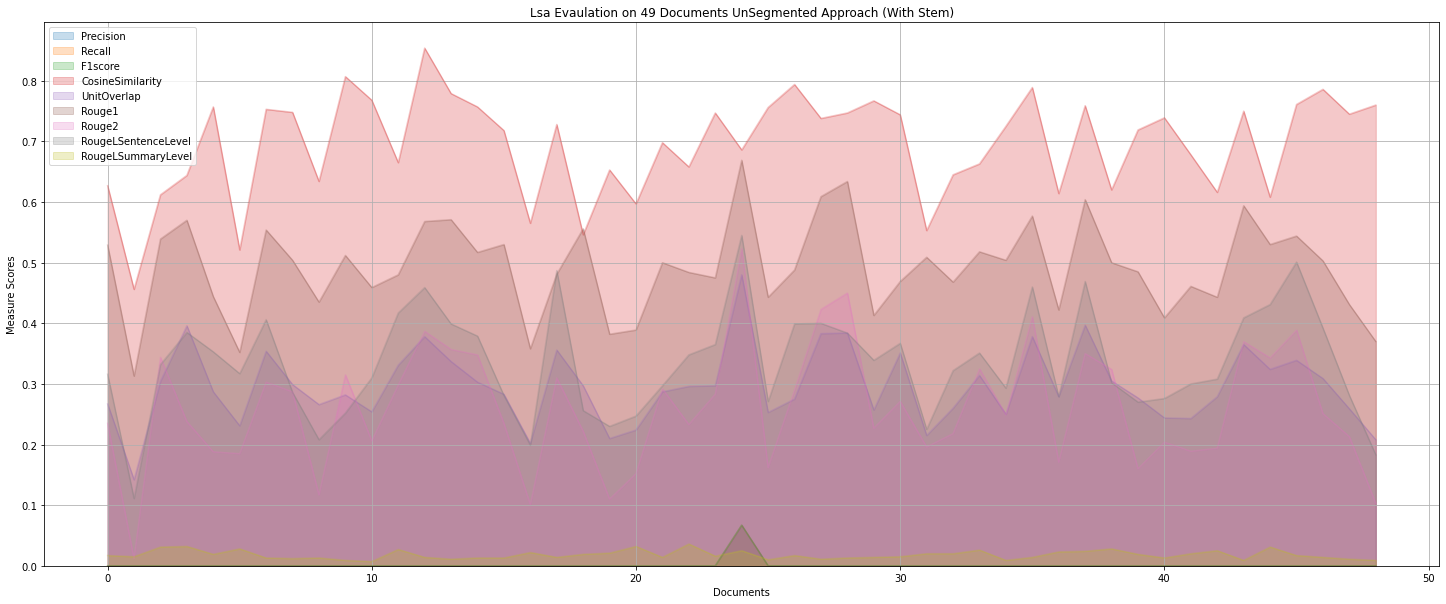

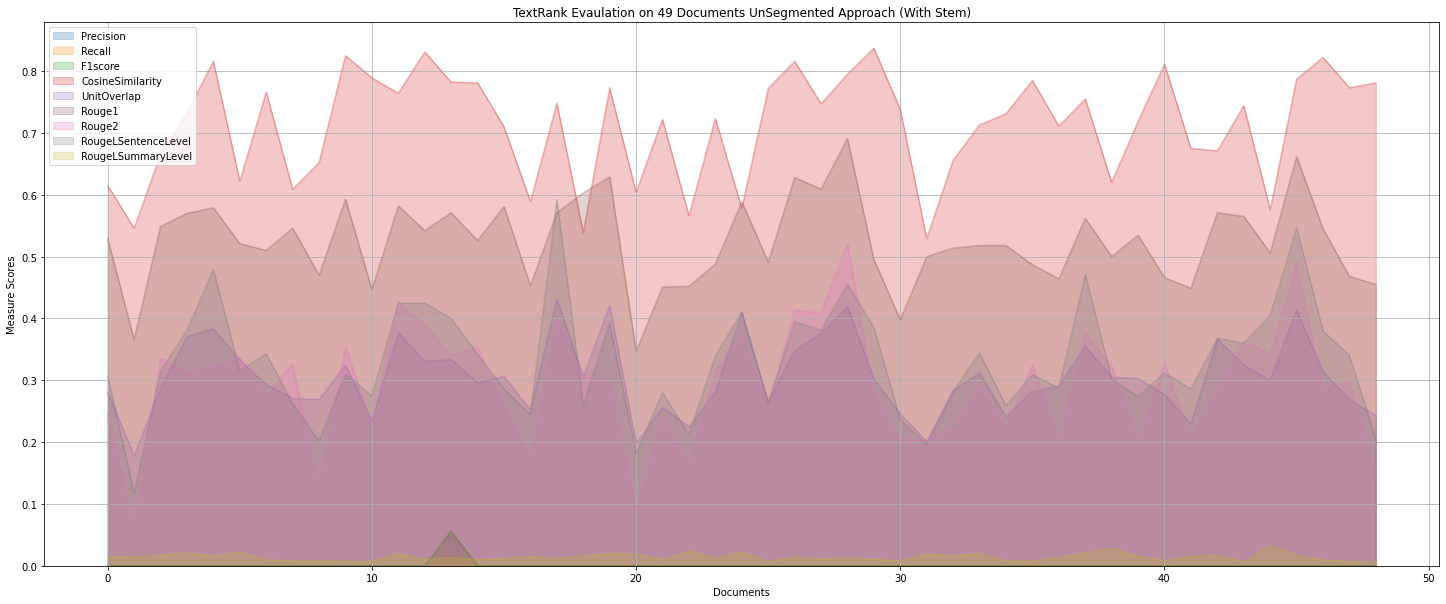

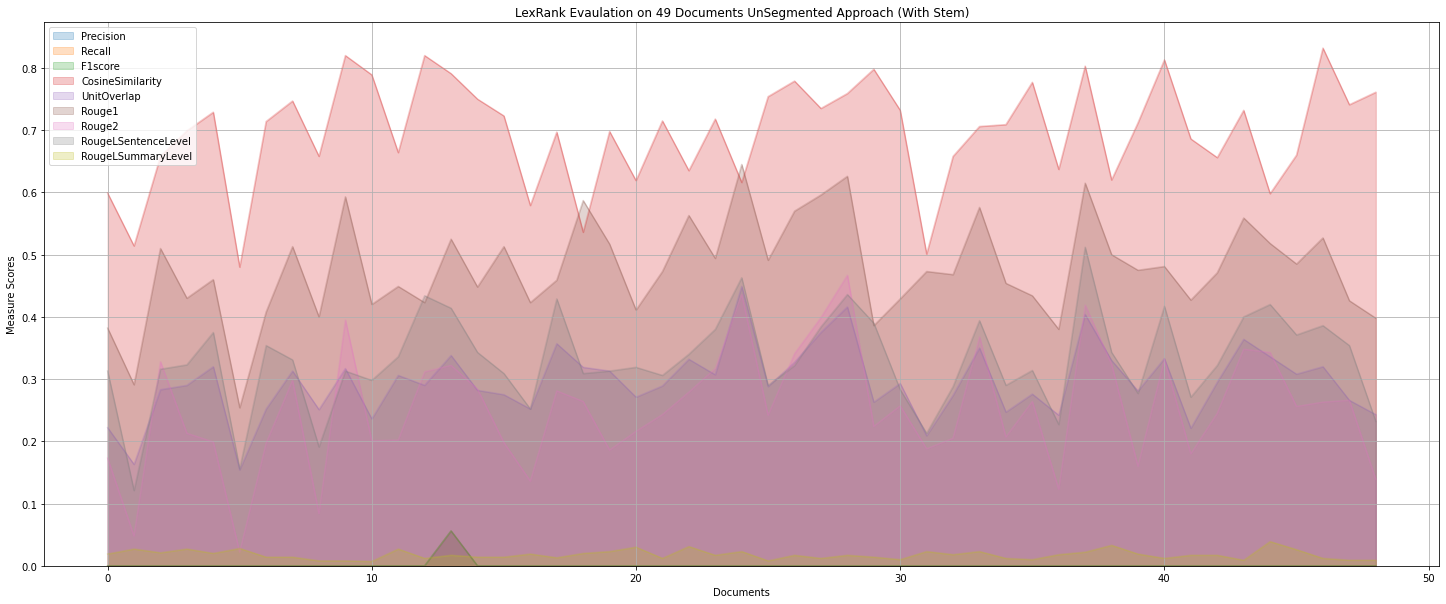

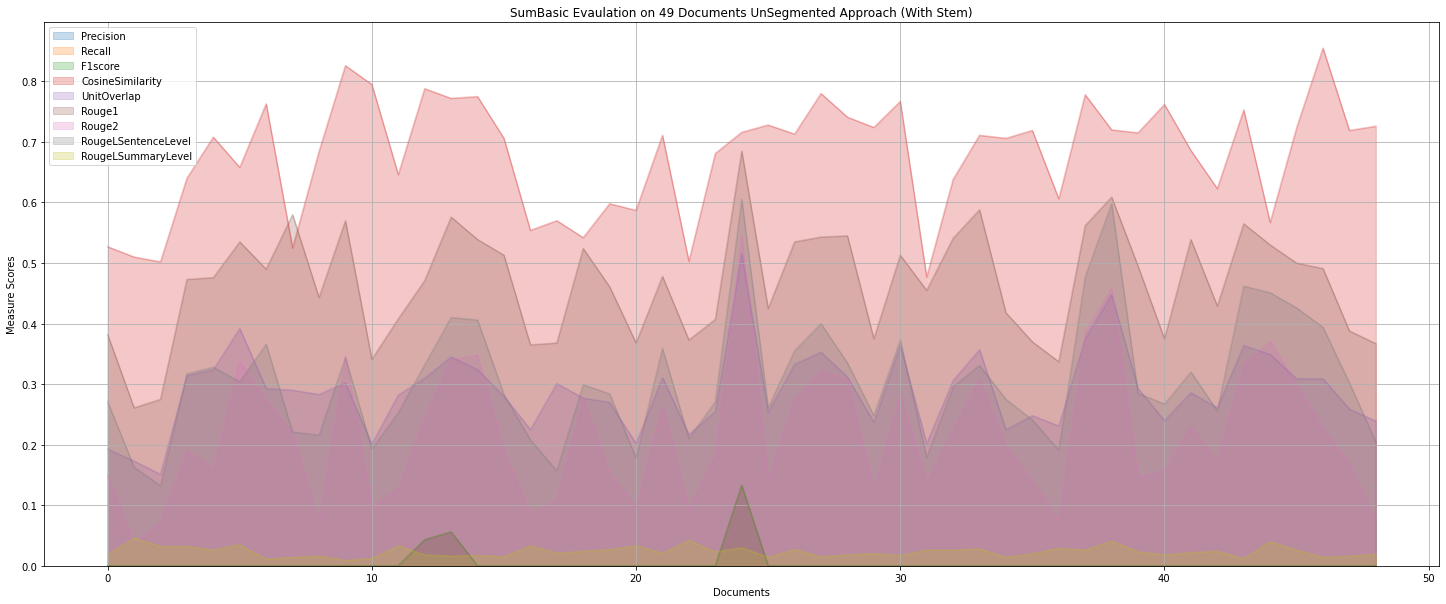

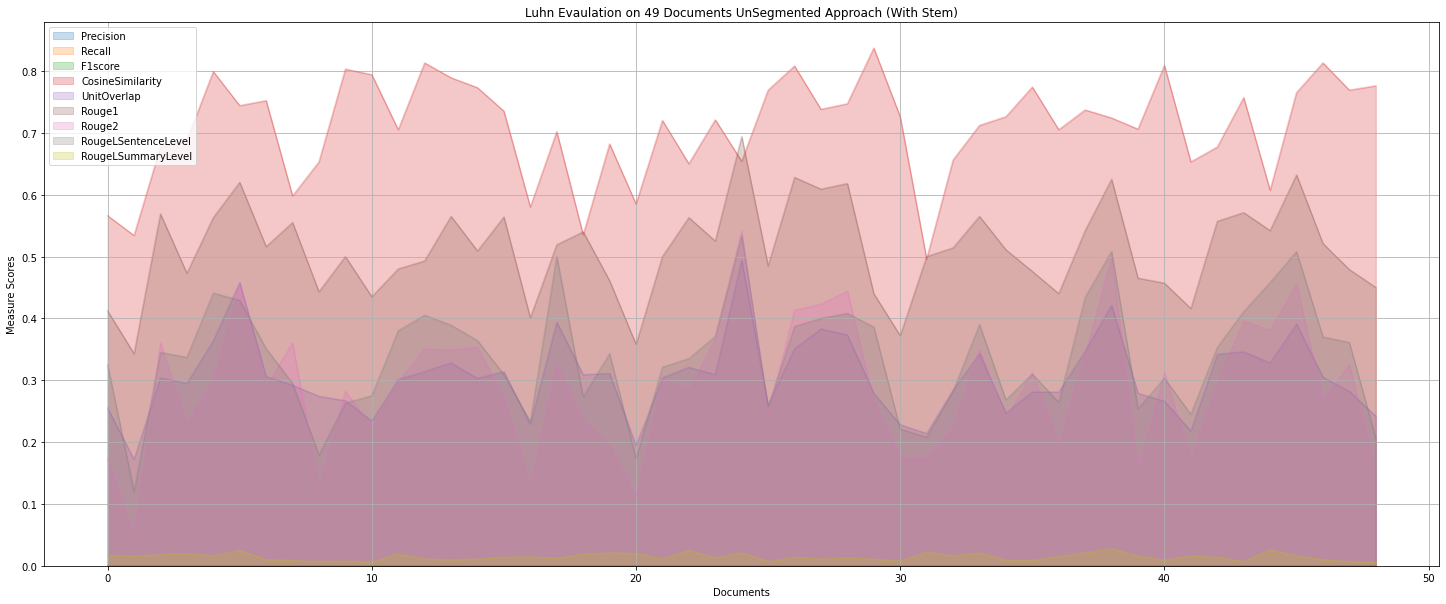

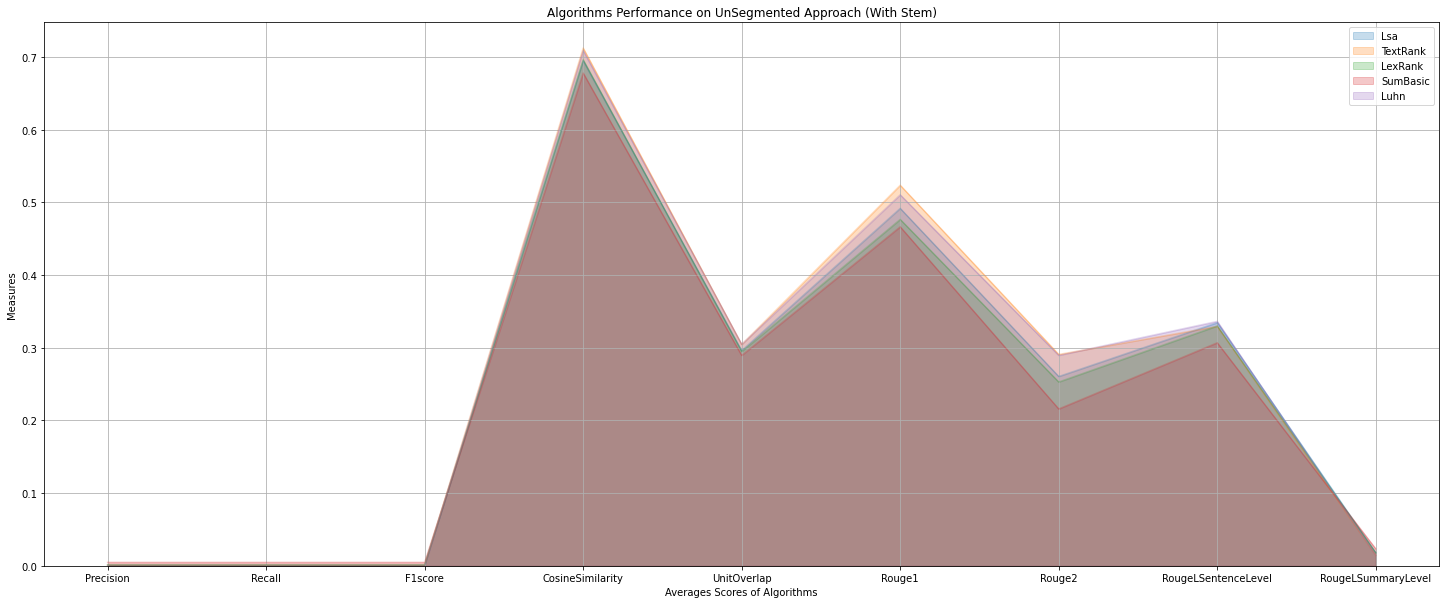

Lsa  TextRank   LexRank  SumBasic      Luhn
Precision            0.001367  0.001143  0.001143  0.004735  0.000000
Recall               0.001367  0.001143  0.001143  0.004735  0.000000
F1score              0.001367  0.001143  0.001143  0.004735  0.000000
CosineSimilarity     0.694980  0.712469  0.696469  0.678041  0.708959
UnitOverlap          0.296143  0.304490  0.294735  0.289469  0.304837
Rouge1               0.491816  0.523714  0.476653  0.466469  0.510531
Rouge2               0.260490  0.290878  0.252939  0.215796  0.289551
RougeLSentenceLevel  0.334633  0.329429  0.330082  0.306898  0.336367
RougeLSummaryLevel   0.018061  0.014224  0.017776  0.023245  0.014408

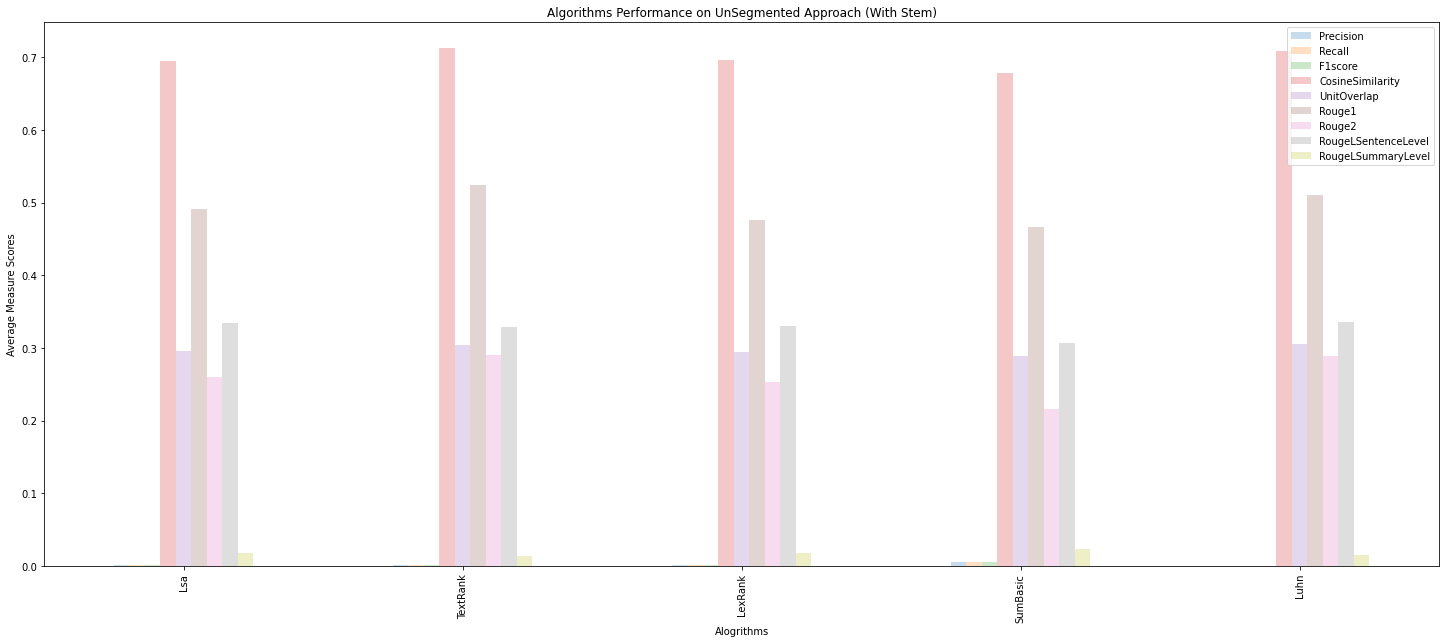

In [ ]:
AggregateResults(df_non_seg_stem,AVAILABLE_Algo,'UnSegmented Approach (With Stem)')

# Non-Segment Evaluation on Graph without Stem

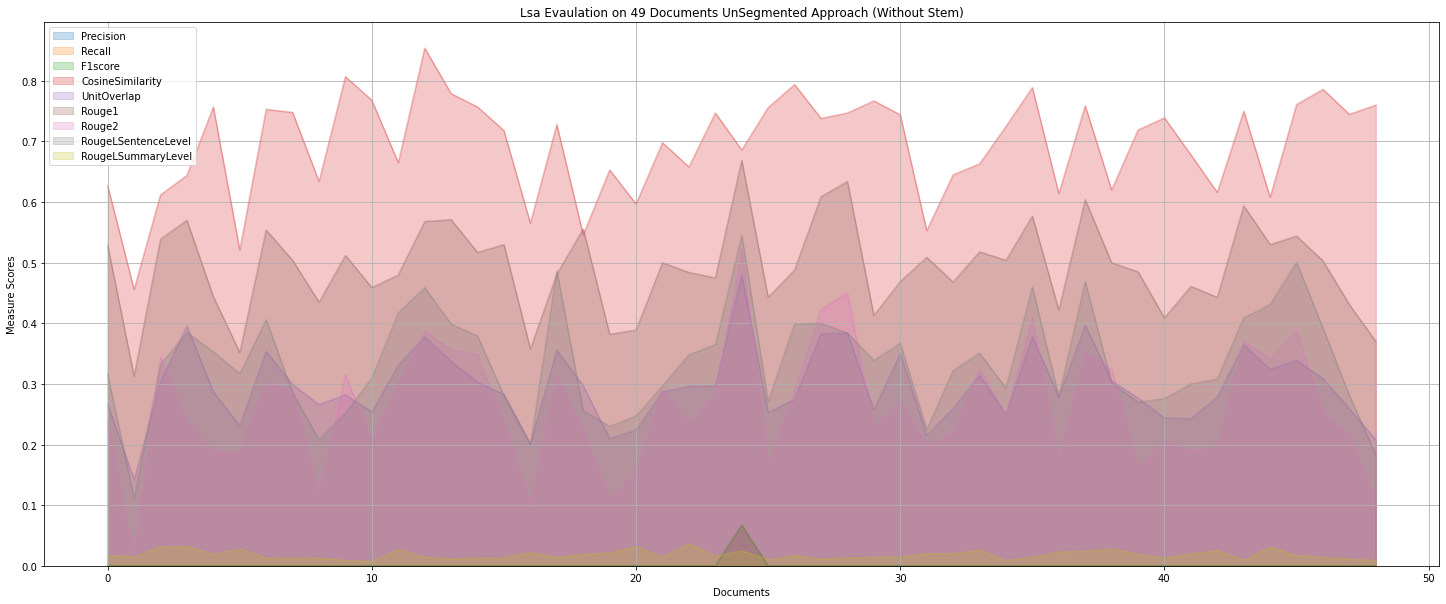

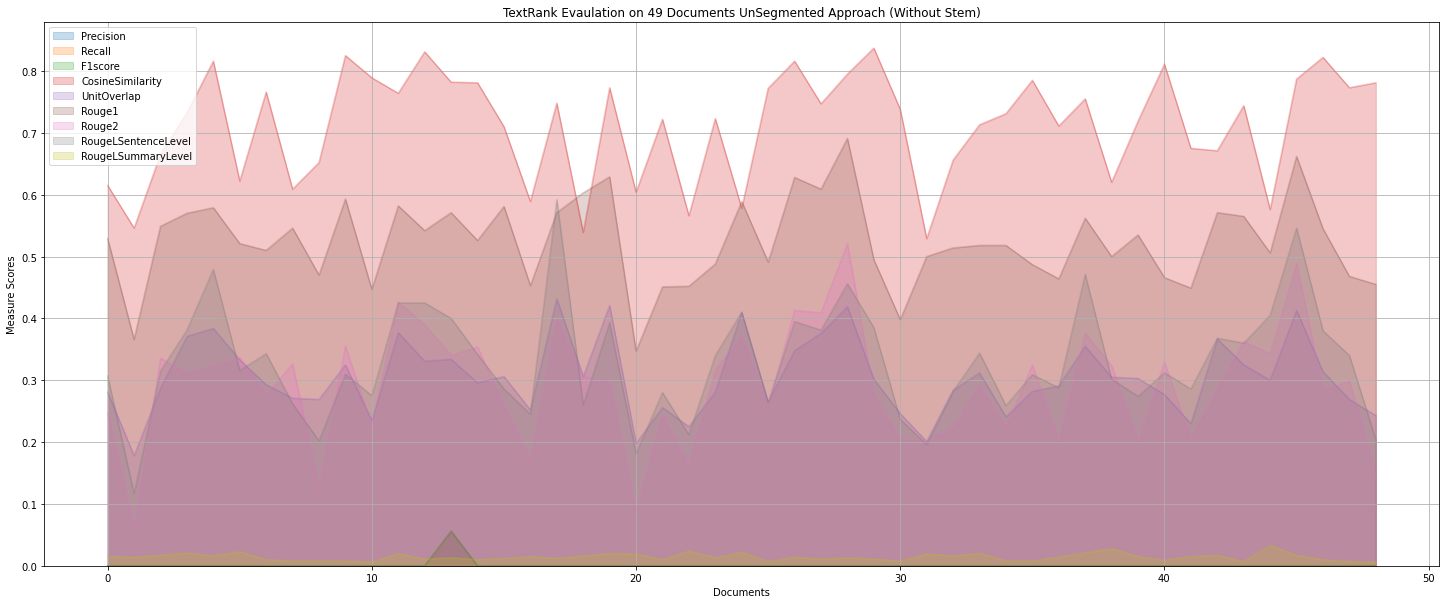

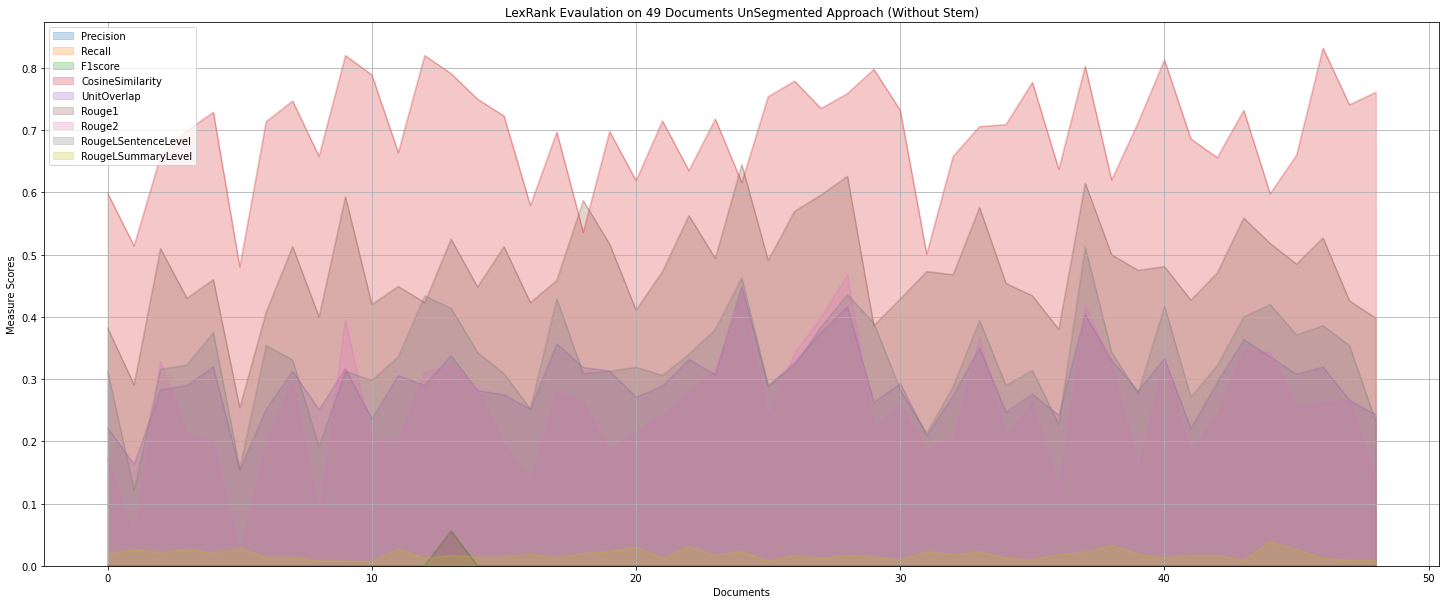

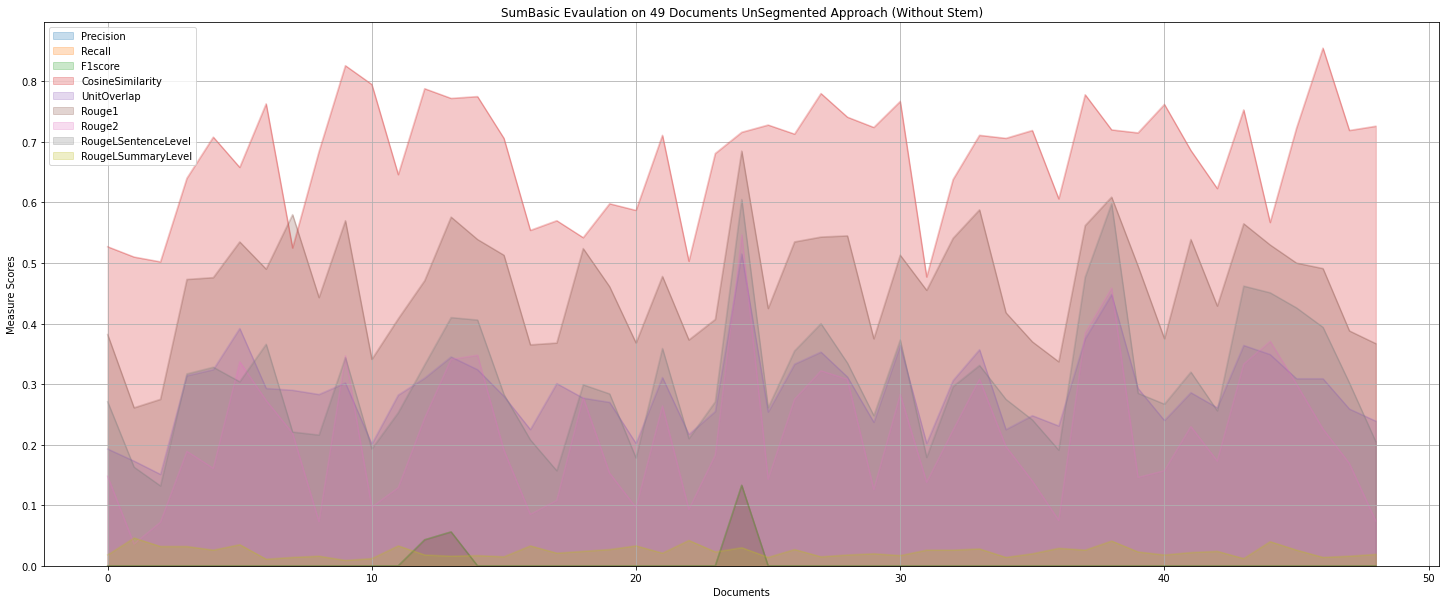

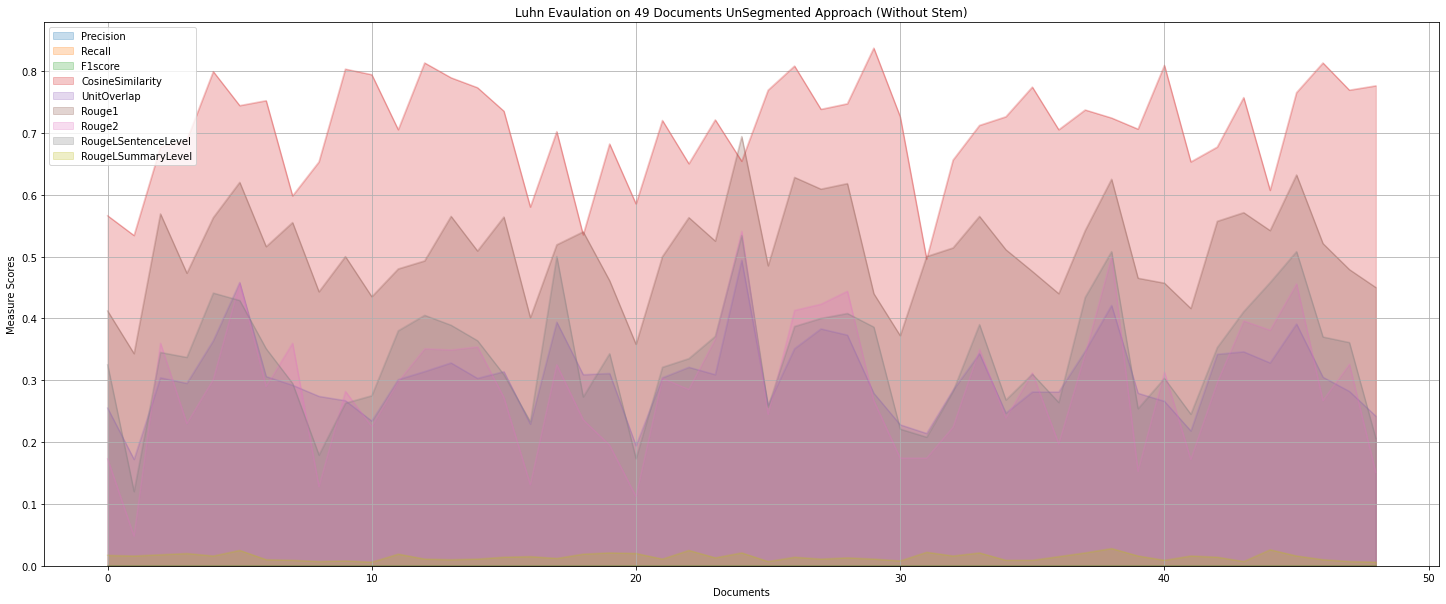

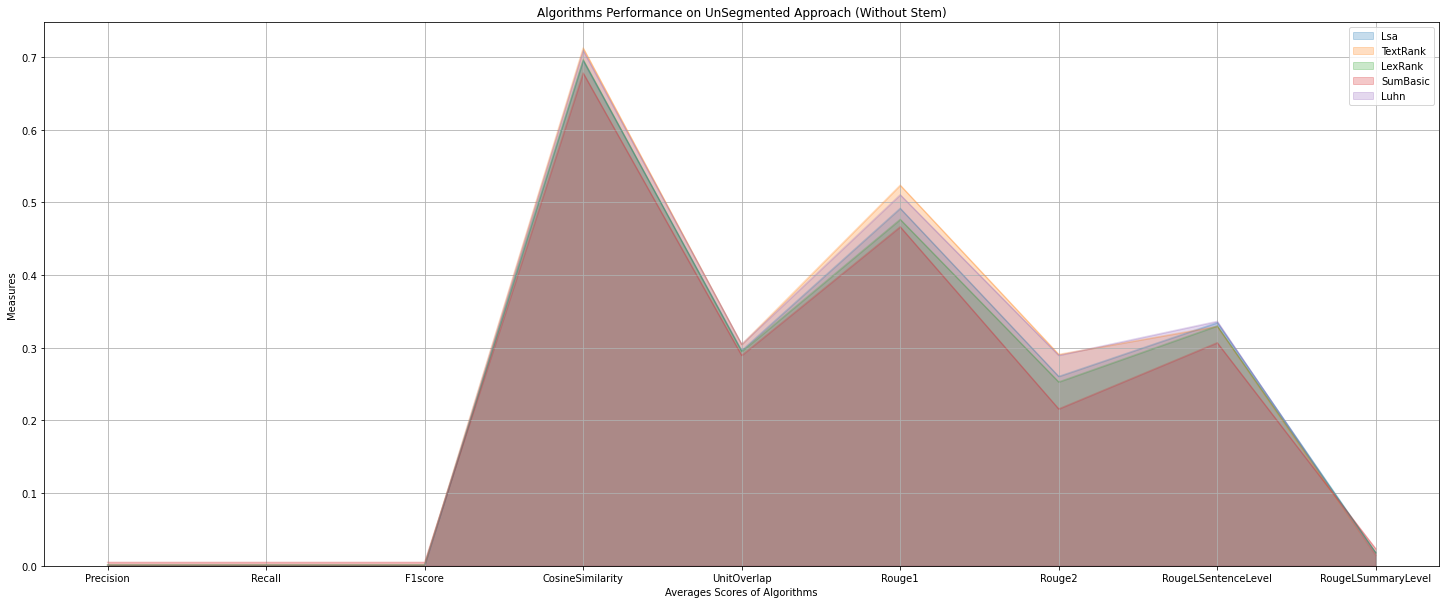

Lsa  TextRank   LexRank  SumBasic      Luhn
Precision            0.001367  0.001143  0.001143  0.004735  0.000000
Recall               0.001367  0.001143  0.001143  0.004735  0.000000
F1score              0.001367  0.001143  0.001143  0.004735  0.000000
CosineSimilarity     0.694980  0.712469  0.696469  0.678041  0.708959
UnitOverlap          0.296143  0.304490  0.294735  0.289469  0.304837
Rouge1               0.491816  0.523714  0.476653  0.466469  0.510531
Rouge2               0.260490  0.290878  0.252939  0.215796  0.289551
RougeLSentenceLevel  0.334633  0.329429  0.330082  0.306898  0.336367
RougeLSummaryLevel   0.018061  0.014224  0.017776  0.023245  0.014408

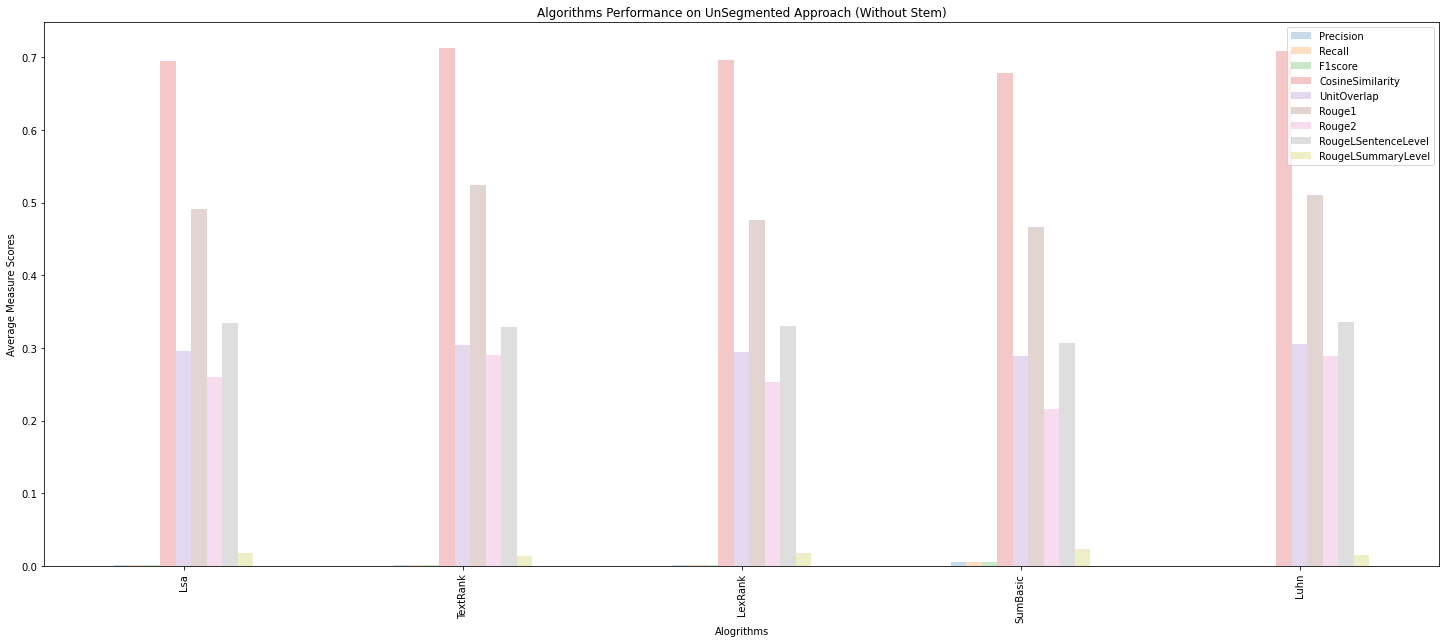

In [ ]:
AggregateResults(df_non_seg,AVAILABLE_Algo,'UnSegmented Approach (Without Stem)')

# Segment Evaluation on Graph with Stem

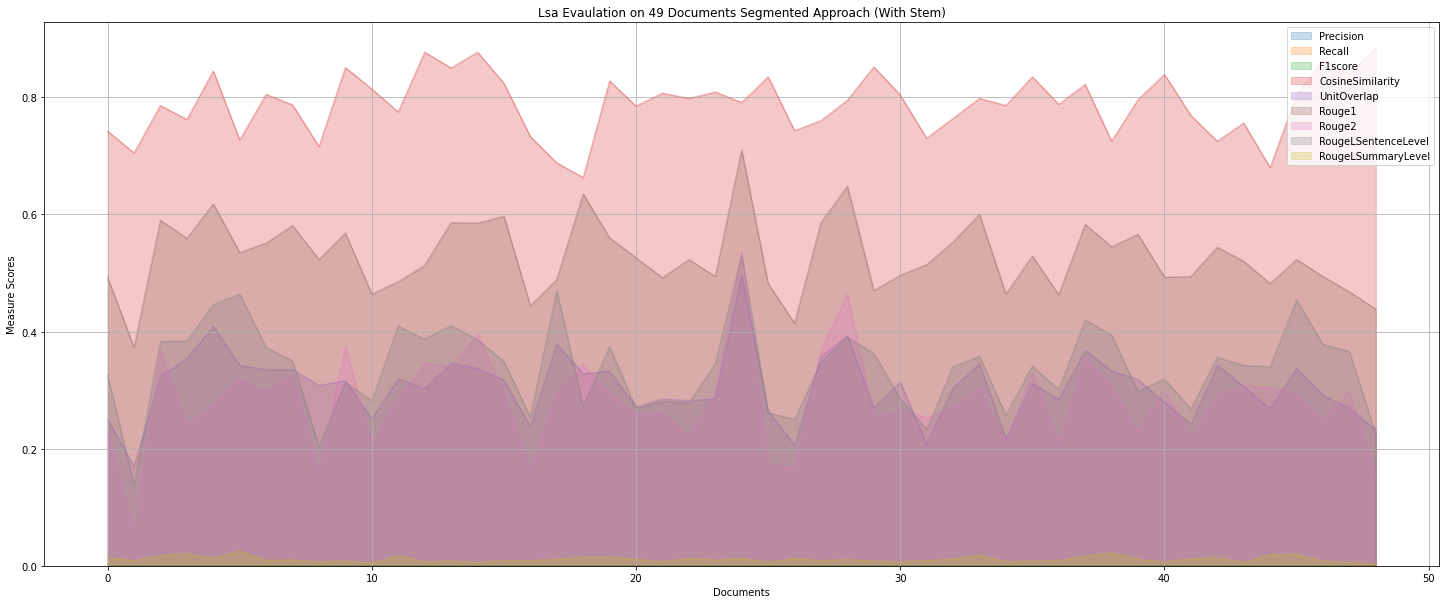

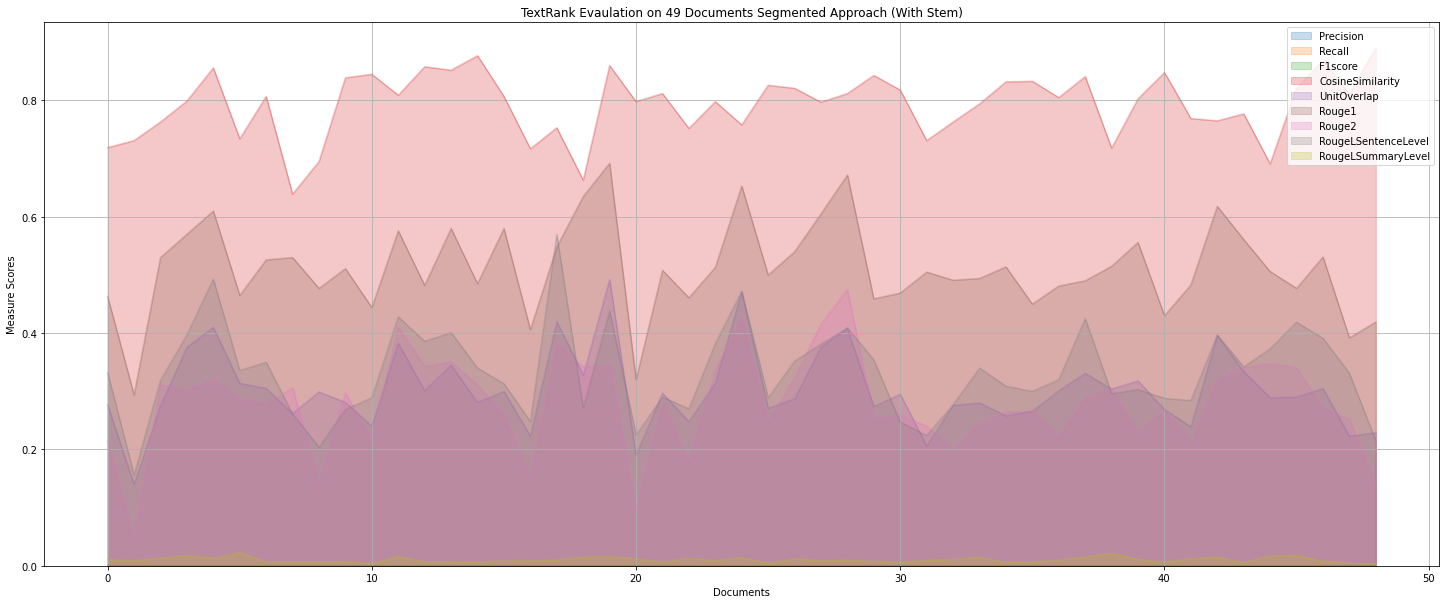

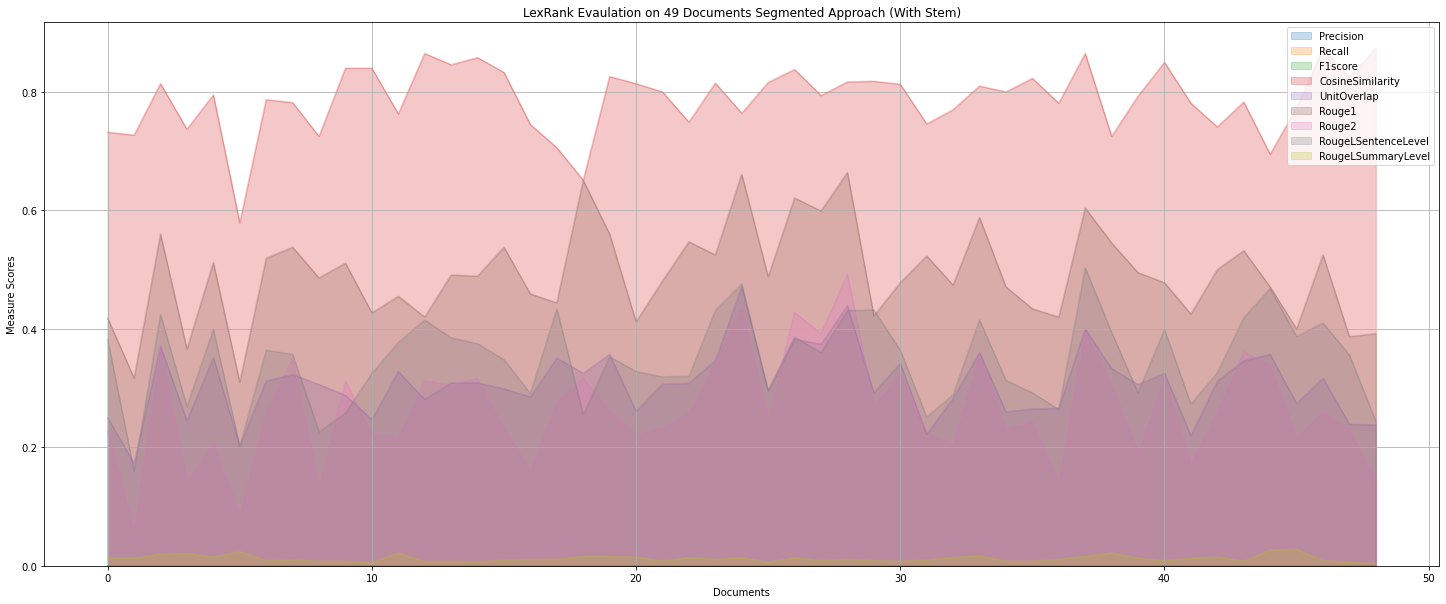

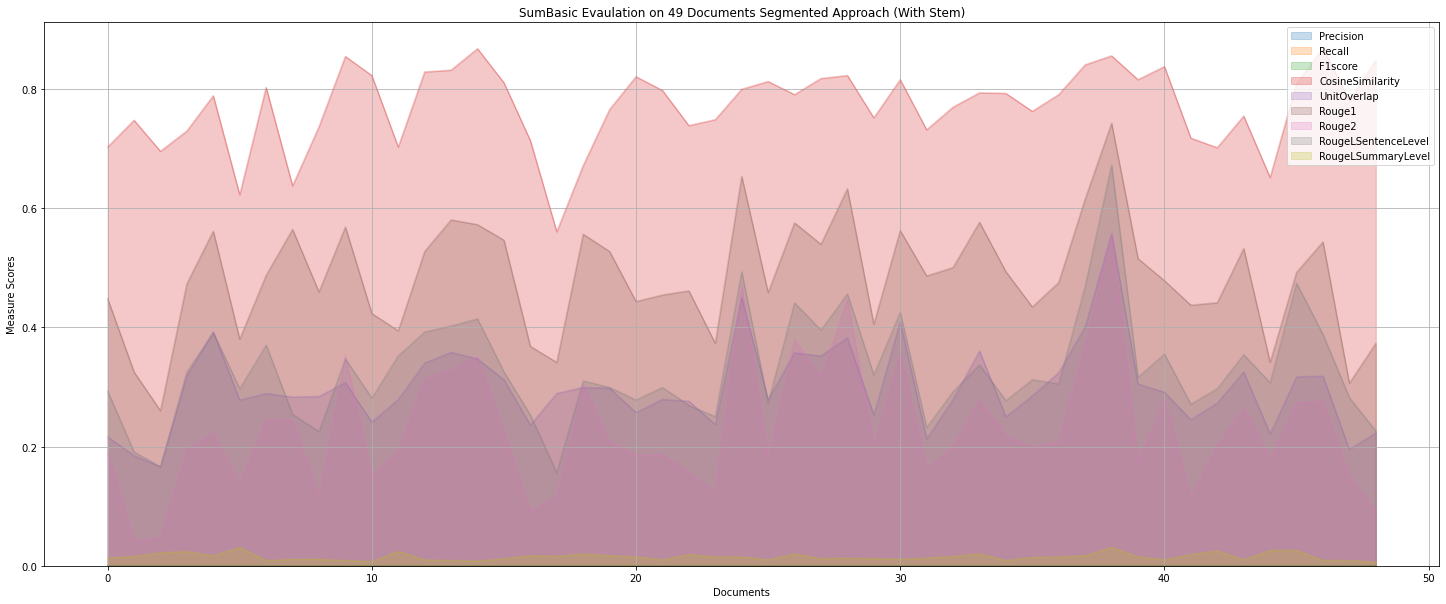

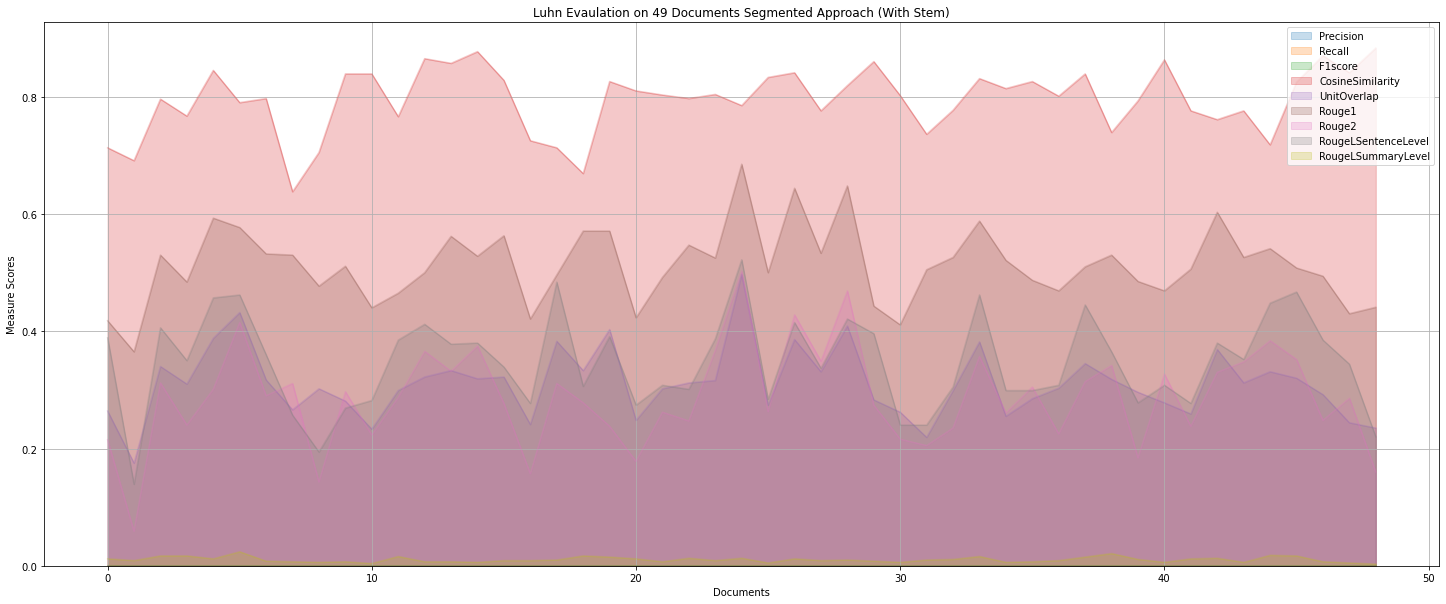

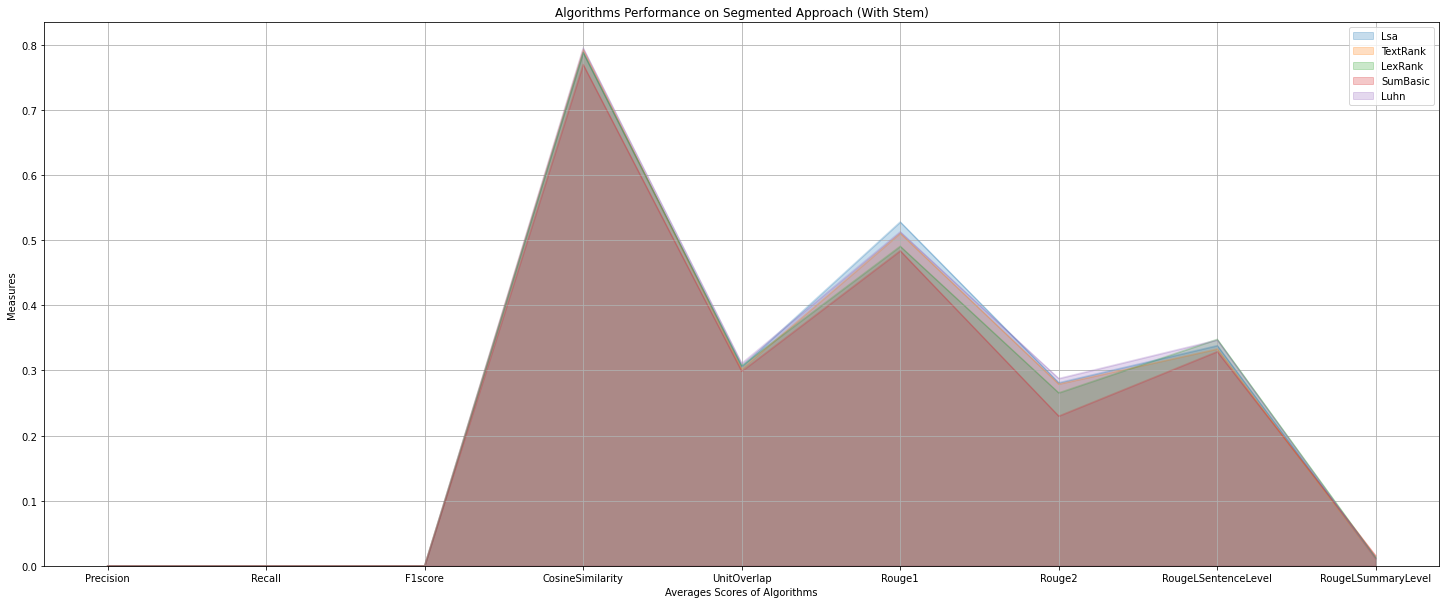

Lsa  TextRank   LexRank  SumBasic      Luhn
Precision            0.000000  0.000000  0.000000  0.000000  0.000000
Recall               0.000000  0.000000  0.000000  0.000000  0.000000
F1score              0.000000  0.000000  0.000000  0.000000  0.000000
CosineSimilarity     0.788551  0.792224  0.787673  0.769388  0.794796
UnitOverlap          0.305592  0.301980  0.307245  0.298592  0.310714
Rouge1               0.527816  0.510551  0.490469  0.483531  0.512735
Rouge2               0.280980  0.278959  0.265449  0.229776  0.287449
RougeLSentenceLevel  0.338000  0.332796  0.347694  0.328735  0.346612
RougeLSummaryLevel   0.011245  0.010551  0.012469  0.015204  0.010531

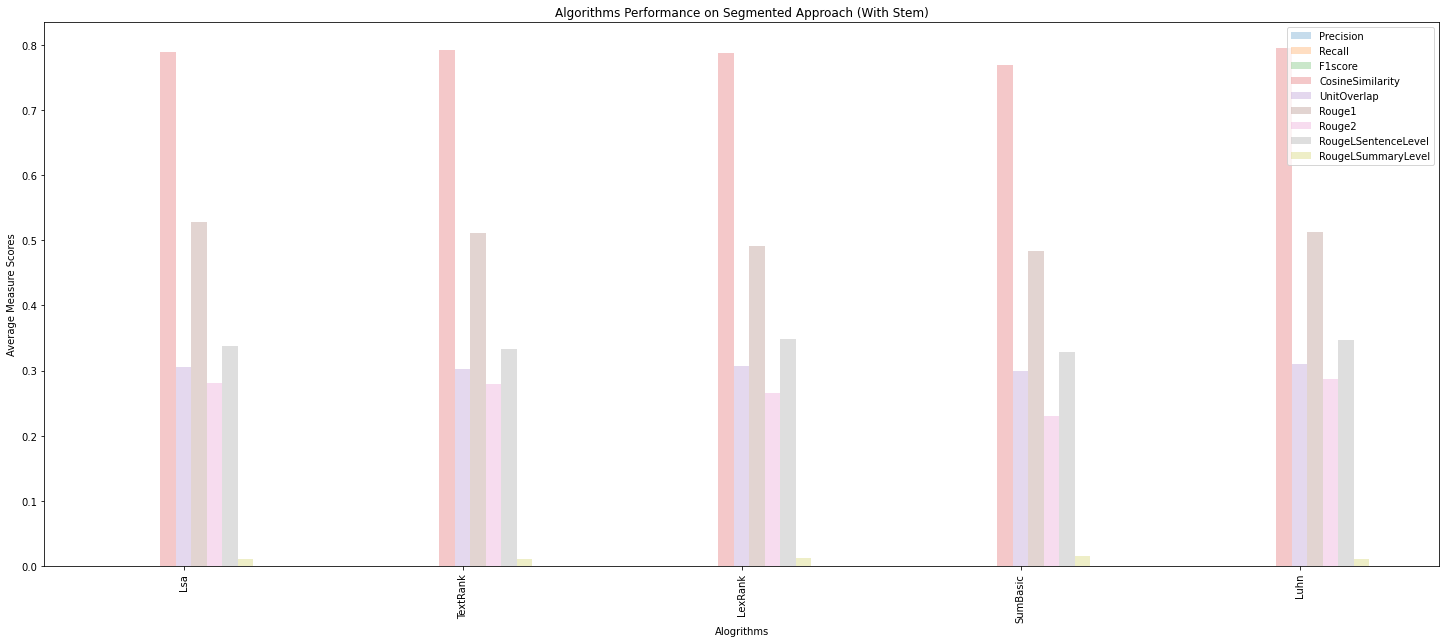

In [ ]:
AggregateResults(df_seg_stem,AVAILABLE_Algo,'Segmented Approach (With Stem)')

#Segment Evaluation on Graph without Stem

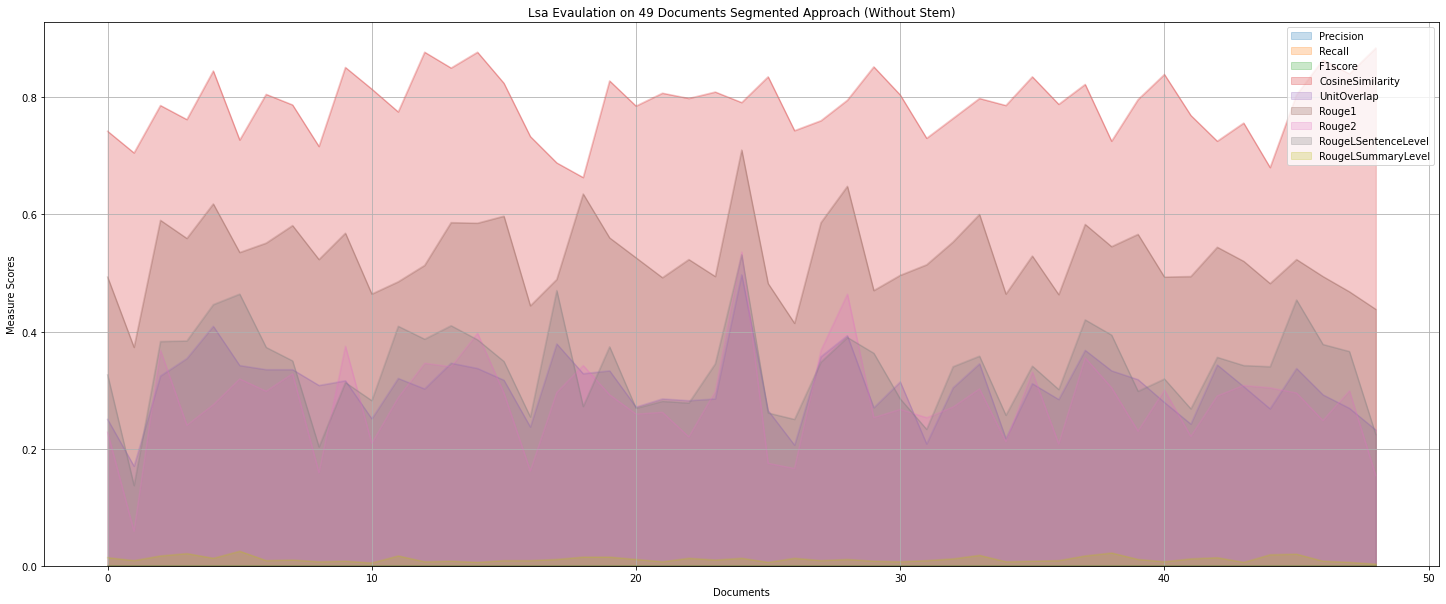

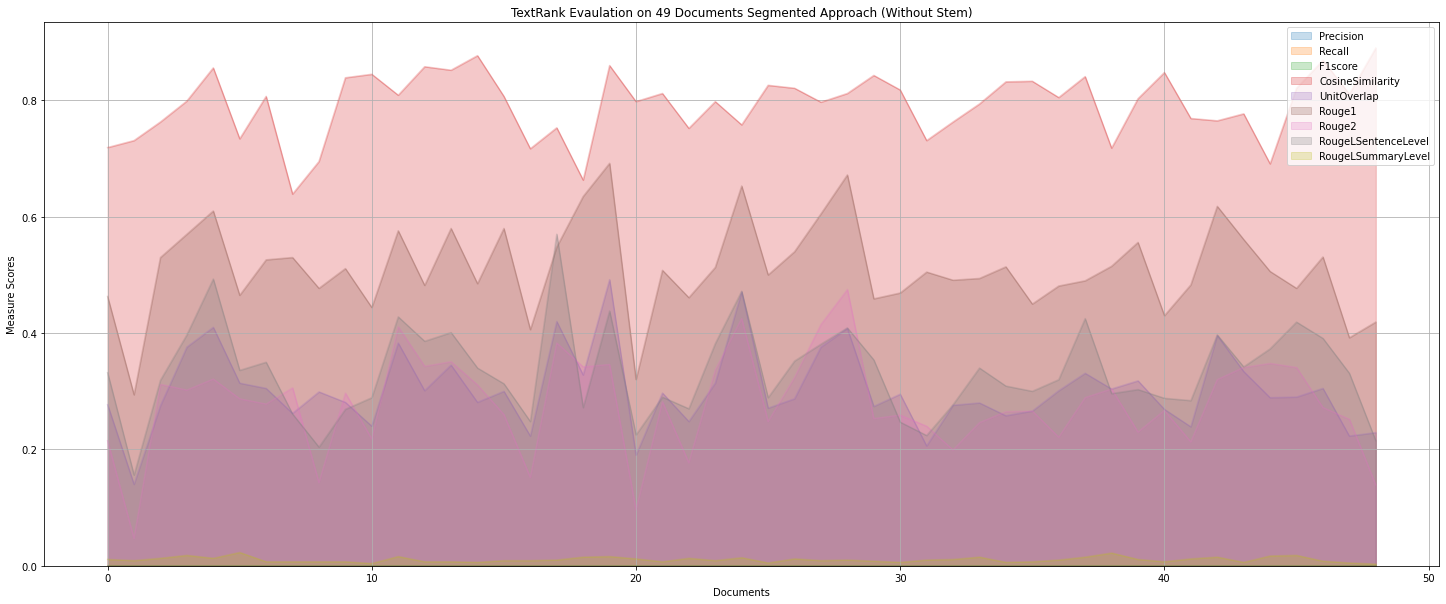

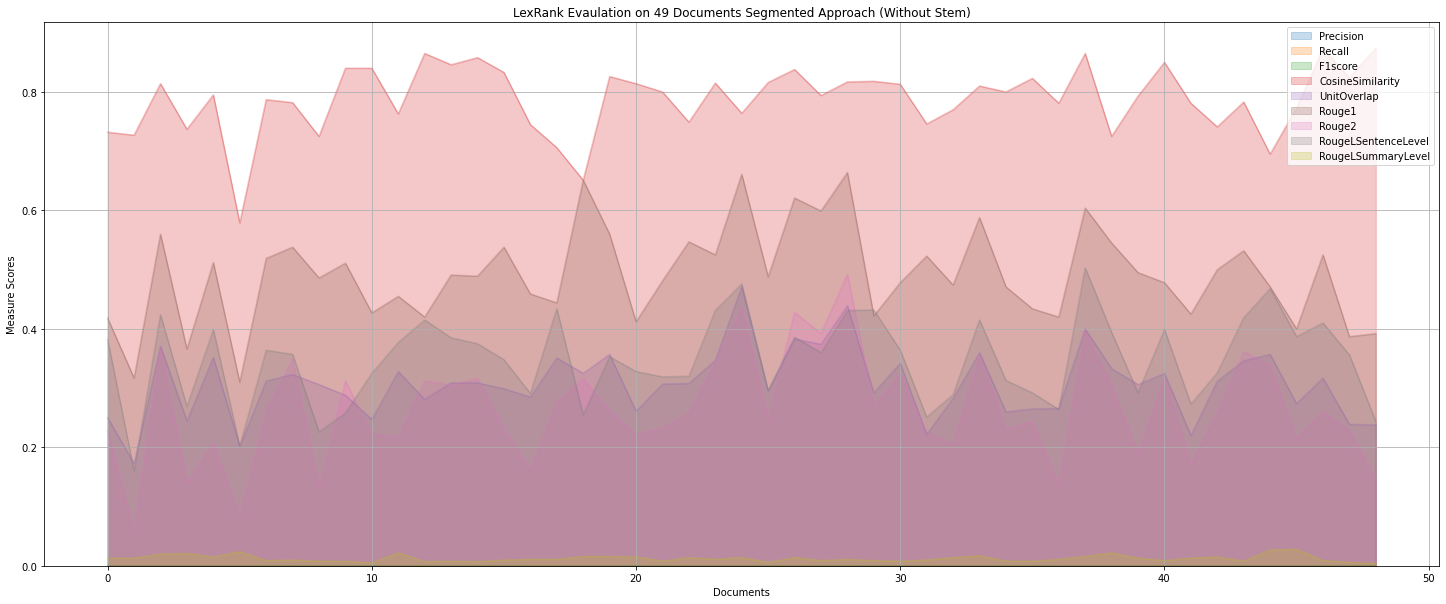

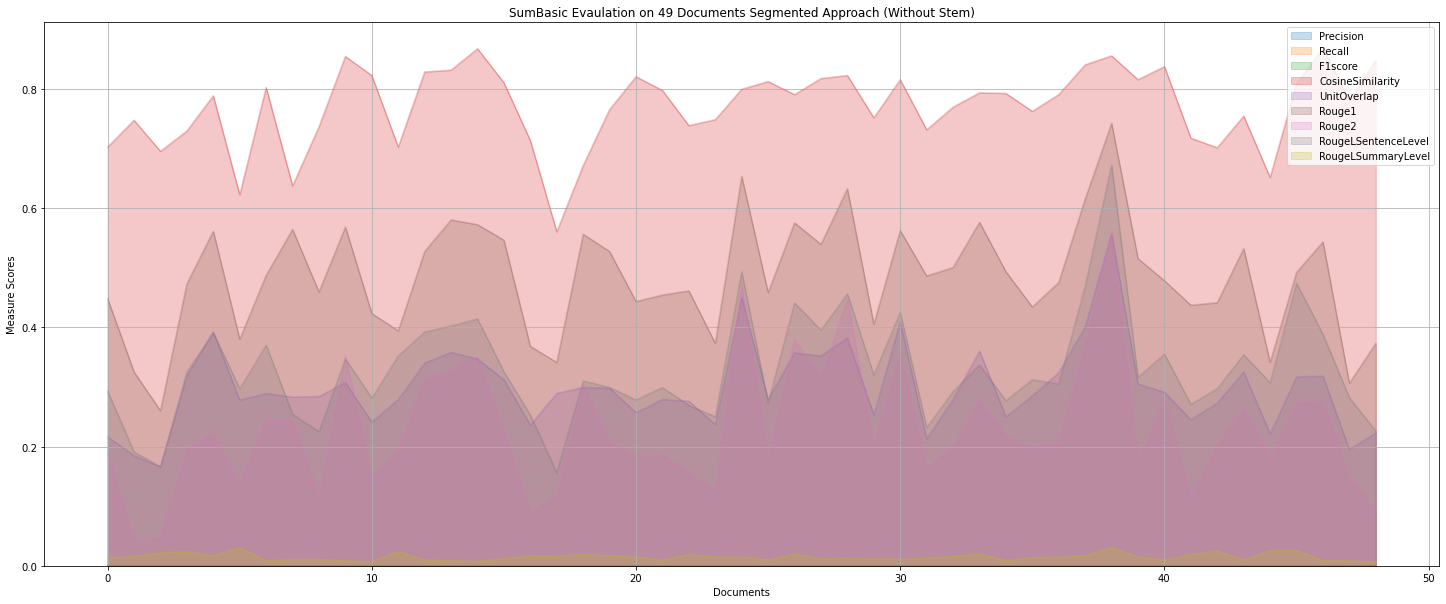

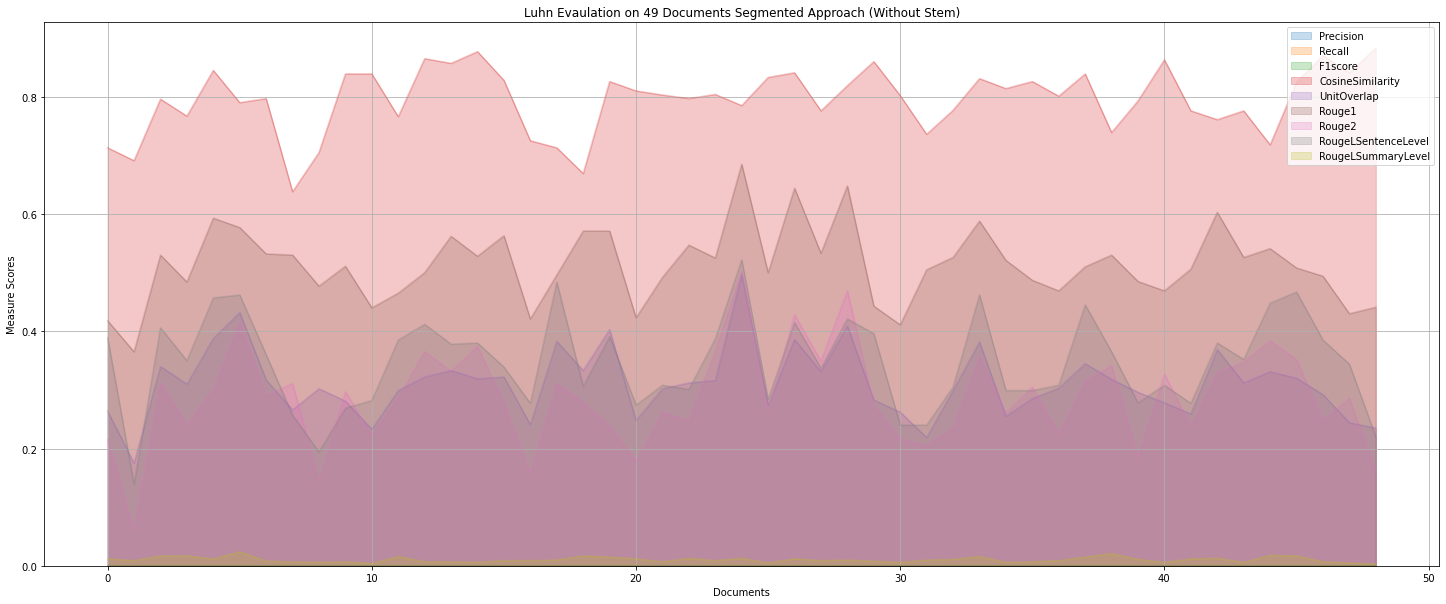

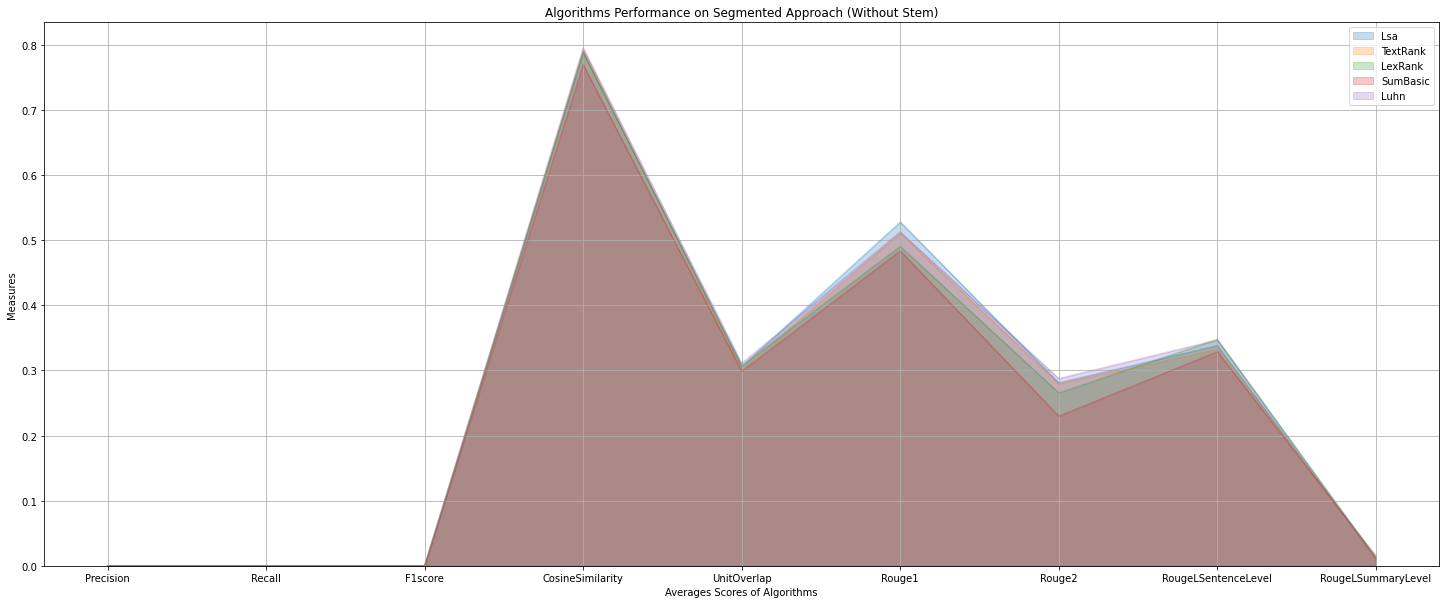

Lsa  TextRank   LexRank  SumBasic      Luhn
Precision            0.000000  0.000000  0.000000  0.000000  0.000000
Recall               0.000000  0.000000  0.000000  0.000000  0.000000
F1score              0.000000  0.000000  0.000000  0.000000  0.000000
CosineSimilarity     0.788551  0.792224  0.787673  0.769388  0.794796
UnitOverlap          0.305592  0.301980  0.307245  0.298592  0.310714
Rouge1               0.527816  0.510551  0.490469  0.483531  0.512735
Rouge2               0.280980  0.278959  0.265449  0.229776  0.287449
RougeLSentenceLevel  0.338000  0.332796  0.347694  0.328735  0.346612
RougeLSummaryLevel   0.011245  0.010551  0.012469  0.015204  0.010531

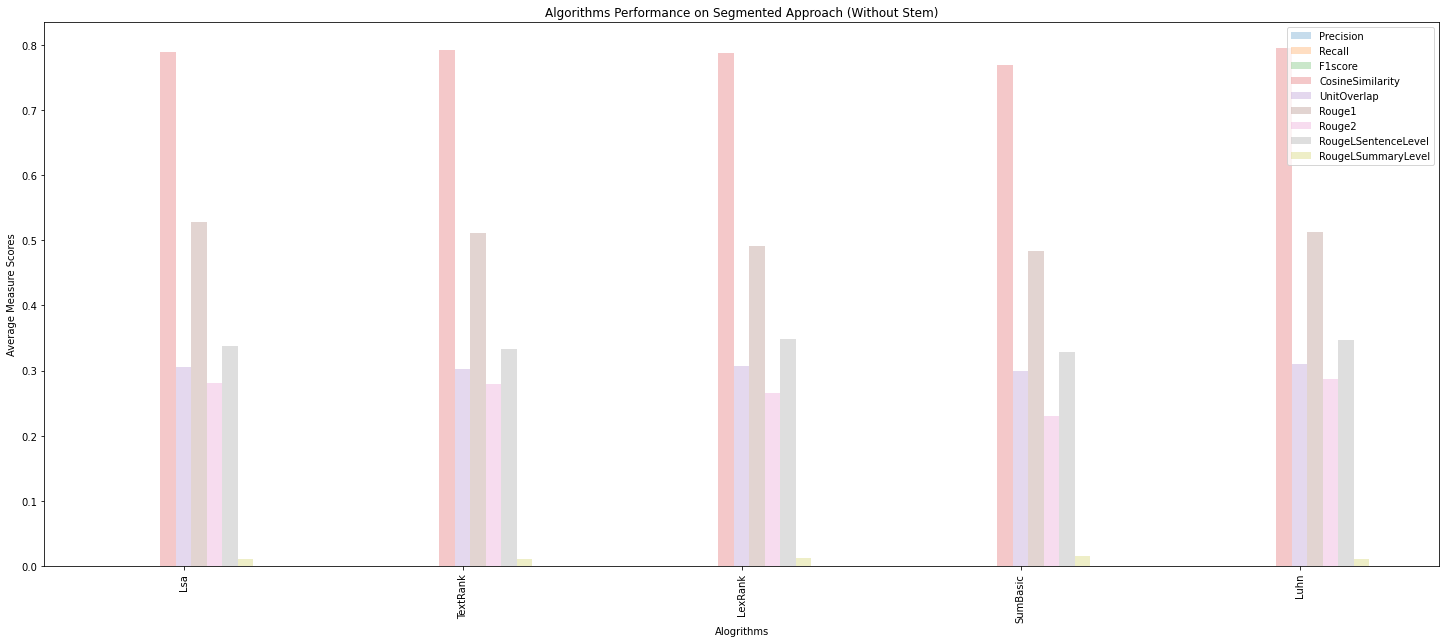

In [ ]:
AggregateResults(df_seg,AVAILABLE_Algo,'Segmented Approach (Without Stem)')

# Text summarization from URL

In [ ]:
SENTENCES_COUNT = 3


url="https://www.bbc.com/urdu/regional-55821823"
url="https://www.dawnnews.tv/news/1152614/"

parser = HtmlParser.from_url(url, getUrduTokenzer(1))
print ("----")    
print ("--Luhaummarizer--")   
print ("----")   
summarizer = LuhnSummarizer()
for sentence in summarizer(parser.document, SENTENCES_COUNT):
    print(sentence)

print ("----")       
print ("--LsaSummarizer--") 
print ("----")   
summarizer = LsaSummarizer()
for sentence in summarizer(parser.document, SENTENCES_COUNT):
    print(sentence)    
print ("----")       
print ("--TextRankSummarizer--")   
print ("----")   
summarizer = TextRankSummarizer()
for sentence in summarizer(parser.document, SENTENCES_COUNT):
    print(sentence) 

----
--Luhaummarizer--
----
ملائیشیا کی ایک عدالت نے بدھ کے روز طیارے کی لیز کے معاملے پر دو ہفتے قبل روکے گئے پاکستان انٹرنیشنل ایئرلائن کا طیارہ فوری ریلیز کرنے کا حکم دیا ہے
خبر رساں ایجنسی رائٹرز کے مطابق ملائیشین حکام نے 15 جنوری کو بوئنگ 777 طیارے پر تحویل میں لے لیا تھا جب ایک عدالت نے طیارے کے کرایہ دار پیریگرین ایوی ایشن چارلی لمیٹڈ کی جانب سے درخواست منظور کر لی تھی
ایئر لائن کی نمائندگی کرنے والے ایک وکیل کے مطابق دونوں فریقوں کی جانب سے کہا گیا ہے کہ وہ تنازع کی دوستانہ طریقے سے تصفیے پر راضی ہو گئے جس کے بعد کوالالمپور ہائی کورٹ نے طیارے کو فوری طور پر رہا کرنے کا حکم دیا
----
--LsaSummarizer--
----
خبر رساں ایجنسی رائٹرز کے مطابق ملائیشین حکام نے 15 جنوری کو بوئنگ 777 طیارے پر تحویل میں لے لیا تھا جب ایک عدالت نے طیارے کے کرایہ دار پیریگرین ایوی ایشن چارلی لمیٹڈ کی جانب سے درخواست منظور کر لی تھی
پی آئی اے کے وکیل کوان ول سین ​​نے کہا کہ پیریگرین پی آئی اے سی کے خلاف اپنا مقدمہ واپس لینے اور حکم امتناعی احکامات کو مسترد کرنے پر رضامند ہوگئی ہے
وہ اس پورٹ فولیو کا ایک حصہ 